<h1 style="background-color:MediumTurquoise;border-radius:5px;text-align:center;padding:15px;color:white;">AI Technologies Assignment - Part 3</h1>
<h4>Done by: V Varsha (203011T)<br><br>Module Code: IT3312</h4>

## 1. Import Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tarfile
import seaborn as sns
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout,BatchNormalization
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
import visualkeras

## 2. Read Data

In [15]:
#read the different batches of data
train_batch1 = pd.read_pickle("train_batch1.pkl")  
train_batch2 = pd.read_pickle("train_batch2.pkl")  
train_batch3 = pd.read_pickle("train_batch3.pkl")  
train_batch4 = pd.read_pickle("train_batch4.pkl")  
train_batch5 = pd.read_pickle("train_batch5.pkl")  
test_data = pd.read_pickle("test_batch1.pkl")  
#merge the training data into a single dataframe
train_data=pd.concat([train_batch1, train_batch2,train_batch3,train_batch4,train_batch5])

In [16]:
# X_train and X_test dataset are the training and testing dataset without the 'label' column 
X_train = train_data.iloc[:,:-1]
X_test=test_data.iloc[:,:-1]

# y_train and y_test datasets are the training dataset and testing dataset with the 'label' column only
y_train= train_data["label"]
y_test=test_data["label"]


## 3. Data Preparation

In [17]:
# convert from integers to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [18]:
#reshape dataset to feed into CNN
X_train=X_train.values.reshape(50000,32,32,1)
X_test=X_test.values.reshape(10000,32,32,1)

In [19]:
# normalize to range between 0-1
X_train = X_train / 255.0
X_test = X_test / 255.0

## 4. Define Functions

### 4.1 Plot Accuracy & Loss Graph Function

In [6]:
#This function is used to plot the accuracy and loss graph from the history
def plot_loss_accraucy_graph(CNN_history, graph_title):
    loss = CNN_history.history['loss'] #get loss
    val_loss = CNN_history.history['val_loss'] #get val loss
    acc = CNN_history.history['accuracy'] #get accuracy
    val_acc = CNN_history.history['val_accuracy'] #get val accuracy
    epoch = range(len(loss)) #number of epochs

    plt.figure(figsize=(20, 8)) #plot graph
    plt.suptitle(('{}'.format(graph_title)), fontsize=30)
    plt.subplot(1, 2, 1)
    plt.plot(epoch,loss,label='loss')
    plt.plot(epoch,val_loss,label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epoch,acc,label='acc')
    plt.plot(epoch,val_acc,label='val_acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

### 4.2 Evaluvate Model Function

In [7]:
#This function is used to evaluvate the models' performance on the training and testing dataset
def eval_CNN_model(CNN_model,CNN_version):
    _, CNN_train_acc = CNN_model.evaluate(X_train, y_train, verbose=0) #accuracy on training dataset
    _, CNN_test_acc = CNN_model.evaluate(X_test, y_test, verbose=0) #accuracy on testing dataset
    CNN_prediction=CNN_model.predict(X_test)
    print('CNN {} Training Data Accuracy:'.format(CNN_version),round(CNN_train_acc*100,2),"%")
    print('CNN {} Testing Data Accuracy:'.format(CNN_version),round(CNN_test_acc*100,2), '%')
    print('CNN {} Testing Data F1-Score: {}'.format(CNN_version,round(f1_score(y_test, CNN_prediction.argmax(axis=1), average='macro'),3))) #f1-score on testing dataset
    return CNN_prediction.argmax(axis=1)

### 4.3 Plot Confusion Matrix Function & Print Classification Report

In [8]:
#This function is used to plot the confusion matrix and print the classification report
def confusion_matrix_classification_report(CNN_prediction,CNN_version):
    print(classification_report(y_test,CNN_prediction)) #print classification report
    print("---------------------------------------------------------------")
    CNN_confusion_matrix = confusion_matrix(y_test, CNN_prediction) #plot confusion matrix
    sns.set(font_scale=5)
    plt.figure(figsize=(100,50))
    sns.heatmap(CNN_confusion_matrix, annot=True,cmap="Blues")
    plt.title('CNN {} Confusion Matrix'.format(CNN_version),fontsize=100)
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

### 4.4 Unpickle Coloured CIFAR - 10 Files

In [23]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

## 5. Modelling

### 5.1 Set CallBack
The training loop will be checked at end of every epoch for whether the loss is no longer decreasing. Once it's found no longer decreasing, the training terminates. This prevents overfitting 

patience indicates the number of epochs with no improvement after which training will be stopped.
monitor indicates the quantity to be monitored. In this case, it will be the loss

In [9]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

### 5.2 Base Model
This is the model stated in the requirements. This will be the base model which I will build upon to fine tune the model

In [25]:
CNN_v1 = Sequential()
CNN_v1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32,1)))
CNN_v1.add(MaxPooling2D((2, 2)))
CNN_v1.add(Conv2D(64, (3, 3), activation='relu'))
CNN_v1.add(MaxPooling2D((2, 2)))
CNN_v1.add(Conv2D(64, (3, 3), activation='relu'))
CNN_v1.add(MaxPooling2D((2, 2)))
CNN_v1.add(Flatten())
CNN_v1.add(Dense(64, activation='relu'))
CNN_v1.add(Dense(10, activation='softmax'))
CNN_v1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 64)         0

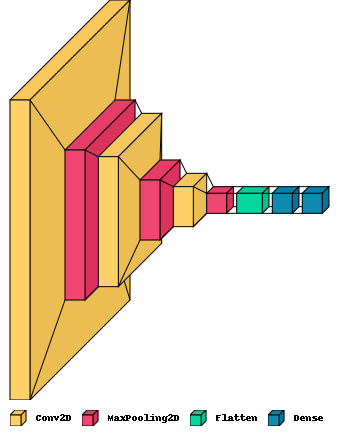

In [14]:
visualkeras.layered_view(CNN_v1, scale_xy=10, legend=True)

In [26]:
CNN_v1.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_v1_history = CNN_v1.fit(X_train,y_train, epochs=500, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/500
1563/1563 [==============================] - 21s 13ms/step - loss: 1.6979 - accuracy: 0.3854 - val_loss: 1.4689 - val_accuracy: 0.4795
Epoch 2/500
1563/1563 [==============================] - 24s 16ms/step - loss: 1.3454 - accuracy: 0.5298 - val_loss: 1.2767 - val_accuracy: 0.5517
Epoch 3/500
1563/1563 [==============================] - 25s 16ms/step - loss: 1.1907 - accuracy: 0.5893 - val_loss: 1.1614 - val_accuracy: 0.5894
Epoch 4/500
1563/1563 [==============================] - 24s 15ms/step - loss: 1.0879 - accuracy: 0.6228 - val_loss: 1.1263 - val_accuracy: 0.6042
Epoch 5/500
1563/1563 [==============================] - 25s 16ms/step - loss: 1.0147 - accuracy: 0.6480 - val_loss: 1.0389 - val_accuracy: 0.6410
Epoch 6/500
1563/1563 [==============================] - 26s 16ms/step - loss: 0.9568 - accuracy: 0.6702 - val_loss: 1.1014 - val_accuracy: 0.6193
Epoch 7/500
1563/1563 [==============================] - 26s 16ms/step - loss: 0.9108 - accuracy: 0.6844 - val_loss: 1

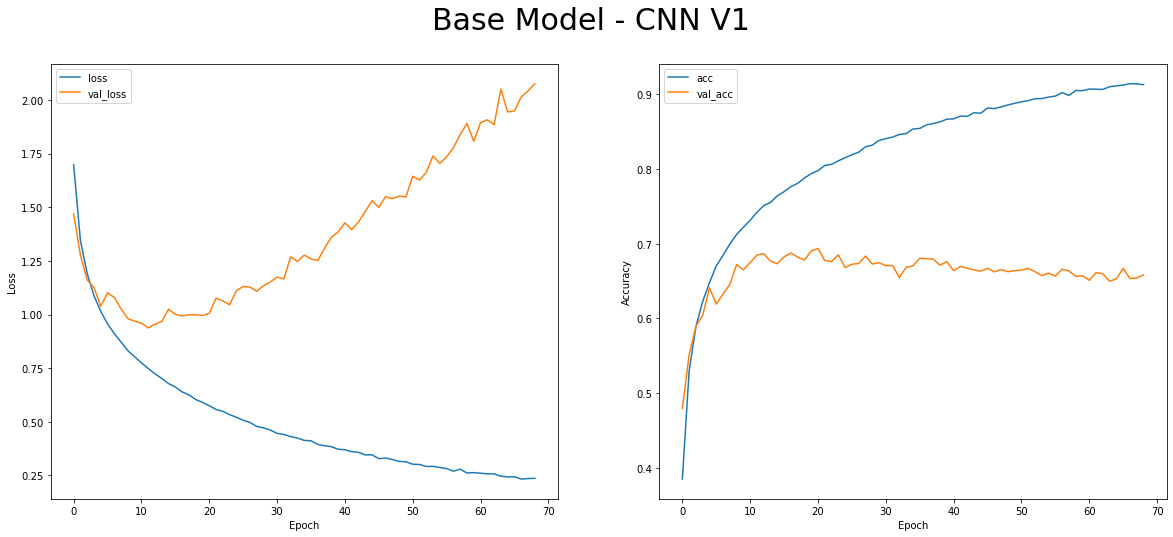

In [27]:
plot_loss_accraucy_graph(CNN_v1_history, "Base Model - CNN V1")

In [29]:
CNN_v1_predictions=eval_CNN_model(CNN_v1,"V1 - Base Model")

CNN V1 - Base Model Training Data Accuracy: 91.92 %
CNN V1 - Base Model Testing Data Accuracy: 65.83 %
CNN V1 - Base Model Testing Data F1-Score: 0.657


              precision    recall  f1-score   support

           0       0.60      0.72      0.66       830
           1       0.73      0.85      0.79       863
           2       0.58      0.50      0.54      1164
           3       0.43      0.50      0.46       850
           4       0.61      0.59      0.60      1037
           5       0.56      0.63      0.59       896
           6       0.76      0.69      0.72      1109
           7       0.70      0.70      0.70      1007
           8       0.79      0.74      0.76      1077
           9       0.81      0.69      0.75      1167

    accuracy                           0.66     10000
   macro avg       0.66      0.66      0.66     10000
weighted avg       0.67      0.66      0.66     10000

---------------------------------------------------------------


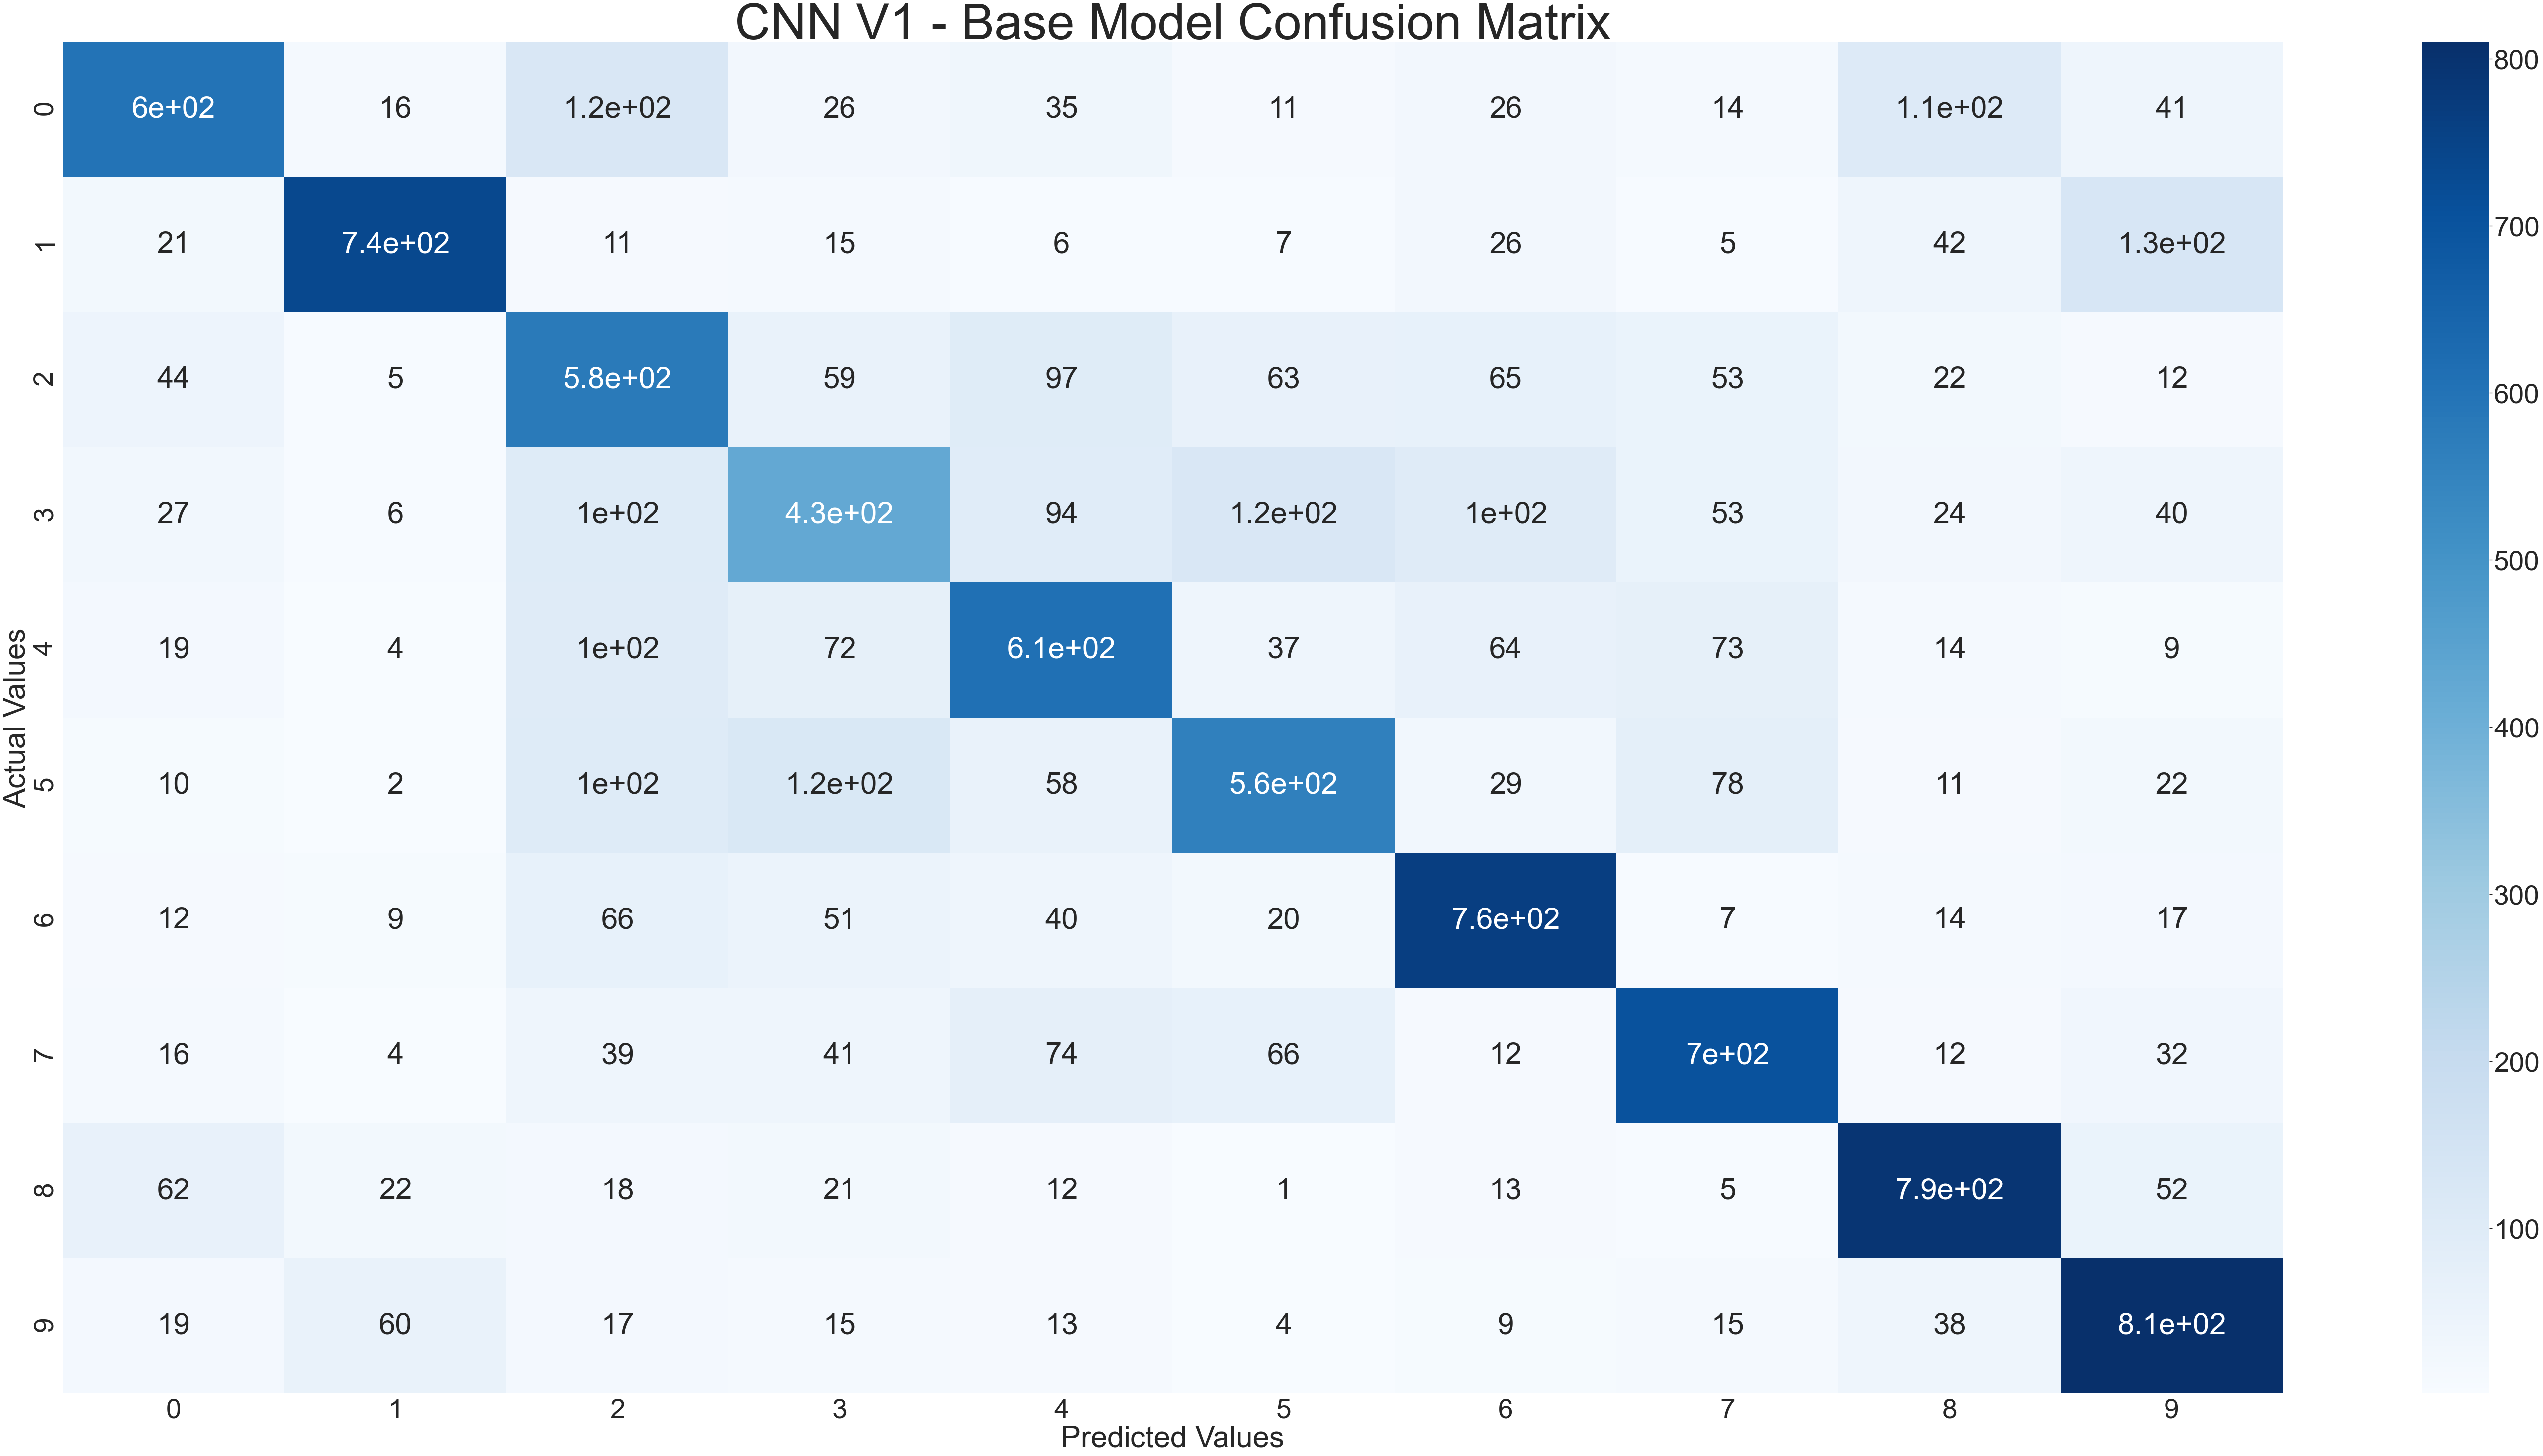

In [30]:
confusion_matrix_classification_report(CNN_v1_predictions,"V1 - Base Model")

This model is poor performing.It is overfitting as the loss is increasing greatly and the accuracy is not high. There is a high variance since there is a large difference between training & validation error.Based on the confusion matrix, the model is misclassifying many samples <br><br>
Overfitting occurs when the model memorises the samples and it is unable to generalize on unseen data. <br>
Overfitting can occur for a few reasons: 
<ol>
    <li> Not enough training data </li>
    <li> Model is too complex </li>
    </ol>


In classification problems, the most important metrics are the precision,recall and f1-score. 
<ul>
    <li>Precision - A measure of how many of the positive predictions made are correctly </li>
    <li> Recall - A measure of how many of the positive cases the classifier correctly predicted, over all the positive cases in the data. </li>
    <li> F1-score - A measure combining both precision and recall. It is generally described as the harmonic mean of the two. </li>
    </ul>
    
As the model is overfitting, it is difficult to evaluvate the model. However, the f1-score, recall and precision are poor across all classes as they are below 0.8. The model is especially performing poorly on Classes 2 and 3.

 Based on the confusion matrix:
<ul>
 <li> Class 0 is generally misclassified to Class 2,8 </li>
<li>Class 1 is generally misclassified to Class 9 </li>
<li>Class 2 is generally misclassified to Class 4, however the misclassification is compratively lower</li>
<li>Class 3 is generally misclassified to Class 5,6 </li>
<li>Class 4 is generally misclassified to Class 2,5,6 </li>
<li>Class 5 is generally misclassified to Class 2,3</li>
<li>Class 6 is generally misclassified to Class 2,however the misclassification is compratively lower </li>
<li>Class 7 is generally misclassified to Class 5,however the misclassification is compratively lower </li>
<li>Class 8 is generally misclassified to Class 0,however the misclassification is compratively lower </li>
<li>Class 9 is generally misclassified to Class 1,however the misclassification is compratively lower </li>
    </ul>

This explains the results of the confusion matrix and classification report

    
 Hence, I will be fine tuning the models' various paramters in order to reduce the overfitting and increase the f1-score.

### 5.3 Fine - Tuning Model

### 5.3.1 Fine - Tuning Model: Same Padding
Same padding means the input image has zero padding so that the output in convolution doesnt differ in size as input. A n-pixel borders of zero is added to prevent reducing the dimensions of the image so that it has the same dimensions as the input. This prevents the image from losing important information

In [92]:
CNN_v2 = Sequential()
CNN_v2.add(Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=(32, 32,1)))
CNN_v2.add(MaxPooling2D((2, 2)))
CNN_v2.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
CNN_v2.add(MaxPooling2D((2, 2)))
CNN_v2.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
CNN_v2.add(MaxPooling2D((2, 2)))
CNN_v2.add(Flatten())
CNN_v2.add(Dense(64, activation='relu'))
CNN_v2.add(Dense(10, activation='softmax'))
CNN_v2.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_96 (Conv2D)          (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_97 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_98 (Conv2D)          (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 4, 4, 64)       

In [94]:
CNN_v2.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_v2_history = CNN_v2.fit(X_train,y_train, epochs=500, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/500
1563/1563 [==============================] - 4s 2ms/step - loss: 1.5638 - accuracy: 0.4406 - val_loss: 1.3119 - val_accuracy: 0.5425
Epoch 2/500
1563/1563 [==============================] - 4s 2ms/step - loss: 1.1390 - accuracy: 0.6044 - val_loss: 1.0830 - val_accuracy: 0.6245
Epoch 3/500
1563/1563 [==============================] - 4s 2ms/step - loss: 0.9906 - accuracy: 0.6574 - val_loss: 1.0002 - val_accuracy: 0.6558
Epoch 4/500
1563/1563 [==============================] - 4s 2ms/step - loss: 0.8943 - accuracy: 0.6896 - val_loss: 0.9869 - val_accuracy: 0.6615
Epoch 5/500
1563/1563 [==============================] - 3s 2ms/step - loss: 0.8285 - accuracy: 0.7121 - val_loss: 0.9103 - val_accuracy: 0.6898
Epoch 6/500
1563/1563 [==============================] - 4s 2ms/step - loss: 0.7772 - accuracy: 0.7319 - val_loss: 0.9240 - val_accuracy: 0.6885
Epoch 7/500
1563/1563 [==============================] - 3s 2ms/step - loss: 0.7299 - accuracy: 0.7472 - val_loss: 0.9235 - val_ac

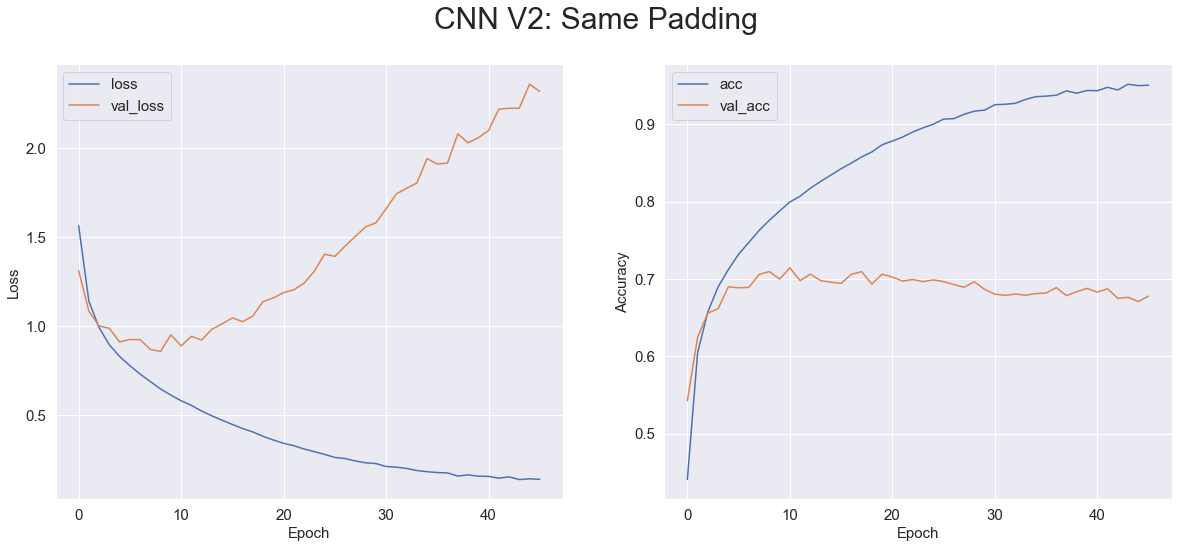

In [99]:
plot_loss_accraucy_graph(CNN_v2_history, "CNN V2: Same Padding")

In [96]:
CNN_v2_predictions=eval_CNN_model(CNN_v2,"V2 - Same Padding")

313/313 [==============================] - 0s 763us/step
CNN V2 - Same Padding Training Data Accuracy: 97.24 %
CNN V2 - Same Padding Testing Data Accuracy: 67.77 %
CNN V2 - Same Padding F1-Score: 0.679


The accuracy on the testing dataset has increased by 1.94% from 65.83% to 67.77%. The f1-score has also increased by 0.022 from 0.657 to 0.679

However, the model is poor performing.It is overfitting as the loss is increasing greatly and the accuracy is not high. There is a high variance since there is a large difference between training & validation error.Based on the f1-score, the model is misclassifying many samples

### 5.3.2 Fine - Tuning Model: Increase Neurons in Convolutional Layers
According to the Occam Razors' theory, I would be doubling the number of neurons in the convolutional layers to test if it would improve the performance of the model. Increasing the neurons, would add complexity to the model. However, it would enable the model to extract more features. Hence, it may be able to generalize better on unseen data.

In [128]:
CNN_v3 = Sequential()
CNN_v3.add(Conv2D(64, (3, 3), activation='relu',padding='same', input_shape=(32, 32,1))) #double neurons
CNN_v3.add(MaxPooling2D((2, 2)))

CNN_v3.add(Conv2D(128, (3, 3), activation='relu',padding='same')) #double neurons
CNN_v3.add(MaxPooling2D((2, 2)))

CNN_v3.add(Conv2D(256, (3, 3), activation='relu',padding='same')) #double neurons
CNN_v3.add(MaxPooling2D((2, 2)))

CNN_v3.add(Flatten())
CNN_v3.add(Dense(64, activation='relu'))
CNN_v3.add(Dense(10, activation='softmax'))
CNN_v3.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_120 (Conv2D)         (None, 32, 32, 64)        640       
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_121 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_122 (Conv2D)         (None, 8, 8, 256)         295168    
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 4, 4, 256)      

In [129]:
CNN_v3.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_v3_history = CNN_v3.fit(X_train,y_train, epochs=500, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/500
1563/1563 [==============================] - 4s 3ms/step - loss: 1.5614 - accuracy: 0.4391 - val_loss: 1.2206 - val_accuracy: 0.5710
Epoch 2/500
1563/1563 [==============================] - 4s 2ms/step - loss: 1.0853 - accuracy: 0.6236 - val_loss: 0.9836 - val_accuracy: 0.6611
Epoch 3/500
1563/1563 [==============================] - 4s 2ms/step - loss: 0.9002 - accuracy: 0.6889 - val_loss: 0.9390 - val_accuracy: 0.6793
Epoch 4/500
1563/1563 [==============================] - 4s 2ms/step - loss: 0.7825 - accuracy: 0.7275 - val_loss: 0.8719 - val_accuracy: 0.7050
Epoch 5/500
1563/1563 [==============================] - 4s 2ms/step - loss: 0.6919 - accuracy: 0.7608 - val_loss: 0.8754 - val_accuracy: 0.7083
Epoch 6/500
1563/1563 [==============================] - 4s 2ms/step - loss: 0.6171 - accuracy: 0.7864 - val_loss: 0.8366 - val_accuracy: 0.7190
Epoch 7/500
1563/1563 [==============================] - 4s 2ms/step - loss: 0.5460 - accuracy: 0.8099 - val_loss: 0.8655 - val_ac

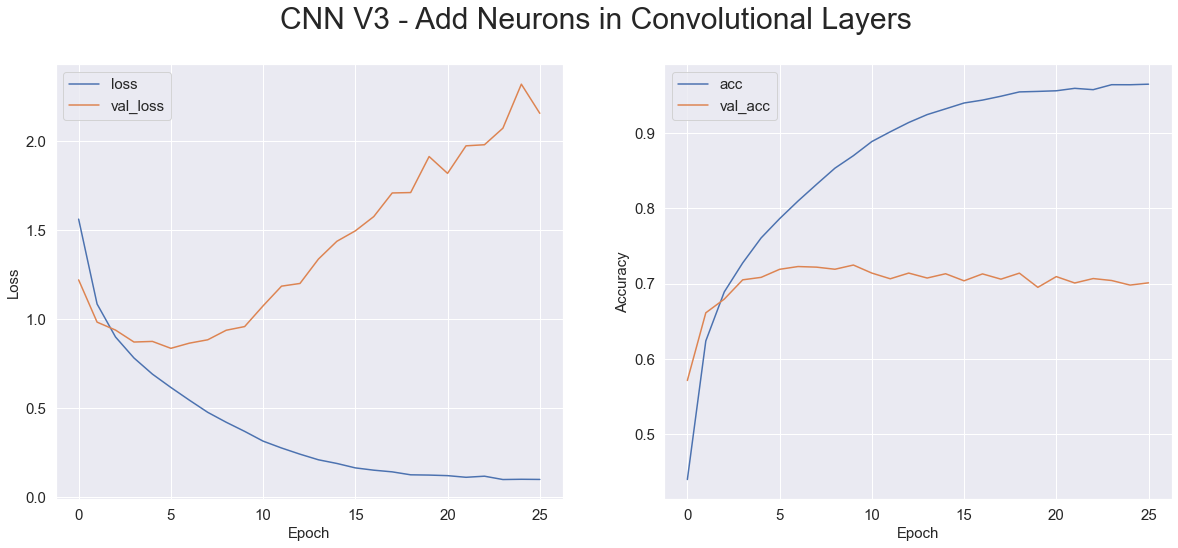

In [134]:
plot_loss_accraucy_graph(CNN_v3_history, "CNN V3 - Add Neurons in Convolutional Layers")

In [135]:
CNN_v3_predictions=eval_CNN_model(CNN_v3,"V3 - Add Neurons in Convolutional Layers")

313/313 [==============================] - 0s 858us/step
CNN V3 - Add Neurons in Convolutional Layers Training Data Accuracy: 97.2 %
CNN V3 - Add Neurons in Convolutional Layers Testing Data Accuracy: 70.1 %
CNN V3 - Add Neurons in Convolutional Layers F1-Score: 0.702


The accuracy on the testing dataset has increased by 2.33% from 67.77% to 70.1%. The f1-score has also increased by 0.023 from  0.679 to 0.702. Hence, there is an improvement in the performance of he model

However, the model is poor performing.It is overfitting as the loss is increasing greatly and the accuracy is not high. There is a high variance since there is a large difference between training & validation error.Based on the f1-score, the model is misclassifying many samples

### 5.3.3 Fine - Tuning Model: Add Convolutional Layers
According to the Occam Razors' theory, I would be increasing the number of convolutional layers to test if it would improve the performance of the model. Increasing the convolutional layers, would add complexity to the model. However, it would enable the model to extract more features. Hence, it may be able to generalize better on unseen data.

In [137]:
CNN_v4 = Sequential()
CNN_v4.add(Conv2D(64, (3, 3), activation='relu',padding='same', input_shape=(32, 32,1)))
CNN_v4.add(Conv2D(64, (3, 3), activation='relu',padding='same')) #new covolutional layer
CNN_v4.add(MaxPooling2D((2, 2)))

CNN_v4.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
CNN_v4.add(Conv2D(128, (3, 3), activation='relu',padding='same'))  #new covolutional layer
CNN_v4.add(MaxPooling2D((2, 2)))

CNN_v4.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
CNN_v4.add(Conv2D(256, (3, 3), activation='relu',padding='same'))  #new covolutional layer
CNN_v4.add(MaxPooling2D((2, 2)))

CNN_v4.add(Flatten())
CNN_v4.add(Dense(64, activation='relu'))
CNN_v4.add(Dense(10, activation='softmax'))
CNN_v4.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_123 (Conv2D)         (None, 32, 32, 64)        640       
                                                                 
 conv2d_124 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_125 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 conv2d_126 (Conv2D)         (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                

In [138]:
CNN_v4.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_v4_history = CNN_v4.fit(X_train,y_train, epochs=500, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/500
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6269 - accuracy: 0.4033 - val_loss: 1.1859 - val_accuracy: 0.5872
Epoch 2/500
1563/1563 [==============================] - 6s 4ms/step - loss: 1.0096 - accuracy: 0.6467 - val_loss: 0.9698 - val_accuracy: 0.6601
Epoch 3/500
1563/1563 [==============================] - 6s 4ms/step - loss: 0.7729 - accuracy: 0.7321 - val_loss: 0.8052 - val_accuracy: 0.7286
Epoch 4/500
1563/1563 [==============================] - 6s 4ms/step - loss: 0.6225 - accuracy: 0.7839 - val_loss: 0.7317 - val_accuracy: 0.7476
Epoch 5/500
1563/1563 [==============================] - 6s 4ms/step - loss: 0.5090 - accuracy: 0.8219 - val_loss: 0.8194 - val_accuracy: 0.7450
Epoch 6/500
1563/1563 [==============================] - 6s 4ms/step - loss: 0.4075 - accuracy: 0.8564 - val_loss: 0.7965 - val_accuracy: 0.7591
Epoch 7/500
1563/1563 [==============================] - 6s 4ms/step - loss: 0.3148 - accuracy: 0.8893 - val_loss: 0.8710 - val_ac

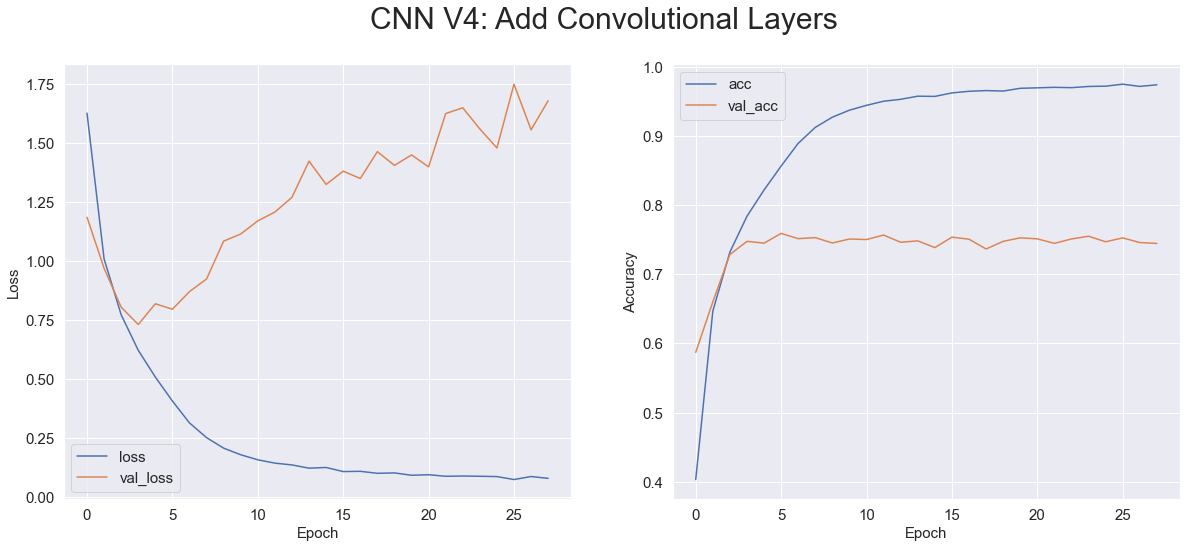

In [143]:
plot_loss_accraucy_graph(CNN_v4_history, "CNN V4: Add Convolutional Layers")

In [144]:
CNN_v4_predictions=eval_CNN_model(CNN_v4,"V4 - Add Convolutional Layers")

313/313 [==============================] - 0s 1ms/step
CNN V4 - Add Convolutional Layers Training Data Accuracy: 97.97 %
CNN V4 - Add Convolutional Layers Testing Data Accuracy: 74.46 %
CNN V4 - Add Convolutional Layers F1-Score: 0.748


The accuracy on the testing dataset has increased by 4.36% from 70.1% to 74.46%. The f1-score has also increased by 0.046 from 0.702 to 0.748. The loss has also reduce from more than 2 to around 1.6. The performance of the model has signitifcantly improved.

However, the model is poor performing.It is overfitting as the loss is increasing greatly and the accuracy is not high. There is a high variance since there is a large difference between training & validation error.Based on the f1-score, the model is misclassifying many samples

### 5.3.4 Fine - Tuning Model: Add Dropout Layers
As the model is still overfitting, I will be adding drop out layers. Dropout is an approach to regularization in neural networks. It works by randomly dropping out nodes during training. It helps to reduce overfitting and improve generalization.

In [159]:
CNN_v5 = Sequential()
CNN_v5.add(Conv2D(64, (3, 3), activation='relu',padding='same', input_shape=(32, 32,1)))
CNN_v5.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
CNN_v5.add(MaxPooling2D((2, 2)))
CNN_v5.add((Dropout(0.2))) #add dropout layer

CNN_v5.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
CNN_v5.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
CNN_v5.add(MaxPooling2D((2, 2))) 
CNN_v5.add((Dropout(0.2))) #add dropout layer

CNN_v5.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
CNN_v5.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
CNN_v5.add(MaxPooling2D((2, 2)))
CNN_v5.add((Dropout(0.2))) #add dropout layer

CNN_v5.add(Flatten())
CNN_v5.add(Dense(64, activation='relu'))
CNN_v5.add((Dropout(0.2))) #add dropout layer
CNN_v5.add(Dense(10, activation='softmax'))
CNN_v5.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_141 (Conv2D)         (None, 32, 32, 64)        640       
                                                                 
 conv2d_142 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_78 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 dropout_60 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_143 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 conv2d_144 (Conv2D)         (None, 16, 16, 128)       147584    
                                                     

In [160]:
CNN_v5.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_v5_history = CNN_v5.fit(X_train,y_train, epochs=500, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/500
1563/1563 [==============================] - 7s 4ms/step - loss: 1.9113 - accuracy: 0.2841 - val_loss: 1.5530 - val_accuracy: 0.4279
Epoch 2/500
1563/1563 [==============================] - 6s 4ms/step - loss: 1.4262 - accuracy: 0.4916 - val_loss: 1.1913 - val_accuracy: 0.5790
Epoch 3/500
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1920 - accuracy: 0.5826 - val_loss: 1.0052 - val_accuracy: 0.6421
Epoch 4/500
1563/1563 [==============================] - 6s 4ms/step - loss: 1.0327 - accuracy: 0.6426 - val_loss: 0.8958 - val_accuracy: 0.6877
Epoch 5/500
1563/1563 [==============================] - 6s 4ms/step - loss: 0.9343 - accuracy: 0.6779 - val_loss: 0.8326 - val_accuracy: 0.7162
Epoch 6/500
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8610 - accuracy: 0.7048 - val_loss: 0.7880 - val_accuracy: 0.7272
Epoch 7/500
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8055 - accuracy: 0.7220 - val_loss: 0.7769 - val_ac

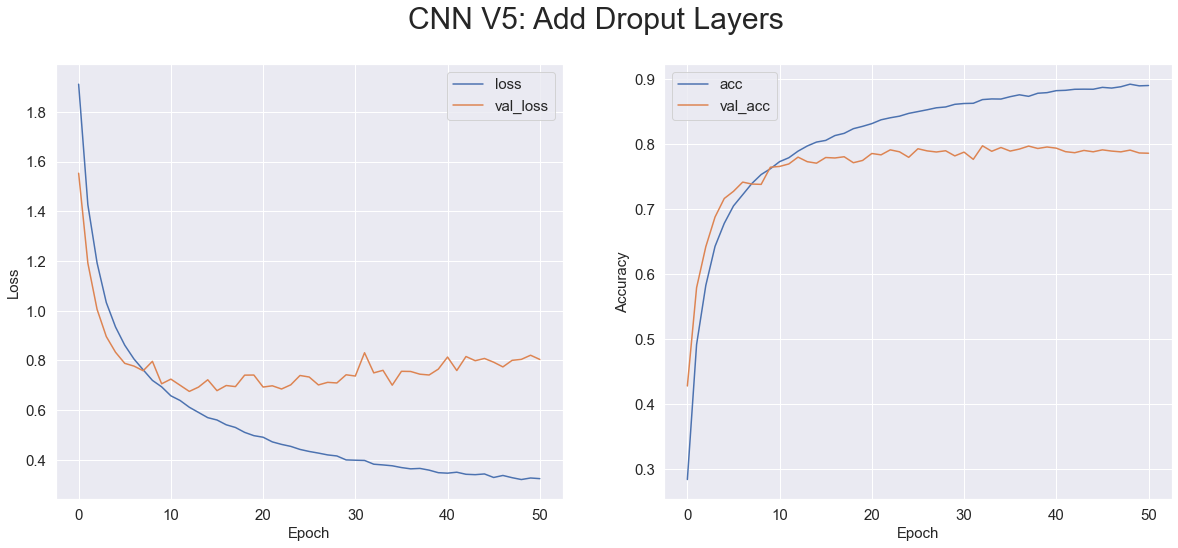

In [165]:
plot_loss_accraucy_graph(CNN_v5_history, "CNN V5: Add Droput Layers")

In [166]:
CNN_v5_predictions=eval_CNN_model(CNN_v5,"V5 - Add Droput Layers")

313/313 [==============================] - 0s 1ms/step
CNN V5 - Add Droput Layers Training Data Accuracy: 96.66 %
CNN V5 - Add Droput Layers Testing Data Accuracy: 78.58 %
CNN V5 - Add Droput Layers F1-Score: 0.787


The performance of the mdoel has significantly improved.The model is overfitting lesser and the variance has reduced. There is a smaller difference between the training & validation error. However, this can still be further improved.

The accuracy on the testing dataset has increased by 4.12% from 74.46% to 78.58%. The f1-score has also increased by 0.039 from 0.748 to 0.787. The loss has also reduce by half from around 1.6 to around 0.8. 

### 5.3.5 Fine - Tuning Model: Increase Dropout  = 0.3
Increasing the dropout, may further reduce overfitting

In [232]:
CNN_v6 = Sequential()
CNN_v6.add(Conv2D(64, (3, 3), activation='relu',padding='same', input_shape=(32, 32,1)))
CNN_v6.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
CNN_v6.add(MaxPooling2D((2, 2)))
CNN_v6.add((Dropout(0.3))) #increase dropot

CNN_v6.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
CNN_v6.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
CNN_v6.add(MaxPooling2D((2, 2))) 
CNN_v6.add((Dropout(0.3))) #increase dropot

CNN_v6.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
CNN_v6.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
CNN_v6.add(MaxPooling2D((2, 2)))
CNN_v6.add((Dropout(0.3))) #increase dropot

CNN_v6.add(Flatten())
CNN_v6.add(Dense(64, activation='relu'))
CNN_v6.add((Dropout(0.3)))
CNN_v6.add(Dense(10, activation='softmax'))
CNN_v6.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_231 (Conv2D)         (None, 32, 32, 64)        640       
                                                                 
 conv2d_232 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_123 (MaxPooli  (None, 16, 16, 64)       0         
 ng2D)                                                           
                                                                 
 dropout_120 (Dropout)       (None, 16, 16, 64)        0         
                                                                 
 conv2d_233 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 conv2d_234 (Conv2D)         (None, 16, 16, 128)       147584    
                                                     

In [177]:
CNN_v6.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_v6_history = CNN_v6.fit(X_train,y_train, epochs=500, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/500
1563/1563 [==============================] - 7s 4ms/step - loss: 1.9947 - accuracy: 0.2455 - val_loss: 1.5862 - val_accuracy: 0.4159
Epoch 2/500
1563/1563 [==============================] - 6s 4ms/step - loss: 1.5483 - accuracy: 0.4381 - val_loss: 1.2865 - val_accuracy: 0.5508
Epoch 3/500
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2948 - accuracy: 0.5415 - val_loss: 1.0781 - val_accuracy: 0.6167
Epoch 4/500
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1536 - accuracy: 0.5955 - val_loss: 1.0184 - val_accuracy: 0.6452
Epoch 5/500
1563/1563 [==============================] - 7s 4ms/step - loss: 1.0553 - accuracy: 0.6384 - val_loss: 0.8968 - val_accuracy: 0.6919
Epoch 6/500
1563/1563 [==============================] - 6s 4ms/step - loss: 0.9793 - accuracy: 0.6651 - val_loss: 0.8321 - val_accuracy: 0.7131
Epoch 7/500
1563/1563 [==============================] - 7s 4ms/step - loss: 0.9236 - accuracy: 0.6828 - val_loss: 0.7883 - val_ac

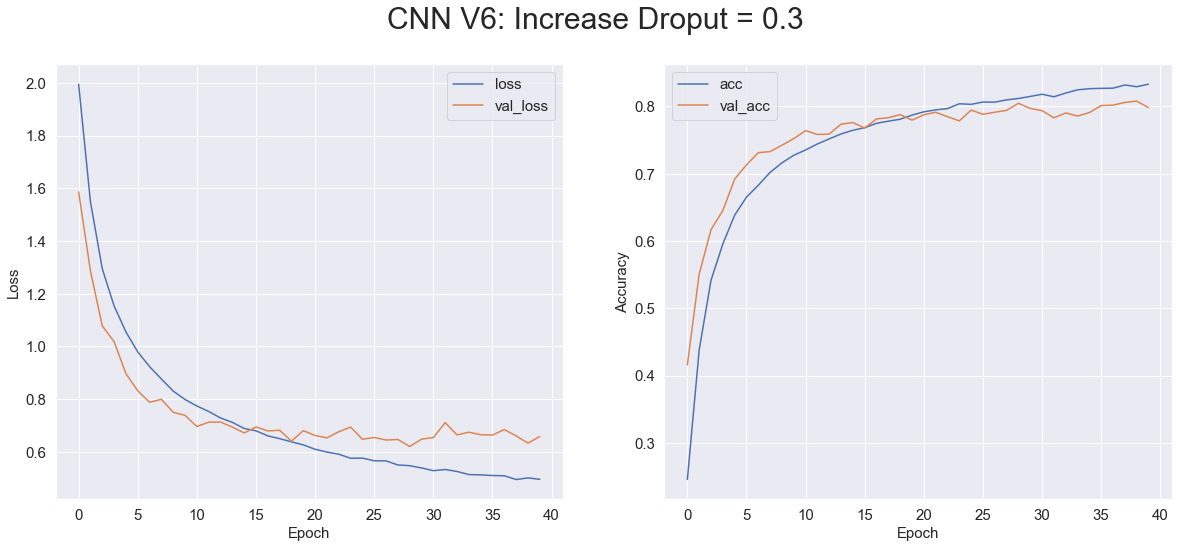

In [182]:
plot_loss_accraucy_graph(CNN_v6_history, "CNN V6: Increase Droput = 0.3")

In [191]:
CNN_v6_predictions=eval_CNN_model(CNN_v6,"V6: Increase Droput = 0.3")

313/313 [==============================] - 0s 1ms/step
CNN V6: Increase Droput = 0.3 Training Data Accuracy: 91.67 %
CNN V6: Increase Droput = 0.3 Testing Data Accuracy: 79.81 %
CNN V6: Increase Droput = 0.3 F1-Score: 0.797


The performance of the mdoel has improved slightly.The model is overfitting lesser and the variance has reduced. There is a smaller difference between the training & validation error. However, this can still be further improved.

The accuracy on the testing dataset has increased by 1.23% from 78.58% to 79.81%. The f1-score has also increased by 0.01 from 0.787 to 0.797. The loss has also reduce greatly from 0.8 to around 0.6 

### 5.3.6 Fine - Tuning Model: Data Augmentation
Data augmentation is a technique to artificially create new training data from existing training data. This is done by applying domain-specific techniques to examples from the training data that create new and different training examples that belong to the same class as the original image.

Transforms include a range of operations from the field of image manipulation, such as shifts, flips, zooms, and much more.

The intent is to expand the training dataset with new, plausible examples. This means, variations of the training set images that are likely to be seen by the model. This can help in reducing overfitting as it improve the ability of the fit models to generalize what they have learned to new images.

In [19]:
#define data augmentation
Data_Generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
augmented_train = Data_Generator.flow(X_train, y_train)

In [234]:
CNN_v6.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_v6_aug_history = CNN_v6.fit(augmented_train, epochs=500, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/500
1563/1563 [==============================] - 8s 5ms/step - loss: 1.9499 - accuracy: 0.2725 - val_loss: 1.6141 - val_accuracy: 0.4109
Epoch 2/500
1563/1563 [==============================] - 8s 5ms/step - loss: 1.5914 - accuracy: 0.4267 - val_loss: 1.3398 - val_accuracy: 0.5185
Epoch 3/500
1563/1563 [==============================] - 8s 5ms/step - loss: 1.4246 - accuracy: 0.4962 - val_loss: 1.1758 - val_accuracy: 0.5897
Epoch 4/500
1563/1563 [==============================] - 7s 5ms/step - loss: 1.3067 - accuracy: 0.5438 - val_loss: 1.1521 - val_accuracy: 0.6002
Epoch 5/500
1563/1563 [==============================] - 7s 5ms/step - loss: 1.2376 - accuracy: 0.5707 - val_loss: 1.0049 - val_accuracy: 0.6445
Epoch 6/500
1563/1563 [==============================] - 7s 5ms/step - loss: 1.1741 - accuracy: 0.5923 - val_loss: 1.0051 - val_accuracy: 0.6573
Epoch 7/500
1563/1563 [==============================] - 7s 5ms/step - loss: 1.1253 - accuracy: 0.6147 - val_loss: 0.9419 - val_ac

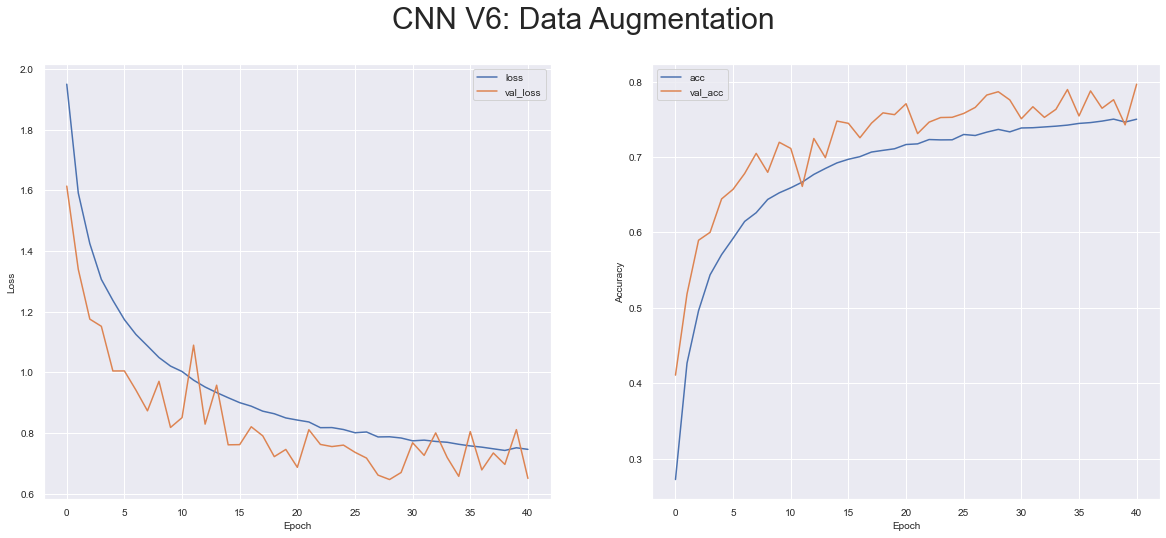

In [239]:
plot_loss_accraucy_graph(CNN_v6_aug_history, "CNN V6: Data Augmentation")

In [236]:
CNN_v6_predictions=eval_CNN_model(CNN_v6,"V6: Data Augmentation")

313/313 [==============================] - 0s 1ms/step
CNN V6: Data Augmentation Training Data Accuracy: 82.07 %
CNN V6: Data Augmentation Testing Data Accuracy: 79.66 %
CNN V6: Data Augmentation F1-Score: 0.793


The accuracy on the testing dataset has increased by 0.15% from 78.58% to 79.81%. The f1-score has also decreased by 0.001 from 0.797 to 0.793. The loss is showing many fluctuations.

After augmentation, the model is performing worse. However, based on theory, it should be performing better as the model has more data available for its traning. Hence, the issue could be that the model is not tuned enough to handle the additonal data.

### 5.3.7 Fine - Tuning Model: Batch Normalization
Batch normalization is a process to make neural networks faster and more stable through adding extra layers in a deep neural network. The new layer performs the standardizing and normalizing operations on the input of a layer coming from a previous layer. It also smoothens the loss function that in turn by optimizing the model parameters improves the training speed of the model.

In [17]:
CNN_v7 = Sequential()
CNN_v7.add(Conv2D(64, (3, 3), activation='relu',padding='same', input_shape=(32, 32,1)))
CNN_v7.add(BatchNormalization()) #add batch normalization layer
CNN_v7.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
CNN_v7.add(BatchNormalization()) #add batch normalization layer
CNN_v7.add(MaxPooling2D((2, 2)))
CNN_v7.add((Dropout(0.3)))

CNN_v7.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
CNN_v7.add(BatchNormalization()) #add batch normalization layer
CNN_v7.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
CNN_v7.add(BatchNormalization()) #add batch normalization layer
CNN_v7.add(MaxPooling2D((2, 2)))
CNN_v7.add((Dropout(0.3)))

CNN_v7.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
CNN_v7.add(BatchNormalization()) #add batch normalization layer
CNN_v7.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
CNN_v7.add(BatchNormalization()) #add batch normalization layer
CNN_v7.add(MaxPooling2D((2, 2)))
CNN_v7.add((Dropout(0.3)))

CNN_v7.add(Flatten())
CNN_v7.add(Dense(64, activation='relu'))
CNN_v7.add(BatchNormalization()) #add batch normalization layer
CNN_v7.add((Dropout(0.3)))
CNN_v7.add(Dense(10, activation='softmax'))
CNN_v7.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                        

In [22]:
CNN_v7.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_v7_aug_history = CNN_v7.fit(augmented_train, epochs=500, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/500
1563/1563 [==============================] - 21s 8ms/step - loss: 1.5450 - accuracy: 0.4594 - val_loss: 1.2031 - val_accuracy: 0.5944
Epoch 2/500
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0273 - accuracy: 0.6454 - val_loss: 0.8958 - val_accuracy: 0.6946
Epoch 3/500
1563/1563 [==============================] - 11s 7ms/step - loss: 0.8905 - accuracy: 0.6957 - val_loss: 0.8799 - val_accuracy: 0.7011
Epoch 4/500
1563/1563 [==============================] - 12s 8ms/step - loss: 0.8028 - accuracy: 0.7277 - val_loss: 0.7670 - val_accuracy: 0.7442
Epoch 5/500
1563/1563 [==============================] - 11s 7ms/step - loss: 0.7395 - accuracy: 0.7501 - val_loss: 0.6861 - val_accuracy: 0.7687
Epoch 6/500
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6846 - accuracy: 0.7686 - val_loss: 0.6559 - val_accuracy: 0.7832
Epoch 7/500
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6515 - accuracy: 0.7808 - val_loss: 0.6074 -

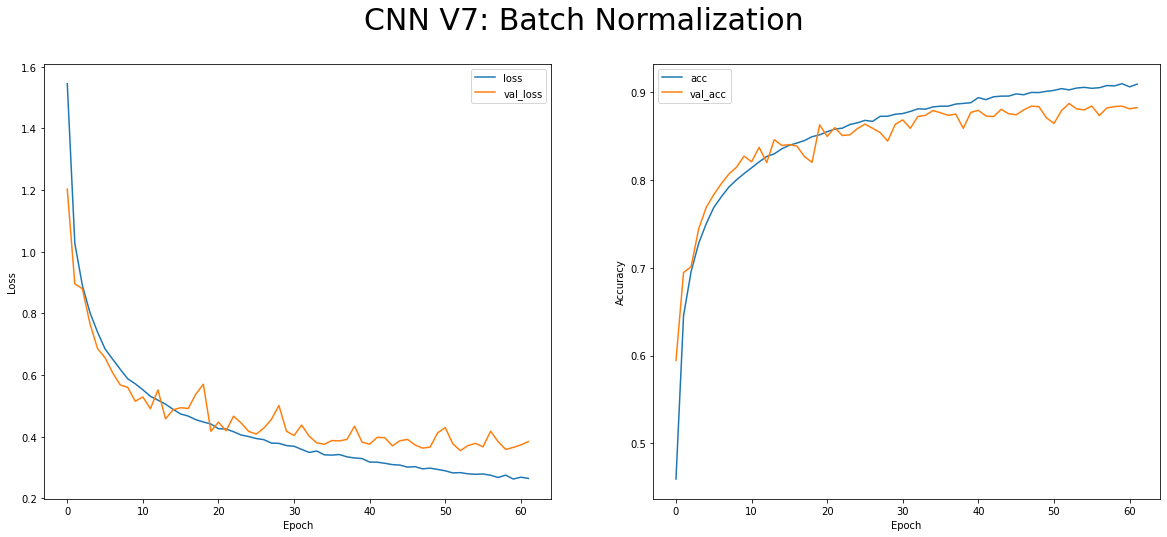

In [23]:
plot_loss_accraucy_graph(CNN_v7_aug_history, "CNN V7: Batch Normalization")

In [24]:
CNN_v7_predictions=eval_CNN_model(CNN_v7,"V7: Data Augmentation")

313/313 [==============================] - 1s 2ms/step
CNN V7: Data Augmentation Training Data Accuracy: 95.92 %
CNN V7: Data Augmentation Testing Data Accuracy: 88.23 %
CNN V7: Data Augmentation Testing Data F1-Score: 0.881


The performance of the mdoel has significantly improved.The model is overfitting lesser and the variance has reduced. There is a smaller difference between the training & validation error. However, this can still be further improved.

The accuracy on the testing dataset has increased greatly by 8.42% from 79.81% to 88.23%. The f1-score has also increased by 0.088 from 0.793 to 0.881. The loss is also more stable and has reduce to 0.4

### 5.3.8 Fine - Tuning Model: Increase Dropout in Layers Closer to Output
In the previous mode, the loss is still increasing towards the end of the epochs. This means that the model is overfitting. Hence, to reduce the variance, I will increase the dropout value in the layers closer to the output.

In [247]:
CNN_v8 = Sequential()
CNN_v8.add(Conv2D(64, (3, 3), activation='relu',padding='same', input_shape=(32, 32,1)))
CNN_v8.add(BatchNormalization())
CNN_v8.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
CNN_v8.add(BatchNormalization())
CNN_v8.add(MaxPooling2D((2, 2)))
CNN_v8.add((Dropout(0.3)))

CNN_v8.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
CNN_v8.add(BatchNormalization())
CNN_v8.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
CNN_v8.add(BatchNormalization())
CNN_v8.add(MaxPooling2D((2, 2)))
CNN_v8.add((Dropout(0.4))) #increase dropout

CNN_v8.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
CNN_v8.add(BatchNormalization())
CNN_v8.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
CNN_v8.add(BatchNormalization())
CNN_v8.add(MaxPooling2D((2, 2)))
CNN_v8.add((Dropout(0.3)))

CNN_v8.add(Flatten())
CNN_v8.add(Dense(64, activation='relu'))
CNN_v8.add(BatchNormalization())
CNN_v8.add((Dropout(0.5)))#increase dropout
CNN_v8.add(Dense(10, activation='softmax'))
CNN_v8.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_249 (Conv2D)         (None, 32, 32, 64)        640       
                                                                 
 batch_normalization_152 (Ba  (None, 32, 32, 64)       256       
 tchNormalization)                                               
                                                                 
 conv2d_250 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_153 (Ba  (None, 32, 32, 64)       256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_132 (MaxPooli  (None, 16, 16, 64)       0         
 ng2D)                                                           
                                                     

In [251]:
CNN_v8.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_v8_aug_history = CNN_v8.fit(augmented_train, epochs=500, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/500
1563/1563 [==============================] - 10s 6ms/step - loss: 1.6952 - accuracy: 0.4143 - val_loss: 1.3706 - val_accuracy: 0.5442
Epoch 2/500
1563/1563 [==============================] - 9s 6ms/step - loss: 1.1319 - accuracy: 0.6082 - val_loss: 1.0208 - val_accuracy: 0.6477
Epoch 3/500
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9645 - accuracy: 0.6720 - val_loss: 0.7789 - val_accuracy: 0.7326
Epoch 4/500
1563/1563 [==============================] - 9s 6ms/step - loss: 0.8607 - accuracy: 0.7110 - val_loss: 0.7226 - val_accuracy: 0.7575
Epoch 5/500
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7923 - accuracy: 0.7344 - val_loss: 0.7314 - val_accuracy: 0.7630
Epoch 6/500
1563/1563 [==============================] - 9s 5ms/step - loss: 0.7422 - accuracy: 0.7513 - val_loss: 0.6333 - val_accuracy: 0.7837
Epoch 7/500
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7048 - accuracy: 0.7646 - val_loss: 0.6537 - val_a

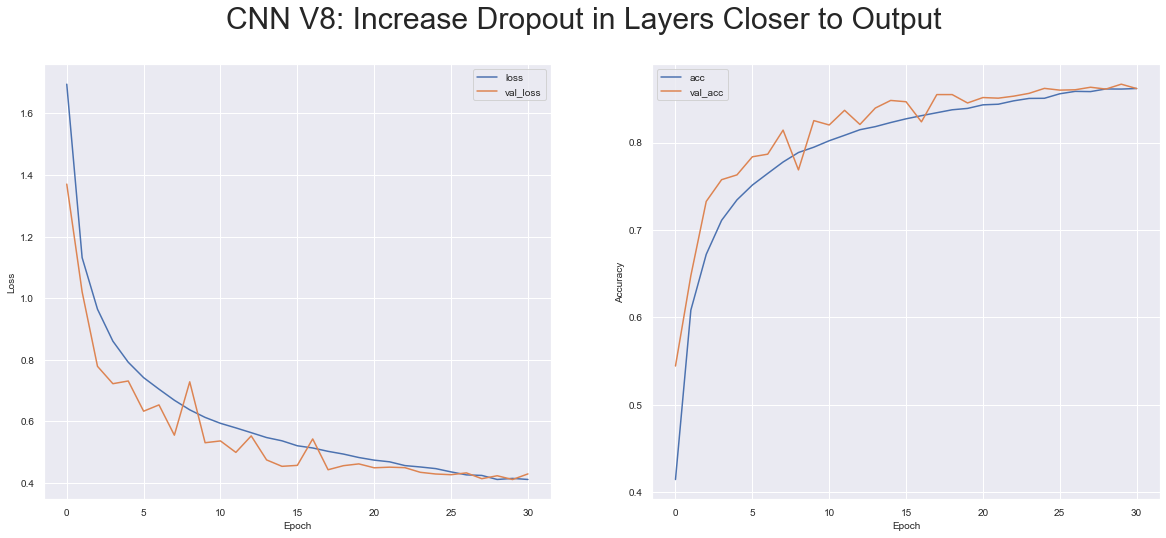

In [257]:
plot_loss_accraucy_graph(CNN_v8_aug_history, "CNN V8: Increase Dropout in Layers Closer to Output")

In [253]:
CNN_v8_predictions=eval_CNN_model(CNN_v8,"V8: Increase Dropout in Layers Closer to Output"")

313/313 [==============================] - 0s 1ms/step
CNN V8: Data Augmentation Training Data Accuracy: 91.05 %
CNN V8: Data Augmentation Testing Data Accuracy: 86.18 %
CNN V8: Data Augmentation F1-Score: 0.859


Based on the evaluation metrics, the performance of the model has deteriorated. However, the variance between the validation loss and training loss has reduced. Hence, I will continue to further tune the model to improve the performance using other parameters.

The accuracy on the testing dataset has decrease by 2.05% from 88.23% to 86.18%. The f1-score has also decreased by 0.022 from 0.881 to 0.859. 

However, the model is overfitting as seen in the accuracy graph

### 5.3.9 Fine - Tuning Model: Increase Neurons in Dense Layer
According to Occam Razors' theory, I would be doubling the number of neurons in the dense layer to test if it would improve the performance of the model.

#### 5.3.9.1 Fine - Tuning Model: Increase Neurons in Dense Layer to 128

In [259]:
CNN_v9 = Sequential()
CNN_v9.add(Conv2D(64, (3, 3), activation='relu',padding='same', input_shape=(32, 32,1)))
CNN_v9.add(BatchNormalization())
CNN_v9.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
CNN_v9.add(BatchNormalization())
CNN_v9.add(MaxPooling2D((2, 2)))
CNN_v9.add((Dropout(0.3)))

CNN_v9.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
CNN_v9.add(BatchNormalization())
CNN_v9.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
CNN_v9.add(BatchNormalization())
CNN_v9.add(MaxPooling2D((2, 2)))
CNN_v9.add((Dropout(0.4)))

CNN_v9.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
CNN_v9.add(BatchNormalization())
CNN_v9.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
CNN_v9.add(BatchNormalization())
CNN_v9.add(MaxPooling2D((2, 2)))
CNN_v9.add((Dropout(0.3)))

CNN_v9.add(Flatten())
CNN_v9.add(Dense(128, activation='relu')) #double neurons
CNN_v9.add(BatchNormalization())
CNN_v9.add((Dropout(0.5)))
CNN_v9.add(Dense(10, activation='softmax'))
CNN_v9.summary()

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_273 (Conv2D)         (None, 32, 32, 64)        640       
                                                                 
 batch_normalization_180 (Ba  (None, 32, 32, 64)       256       
 tchNormalization)                                               
                                                                 
 conv2d_274 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_181 (Ba  (None, 32, 32, 64)       256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_144 (MaxPooli  (None, 16, 16, 64)       0         
 ng2D)                                                           
                                                     

In [260]:
CNN_v9.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_v9_aug_history = CNN_v9.fit(augmented_train, epochs=500, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/500
1563/1563 [==============================] - 9s 6ms/step - loss: 1.6345 - accuracy: 0.4375 - val_loss: 1.3540 - val_accuracy: 0.5603
Epoch 2/500
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1058 - accuracy: 0.6174 - val_loss: 1.9418 - val_accuracy: 0.4116
Epoch 3/500
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9405 - accuracy: 0.6788 - val_loss: 1.1978 - val_accuracy: 0.5969
Epoch 4/500
1563/1563 [==============================] - 8s 5ms/step - loss: 0.8395 - accuracy: 0.7158 - val_loss: 0.7209 - val_accuracy: 0.7605
Epoch 5/500
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7734 - accuracy: 0.7367 - val_loss: 0.6478 - val_accuracy: 0.7773
Epoch 6/500
1563/1563 [==============================] - 8s 5ms/step - loss: 0.7260 - accuracy: 0.7562 - val_loss: 1.1593 - val_accuracy: 0.7319
Epoch 7/500
1563/1563 [==============================] - 8s 5ms/step - loss: 0.6841 - accuracy: 0.7697 - val_loss: 0.6070 - val_ac

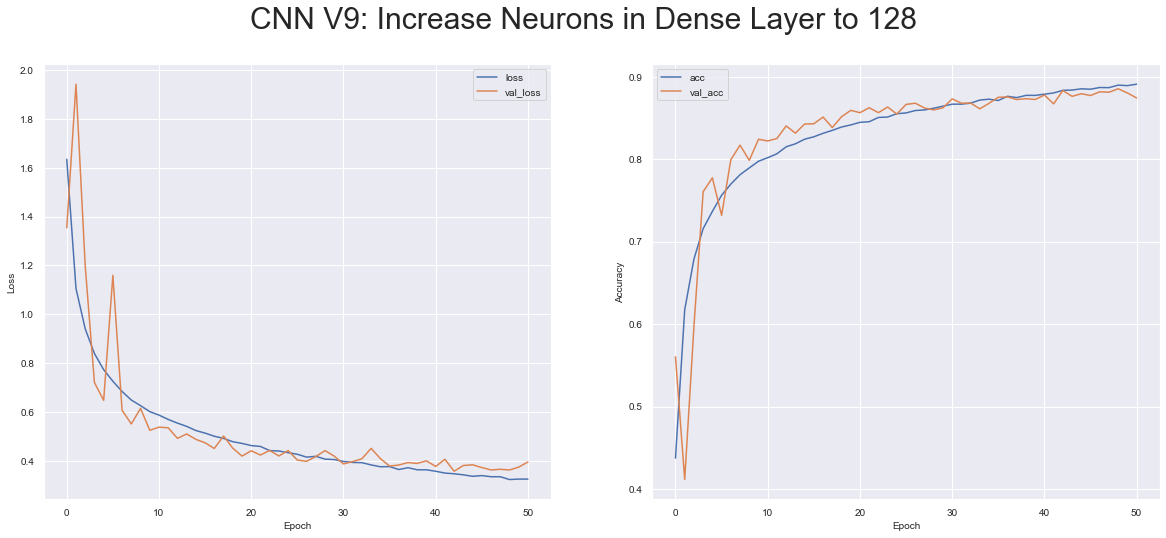

In [277]:
plot_loss_accraucy_graph(CNN_v9_aug_history, "CNN V9: Increase Neurons in Dense Layer to 128")

In [270]:
CNN_v9_predictions=eval_CNN_model(CNN_v9,"V9: Increase Neurons in Dense Layer to 128")

313/313 [==============================] - 0s 1ms/step
CNN V9: Increase Neurons in Dense Layer to 128 Training Data Accuracy: 94.32 %
CNN V9: Increase Neurons in Dense Layer to 128 Testing Data Accuracy: 87.41 %
CNN V9: Increase Neurons in Dense Layer to 128 F1-Score: 0.873


The performance of the mdoel has improved.The model is overfitting lesser but the variance has increased slightly as the loss is increasing towards the end of the epochs.There is a larger difference between the training & validation error. However, this can still be further improved.

The accuracy on the testing dataset has increased greatly by 1.23% from 86.18% to 87.41%. The f1-score has also increased by 0.014 from 0.859 to 0.873. The loss has reduced to around 0.4

#### 5.3.9.2 Fine - Tuning Model: Increase Neurons in Dense Layer to 256
According to the Occam Razors' theory, I would be further doubling the number of neurons in the dense layer to 256 to test if the performance would further improve

In [264]:
CNN_v10 = Sequential()
CNN_v10.add(Conv2D(64, (3, 3), activation='relu',padding='same', input_shape=(32, 32,1)))
CNN_v10.add(BatchNormalization())
CNN_v10.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
CNN_v10.add(BatchNormalization())
CNN_v10.add(MaxPooling2D((2, 2)))
CNN_v10.add((Dropout(0.3)))

CNN_v10.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
CNN_v10.add(BatchNormalization())
CNN_v10.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
CNN_v10.add(BatchNormalization())
CNN_v10.add(MaxPooling2D((2, 2)))
CNN_v10.add((Dropout(0.4)))

CNN_v10.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
CNN_v10.add(BatchNormalization())
CNN_v10.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
CNN_v10.add(BatchNormalization())
CNN_v10.add(MaxPooling2D((2, 2)))
CNN_v10.add((Dropout(0.3)))

CNN_v10.add(Flatten())
CNN_v10.add(Dense(256, activation='relu')) #double neurons
CNN_v10.add(BatchNormalization())
CNN_v10.add((Dropout(0.5)))
CNN_v10.add(Dense(10, activation='softmax'))
CNN_v10.summary()

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_279 (Conv2D)         (None, 32, 32, 64)        640       
                                                                 
 batch_normalization_187 (Ba  (None, 32, 32, 64)       256       
 tchNormalization)                                               
                                                                 
 conv2d_280 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_188 (Ba  (None, 32, 32, 64)       256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_147 (MaxPooli  (None, 16, 16, 64)       0         
 ng2D)                                                           
                                                     

In [265]:
CNN_v10.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_v10_aug_history = CNN_v10.fit(augmented_train, epochs=500, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/500
1563/1563 [==============================] - 8s 5ms/step - loss: 1.6618 - accuracy: 0.4369 - val_loss: 1.3157 - val_accuracy: 0.5362
Epoch 2/500
1563/1563 [==============================] - 7s 5ms/step - loss: 1.0997 - accuracy: 0.6175 - val_loss: 1.0047 - val_accuracy: 0.6609
Epoch 3/500
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9491 - accuracy: 0.6726 - val_loss: 0.8905 - val_accuracy: 0.7027
Epoch 4/500
1563/1563 [==============================] - 8s 5ms/step - loss: 0.8596 - accuracy: 0.7059 - val_loss: 0.8839 - val_accuracy: 0.7044
Epoch 5/500
1563/1563 [==============================] - 8s 5ms/step - loss: 0.7847 - accuracy: 0.7339 - val_loss: 0.8183 - val_accuracy: 0.7312
Epoch 6/500
1563/1563 [==============================] - 7s 5ms/step - loss: 0.7362 - accuracy: 0.7503 - val_loss: 0.7189 - val_accuracy: 0.7660
Epoch 7/500
1563/1563 [==============================] - 7s 5ms/step - loss: 0.6951 - accuracy: 0.7642 - val_loss: 0.7589 - val_ac

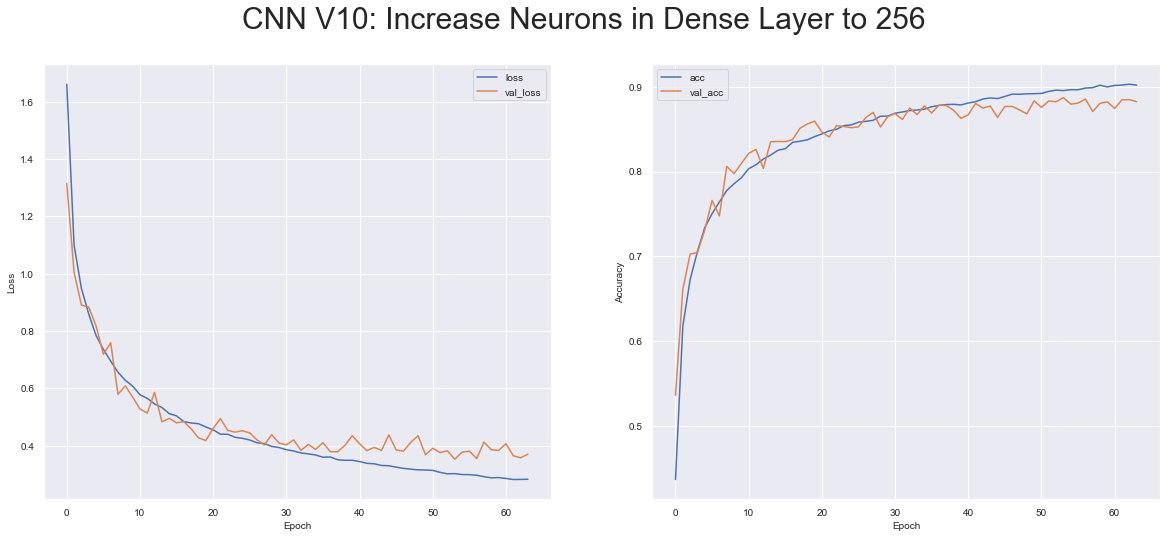

In [275]:
plot_loss_accraucy_graph(CNN_v10_aug_history, "CNN V10: Increase Neurons in Dense Layer to 256")

In [267]:
CNN_v10_predictions=eval_CNN_model(CNN_v10,"V10: Increase Neurons in Dense Layer to 256 ")

313/313 [==============================] - 0s 1ms/step
CNN V10: Increase Neurons in Dense Layer Training Data Accuracy: 95.96 %
CNN V10: Increase Neurons in Dense Layer Testing Data Accuracy: 88.23 %
CNN V10: Increase Neurons in Dense Layer F1-Score: 0.881


The model is overfitting slighly more and the variance has increased.There is a larger difference between the training & validation error as the loss is increasing towards the end of the epochs. However, this can still be further improved.

However, the accuracy on the testing dataset has increased by 0.82% from 87.41% to 88.23%. The f1-score has also increased by 0.008 from 0.873 to 0.881. The loss has reduced to around 0.4

### 5.3.10 Fine - Tuning Model: Batch Size 
Batch size is the number of examples from the training dataset used in the estimate of the error gradient.
At the end of the batch, the predictions are compared to the expected output variables and an error is calculated. From this error, the update algorithm is used to improve the model. Hence, the batch size would be able to improve the performance of the model

#### 5.3.10.1 Fine - Tuning Model: Batch Size = 32

In [280]:
augmented_train_batchsize_32 = Data_Generator.flow(X_train, y_train,batch_size=32)
CNN_v10.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_v10_aug_history_batchsize_32 = CNN_v10.fit(augmented_train_batchsize_32, epochs=500, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/500
1563/1563 [==============================] - 8s 5ms/step - loss: 1.6954 - accuracy: 0.4238 - val_loss: 1.1819 - val_accuracy: 0.5868
Epoch 2/500
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1176 - accuracy: 0.6120 - val_loss: 1.1964 - val_accuracy: 0.5957
Epoch 3/500
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9489 - accuracy: 0.6729 - val_loss: 1.5577 - val_accuracy: 0.5400
Epoch 4/500
1563/1563 [==============================] - 7s 5ms/step - loss: 0.8467 - accuracy: 0.7091 - val_loss: 0.7865 - val_accuracy: 0.7296
Epoch 5/500
1563/1563 [==============================] - 8s 5ms/step - loss: 0.7790 - accuracy: 0.7355 - val_loss: 0.8173 - val_accuracy: 0.7230
Epoch 6/500
1563/1563 [==============================] - 8s 5ms/step - loss: 0.7361 - accuracy: 0.7493 - val_loss: 0.6459 - val_accuracy: 0.7863
Epoch 7/500
1563/1563 [==============================] - 7s 5ms/step - loss: 0.6881 - accuracy: 0.7675 - val_loss: 0.6010 - val_ac

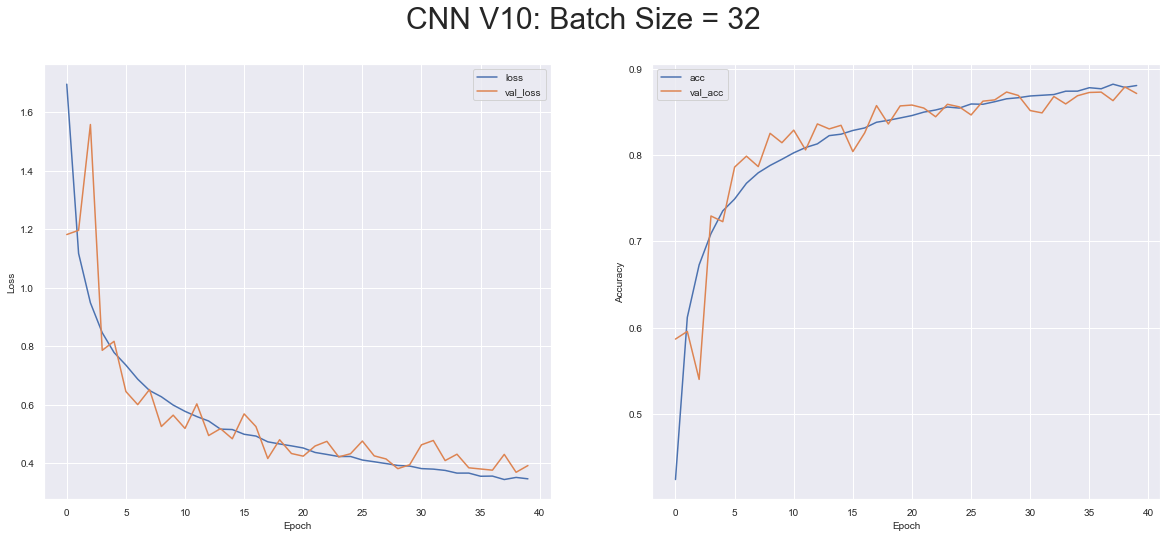

In [281]:
plot_loss_accraucy_graph(CNN_v10_aug_history_batchsize_32, "CNN V10: Batch Size = 32")

In [282]:
CNN_v10_predictions_batchsize_32=eval_CNN_model(CNN_v10,"V10: Batch Size = 32")

313/313 [==============================] - 1s 1ms/step
CNN V10: Batch Size = 32 Training Data Accuracy: 93.77 %
CNN V10: Batch Size = 32 Testing Data Accuracy: 87.17 %
CNN V10: Batch Size = 32 F1-Score: 0.87


#### 5.3.10.2 Fine - Tuning Model: Batch Size = 64

In [285]:
augmented_train_batchsize_64 = Data_Generator.flow(X_train, y_train,batch_size=64)
CNN_v10.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_v10_aug_history_batchsize_64 = CNN_v10.fit(augmented_train_batchsize_64, epochs=500, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/500
782/782 [==============================] - 7s 9ms/step - loss: 1.6932 - accuracy: 0.4308 - val_loss: 1.3585 - val_accuracy: 0.5561
Epoch 2/500
782/782 [==============================] - 6s 8ms/step - loss: 1.0916 - accuracy: 0.6160 - val_loss: 1.2110 - val_accuracy: 0.5966
Epoch 3/500
782/782 [==============================] - 6s 8ms/step - loss: 0.9291 - accuracy: 0.6788 - val_loss: 0.8387 - val_accuracy: 0.7219
Epoch 4/500
782/782 [==============================] - 6s 8ms/step - loss: 0.8254 - accuracy: 0.7146 - val_loss: 0.9541 - val_accuracy: 0.7001
Epoch 5/500
782/782 [==============================] - 7s 8ms/step - loss: 0.7667 - accuracy: 0.7349 - val_loss: 0.6647 - val_accuracy: 0.7758
Epoch 6/500
782/782 [==============================] - 7s 9ms/step - loss: 0.7066 - accuracy: 0.7594 - val_loss: 0.7029 - val_accuracy: 0.7675
Epoch 7/500
782/782 [==============================] - 6s 8ms/step - loss: 0.6706 - accuracy: 0.7723 - val_loss: 0.6080 - val_accuracy: 0.7931

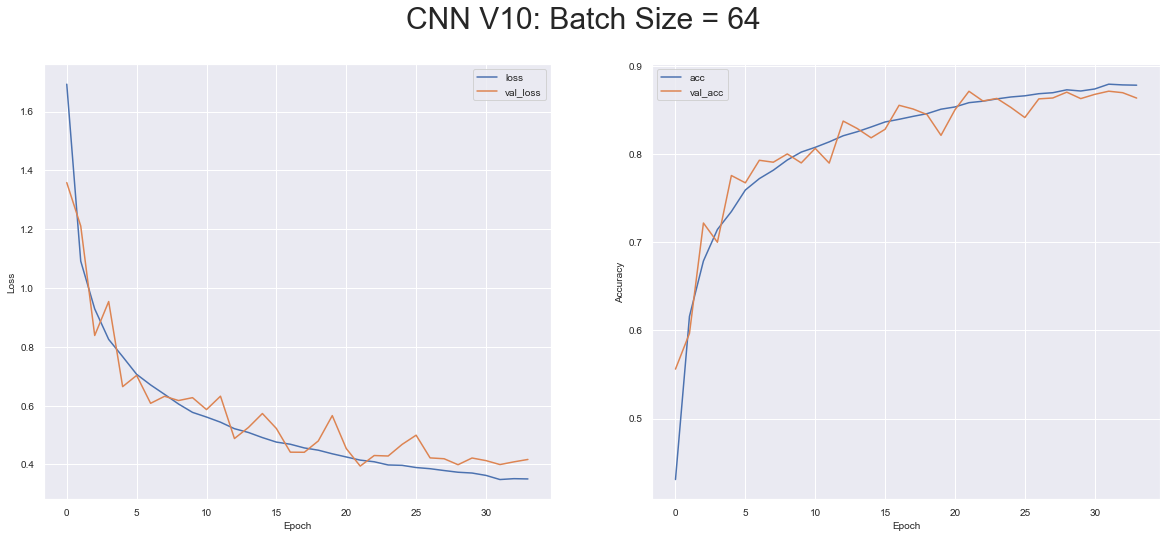

In [286]:
plot_loss_accraucy_graph(CNN_v10_aug_history_batchsize_64, "CNN V10: Batch Size = 64")

In [287]:
CNN_v10_predictions_batchsize_64=eval_CNN_model(CNN_v10,"V10: Batch Size = 64")

313/313 [==============================] - 1s 1ms/step
CNN V10: Batch Size = 64 Training Data Accuracy: 92.28 %
CNN V10: Batch Size = 64 Testing Data Accuracy: 86.37 %
CNN V10: Batch Size = 64 F1-Score: 0.863


#### 5.3.10.3 Fine - Tuning Model: Batch Size = 128

In [25]:
augmented_train_batchsize_128 = Data_Generator.flow(X_train, y_train,batch_size=128)

In [14]:
augmented_train_batchsize_128 = Data_Generator.flow(X_train, y_train,batch_size=128)
CNN_v10.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_v10_aug_history_batchsize_128 = CNN_v10.fit(augmented_train_batchsize_128, epochs=500, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/500
391/391 [==============================] - 13s 16ms/step - loss: 1.8506 - accuracy: 0.3833 - val_loss: 3.5843 - val_accuracy: 0.1752
Epoch 2/500
391/391 [==============================] - 6s 15ms/step - loss: 1.1571 - accuracy: 0.5943 - val_loss: 1.1407 - val_accuracy: 0.6175
Epoch 3/500
391/391 [==============================] - 6s 15ms/step - loss: 0.9642 - accuracy: 0.6651 - val_loss: 0.9450 - val_accuracy: 0.6814
Epoch 4/500
391/391 [==============================] - 6s 14ms/step - loss: 0.8570 - accuracy: 0.7022 - val_loss: 1.4281 - val_accuracy: 0.5746
Epoch 5/500
391/391 [==============================] - 6s 14ms/step - loss: 0.7852 - accuracy: 0.7288 - val_loss: 0.6841 - val_accuracy: 0.7702
Epoch 6/500
391/391 [==============================] - 6s 14ms/step - loss: 0.7230 - accuracy: 0.7503 - val_loss: 0.7854 - val_accuracy: 0.7505
Epoch 7/500
391/391 [==============================] - 6s 14ms/step - loss: 0.6817 - accuracy: 0.7641 - val_loss: 0.6636 - val_accuracy

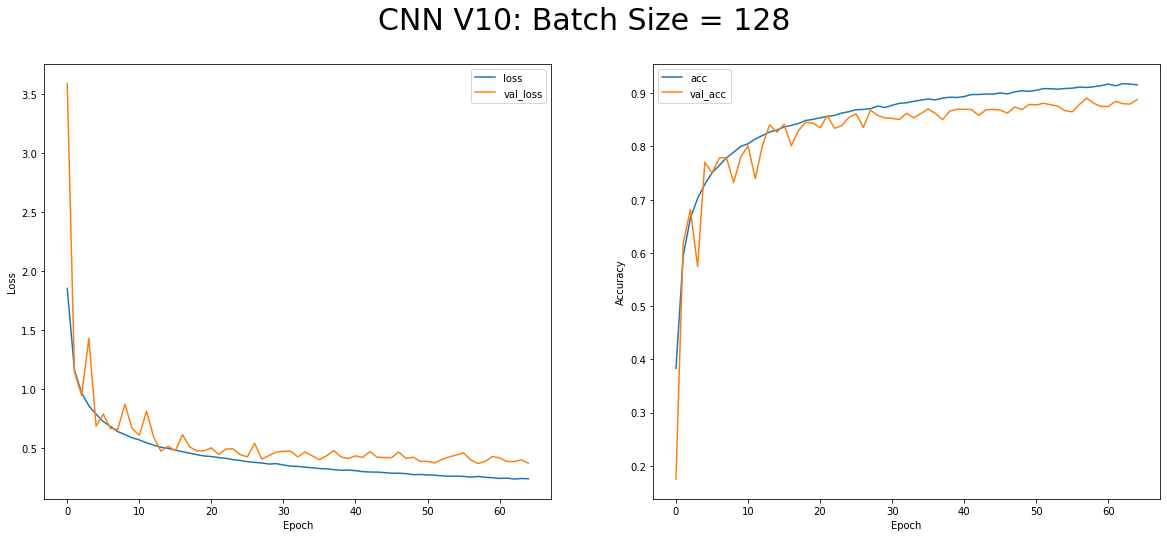

In [15]:
plot_loss_accraucy_graph(CNN_v10_aug_history_batchsize_128, "CNN V10: Batch Size = 128")

In [16]:
CNN_v10_predictions_batchsize_128=eval_CNN_model(CNN_v10,"V10: Batch Size = 128")

313/313 [==============================] - 1s 1ms/step
CNN V10: Batch Size = 128 Training Data Accuracy: 96.61 %
CNN V10: Batch Size = 128 Testing Data Accuracy: 88.81 %
CNN V10: Batch Size = 128 F1-Score: 0.887


####  Model Summary - Batch Size

<table>
    <th> Batch Size </th>
    <th> Test Accuracy </th> 
    <th> Test F1-Score </th>
    <th> Train Loss vs Validation Loss </th>
    <tr>
        <td> 32 </td>
        <td> 87.17% </td>
        <td> 0.87 </td>
        <td> Increasing towards the end of the epochs and fluctuating grealty </td>
    </tr>
        <tr>
        <td> 64 </td>
        <td> 86.37% </td>
        <td> 0.863 </td>
        <td> Increasing towards the end of the epochs and fluctuating grealty </td>
    </tr>
       <tr>
        <td> 128 </td>
        <td> 88.81% </td>
        <td> 0.887 </td>
        <td> Increasing towards the end of the epochs and stable</td>
    </tr>
    </table>
   
  I ran 3 different batch sizes (32,64,128) and the results are as shown in the table above. The best performing model was with the batch size of 128. The loss graph is more stable although the loss is higher compared to the other 2 batch sizes. The performance of the model is also slighlty better as the accuracy on the testing dataset has increased by 0.58% from 88.23% to 88.81%. The f1-score has also increased by 0.006 from 0.881 to 0.887.
  
 Therefore, the final batch size used is 128

    


### 5.3.11 Fine - Tuning Model: Optimizer 

#### 5.3.11.1  Fine - Tuning Model: Optimizer = Adamax 

In [297]:
CNN_v10.compile(optimizer="Adamax", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_v10_aug_history_Adamax = CNN_v10.fit(augmented_train_batchsize_128, epochs=500, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/500
391/391 [==============================] - 6s 15ms/step - loss: 2.0943 - accuracy: 0.3338 - val_loss: 3.7142 - val_accuracy: 0.1934
Epoch 2/500
391/391 [==============================] - 6s 15ms/step - loss: 1.5321 - accuracy: 0.4725 - val_loss: 1.3126 - val_accuracy: 0.5556
Epoch 3/500
391/391 [==============================] - 6s 15ms/step - loss: 1.2449 - accuracy: 0.5650 - val_loss: 1.4008 - val_accuracy: 0.5685
Epoch 4/500
391/391 [==============================] - 6s 15ms/step - loss: 1.0901 - accuracy: 0.6193 - val_loss: 1.0502 - val_accuracy: 0.6518
Epoch 5/500
391/391 [==============================] - 6s 15ms/step - loss: 0.9792 - accuracy: 0.6589 - val_loss: 0.9312 - val_accuracy: 0.6831
Epoch 6/500
391/391 [==============================] - 6s 15ms/step - loss: 0.9109 - accuracy: 0.6827 - val_loss: 0.9087 - val_accuracy: 0.6951
Epoch 7/500
391/391 [==============================] - 6s 14ms/step - loss: 0.8455 - accuracy: 0.7083 - val_loss: 0.8325 - val_accuracy:

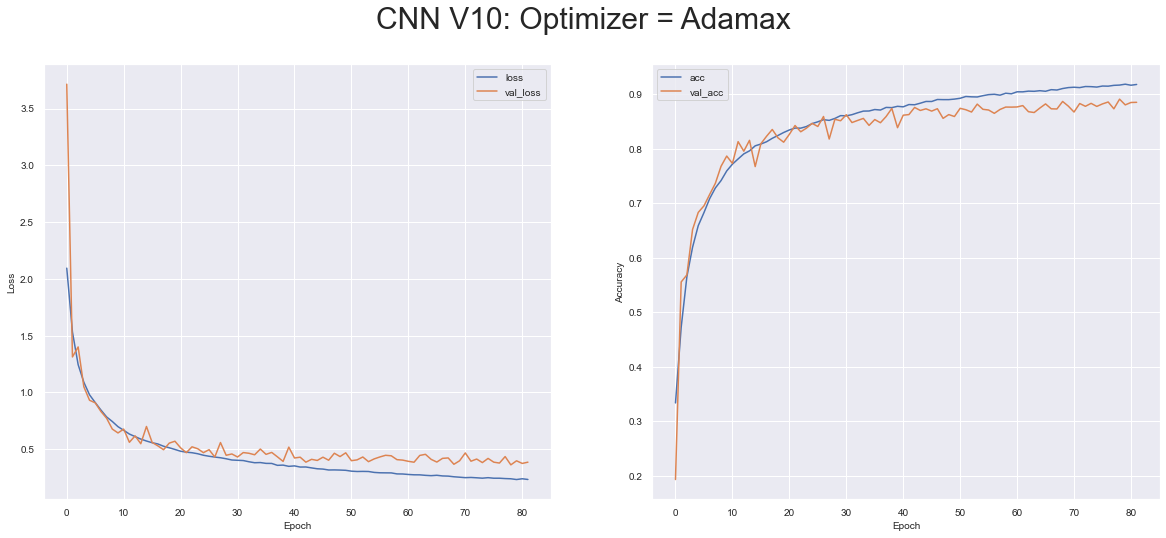

In [298]:
plot_loss_accraucy_graph(CNN_v10_aug_history_Adamax, "CNN V10: Optimizer = Adamax")

In [299]:
CNN_v10_predictions_Adamax=eval_CNN_model(CNN_v10,"V10: Optimzer = Adamax")

313/313 [==============================] - 0s 1ms/step
CNN V10: Optimzer = Adamax Training Data Accuracy: 96.52 %
CNN V10: Optimzer = Adamax Testing Data Accuracy: 88.49 %
CNN V10: Optimzer = Adamax F1-Score: 0.885


#### 5.3.11.2  Fine - Tuning Model: Optimizer = SGD

In [301]:
CNN_v10.compile(optimizer="SGD", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_v10_aug_history_SGD = CNN_v10.fit(augmented_train_batchsize_128, epochs=500, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/500
391/391 [==============================] - 6s 15ms/step - loss: 2.4058 - accuracy: 0.2634 - val_loss: 3.4182 - val_accuracy: 0.1078
Epoch 2/500
391/391 [==============================] - 6s 15ms/step - loss: 1.7981 - accuracy: 0.3731 - val_loss: 1.7772 - val_accuracy: 0.3859
Epoch 3/500
391/391 [==============================] - 6s 16ms/step - loss: 1.5919 - accuracy: 0.4335 - val_loss: 2.3243 - val_accuracy: 0.2813
Epoch 4/500
391/391 [==============================] - 6s 15ms/step - loss: 1.4541 - accuracy: 0.4805 - val_loss: 1.9923 - val_accuracy: 0.3743
Epoch 5/500
391/391 [==============================] - 6s 16ms/step - loss: 1.3497 - accuracy: 0.5189 - val_loss: 2.0623 - val_accuracy: 0.3707
Epoch 6/500
391/391 [==============================] - 6s 16ms/step - loss: 1.2826 - accuracy: 0.5447 - val_loss: 1.9295 - val_accuracy: 0.3995
Epoch 7/500
391/391 [==============================] - 6s 16ms/step - loss: 1.2274 - accuracy: 0.5663 - val_loss: 1.3765 - val_accuracy:

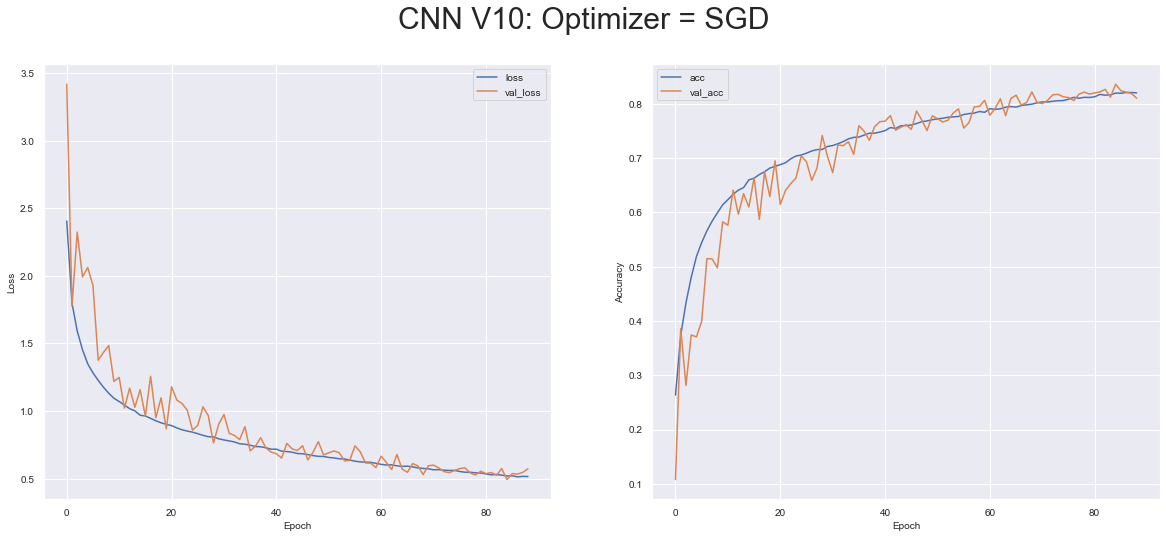

In [302]:
plot_loss_accraucy_graph(CNN_v10_aug_history_SGD, "CNN V10: Optimizer = SGD")

In [303]:
CNN_v10_predictions_SGD=eval_CNN_model(CNN_v10,"V10: Optimizer = SGD")

313/313 [==============================] - 0s 1ms/step
CNN V10: Optimizer = SGD Training Data Accuracy: 84.35 %
CNN V10: Optimizer = SGD Testing Data Accuracy: 81.06 %
CNN V10: Optimizer = SGD F1-Score: 0.811


#### 5.3.11.3  Fine - Tuning Model: Optimizer = RMSprop

In [305]:
CNN_v10.compile(optimizer="RMSprop", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_v10_aug_history_RMSprop = CNN_v10.fit(augmented_train_batchsize_128, epochs=500, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/500
391/391 [==============================] - 7s 15ms/step - loss: 1.7717 - accuracy: 0.4240 - val_loss: 2.9876 - val_accuracy: 0.1990
Epoch 2/500
391/391 [==============================] - 6s 14ms/step - loss: 1.0372 - accuracy: 0.6416 - val_loss: 0.9512 - val_accuracy: 0.6760
Epoch 3/500
391/391 [==============================] - 6s 14ms/step - loss: 0.8542 - accuracy: 0.7041 - val_loss: 1.1673 - val_accuracy: 0.6552
Epoch 4/500
391/391 [==============================] - 6s 14ms/step - loss: 0.7605 - accuracy: 0.7363 - val_loss: 0.7180 - val_accuracy: 0.7583
Epoch 5/500
391/391 [==============================] - 5s 14ms/step - loss: 0.7044 - accuracy: 0.7590 - val_loss: 0.7352 - val_accuracy: 0.7617
Epoch 6/500
391/391 [==============================] - 6s 14ms/step - loss: 0.6602 - accuracy: 0.7731 - val_loss: 0.9552 - val_accuracy: 0.7052
Epoch 7/500
391/391 [==============================] - 5s 14ms/step - loss: 0.6198 - accuracy: 0.7884 - val_loss: 0.6649 - val_accuracy:

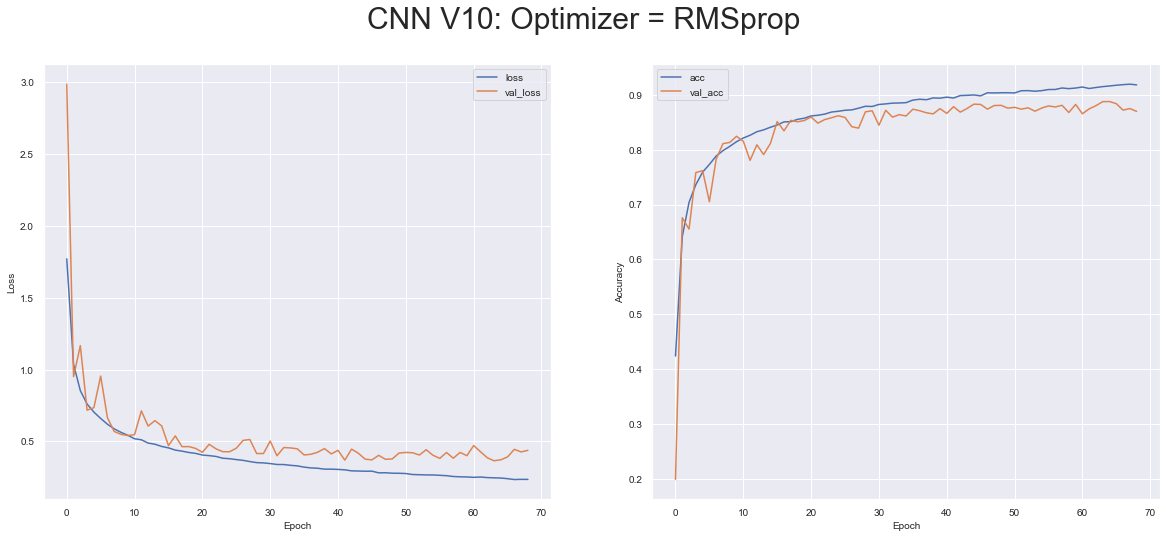

In [306]:
plot_loss_accraucy_graph(CNN_v10_aug_history_RMSprop, "CNN V10: Optimizer = RMSprop")

In [307]:
CNN_v10_predictions_RMSprop=eval_CNN_model(CNN_v10,"V10: Optimizer = RMSprop")

313/313 [==============================] - 0s 1ms/step
CNN V10: Optimizer = RMSprop Training Data Accuracy: 94.95 %
CNN V10: Optimizer = RMSprop Testing Data Accuracy: 86.97 %
CNN V10: Optimizer = RMSprop F1-Score: 0.87


#### 5.3.11.4  Fine - Tuning Model: Optimizer = Adadelta

In [309]:
CNN_v10.compile(optimizer="Adadelta", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_v10_aug_history_Adadelta = CNN_v10.fit(augmented_train_batchsize_128, epochs=500, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/500
391/391 [==============================] - 6s 14ms/step - loss: 3.6042 - accuracy: 0.1039 - val_loss: 2.7867 - val_accuracy: 0.1008
Epoch 2/500
391/391 [==============================] - 6s 14ms/step - loss: 3.4415 - accuracy: 0.1200 - val_loss: 2.4206 - val_accuracy: 0.1539
Epoch 3/500
391/391 [==============================] - 6s 14ms/step - loss: 3.3565 - accuracy: 0.1326 - val_loss: 2.3285 - val_accuracy: 0.1838
Epoch 4/500
391/391 [==============================] - 6s 14ms/step - loss: 3.2846 - accuracy: 0.1444 - val_loss: 2.2884 - val_accuracy: 0.2008
Epoch 5/500
391/391 [==============================] - 6s 14ms/step - loss: 3.2231 - accuracy: 0.1522 - val_loss: 2.2559 - val_accuracy: 0.2133
Epoch 6/500
391/391 [==============================] - 6s 14ms/step - loss: 3.1784 - accuracy: 0.1591 - val_loss: 2.2341 - val_accuracy: 0.2246
Epoch 7/500
391/391 [==============================] - 6s 15ms/step - loss: 3.1296 - accuracy: 0.1642 - val_loss: 2.2032 - val_accuracy:

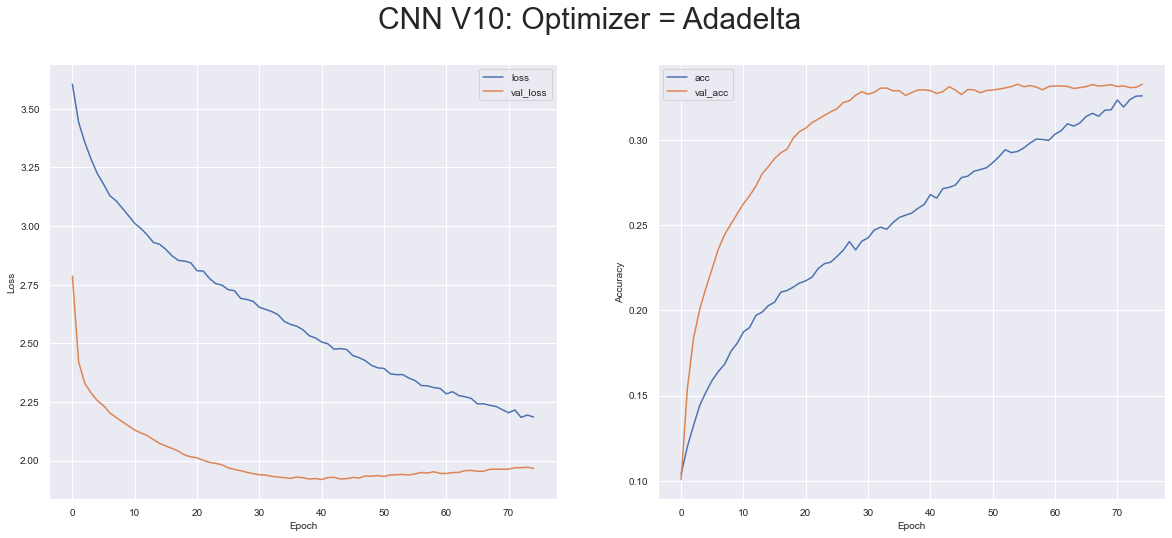

In [310]:
plot_loss_accraucy_graph(CNN_v10_aug_history_Adadelta, "CNN V10: Optimizer = Adadelta")

In [311]:
CNN_v10_predictions_Adadelta=eval_CNN_model(CNN_v10,"V10: Optimizer = Adadelta")

313/313 [==============================] - 0s 1ms/step
CNN V10: Optimizer = Adadelta Training Data Accuracy: 32.19 %
CNN V10: Optimizer = Adadelta Testing Data Accuracy: 33.25 %
CNN V10: Optimizer = Adadelta F1-Score: 0.321


#### 5.3.11.5  Fine - Tuning Model: Optimizer = Adagrad

In [312]:
CNN_v10.compile(optimizer="Adagrad", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_v10_aug_history_Adagrad = CNN_v10.fit(augmented_train_batchsize_128, epochs=500, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/500
391/391 [==============================] - 6s 14ms/step - loss: 2.1126 - accuracy: 0.3331 - val_loss: 2.0191 - val_accuracy: 0.3293
Epoch 2/500
391/391 [==============================] - 5s 14ms/step - loss: 1.9796 - accuracy: 0.3643 - val_loss: 1.9824 - val_accuracy: 0.3468
Epoch 3/500
391/391 [==============================] - 5s 14ms/step - loss: 1.8916 - accuracy: 0.3843 - val_loss: 1.9756 - val_accuracy: 0.3545
Epoch 4/500
391/391 [==============================] - 6s 15ms/step - loss: 1.8153 - accuracy: 0.4025 - val_loss: 1.9630 - val_accuracy: 0.3748
Epoch 5/500
391/391 [==============================] - 6s 16ms/step - loss: 1.7573 - accuracy: 0.4190 - val_loss: 2.0158 - val_accuracy: 0.3689
Epoch 6/500
391/391 [==============================] - 6s 15ms/step - loss: 1.7031 - accuracy: 0.4332 - val_loss: 1.9653 - val_accuracy: 0.3935
Epoch 7/500
391/391 [==============================] - 6s 15ms/step - loss: 1.6541 - accuracy: 0.4459 - val_loss: 1.9840 - val_accuracy:

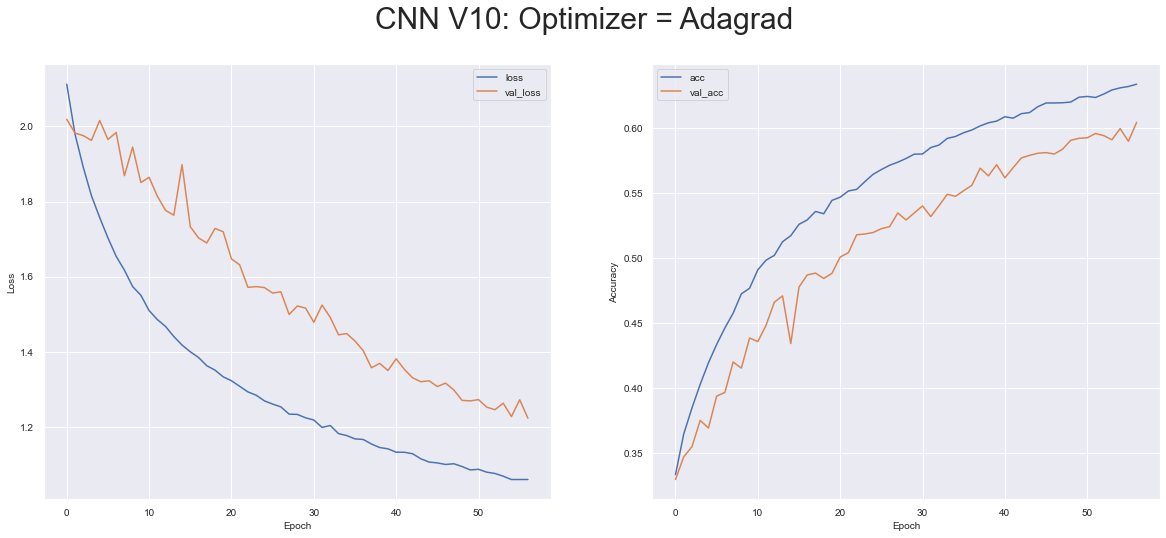

In [313]:
plot_loss_accraucy_graph(CNN_v10_aug_history_Adagrad, "CNN V10: Optimizer = Adagrad")

In [314]:
CNN_v10_predictions_Adagrad=eval_CNN_model(CNN_v10,"V10: Optimizer = Adagrad")

313/313 [==============================] - 0s 1ms/step
CNN V10: Optimizer = Adagrad Training Data Accuracy: 61.51 %
CNN V10: Optimizer = Adagrad Testing Data Accuracy: 60.41 %
CNN V10: Optimizer = Adagrad F1-Score: 0.599


####  Model Summary - Optimizer

<table>
    <th> Optimizer </th>
    <th> Test Accuracy </th> 
    <th> Test F1-Score </th>
    <th> Train Loss vs Validation Loss </th>
    <th> Train Accuracy vs Validation Accuracy </th>
       <tr>
        <td> Adam </td>
        <td> 88.81% </td>
        <td> 0.887 </td>
        <td> Overfitting - Loss is increasing towards the end of the epochs  </td>
           <td> - </td>
    </tr>
        <tr>
        <td> Adagrad </td>
        <td> 60.41% </td>
        <td> 0.599 </td>
        <td> Overfitting - Loss is increasing towards the end of the epochs </td>
        <td> - </td>
    </tr>
        <tr>
        <td> Adadelta </td>
        <td> 33.25% </td>
        <td> 0.321 </td>
        <td> - </td>
        <td> Overfitting </td>
    </tr>
            <tr>
        <td> RMSprop </td>
        <td> 86.97% </td>
        <td> 0.87 </td>
        <td>Overfitting - Loss is increasing towards the end of the epochs </td>
        <td> - </td>
    </tr>
                <tr>
        <td> SGD </td>
        <td> 81.07% </td>
        <td> 0.811 </td>
        <td> - </td>
        <td> Slightly Overfitting </td>
    </tr>
                    <tr>
        <td> Adamax </td>
        <td> 88.49% </td>
        <td> 0.885 </td>
        <td> Increasing towards the end of the epochs </td>
        <td> - </td>
    </tr>
    </table>
   
  I ran 6 different optimizers and the results are shown in the table above. The best performing optimizers were adam and adamax. The results of both models were very close. However the performance of adam is minutely better than adamax. Hence, the final optimizer used was adam. Since, this is the same model as the previous version, there is no difference in the model performance.

### 5.3.12 Fine - Tuning Model: Learning Rate

#### 5.3.12.1 Fine - Tuning Model: Learning Rate = 3e-4

In [96]:
adam_optimizer_learning_rate_1 =tf.keras.optimizers.Adam( learning_rate=3e-4)
CNN_v10.compile(optimizer=adam_optimizer_learning_rate_1, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_v10_aug_history_learning_rate_1 = CNN_v10.fit(augmented_train_batchsize_128, epochs=500, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/500
391/391 [==============================] - 7s 15ms/step - loss: 2.2038 - accuracy: 0.3128 - val_loss: 3.7629 - val_accuracy: 0.1433
Epoch 2/500
391/391 [==============================] - 6s 15ms/step - loss: 1.5972 - accuracy: 0.4519 - val_loss: 1.4931 - val_accuracy: 0.5007
Epoch 3/500
391/391 [==============================] - 6s 15ms/step - loss: 1.3085 - accuracy: 0.5429 - val_loss: 1.5993 - val_accuracy: 0.5007
Epoch 4/500
391/391 [==============================] - 6s 16ms/step - loss: 1.1304 - accuracy: 0.6056 - val_loss: 1.2486 - val_accuracy: 0.5943
Epoch 5/500
391/391 [==============================] - 6s 16ms/step - loss: 1.0293 - accuracy: 0.6425 - val_loss: 0.8482 - val_accuracy: 0.7054
Epoch 6/500
391/391 [==============================] - 6s 16ms/step - loss: 0.9470 - accuracy: 0.6697 - val_loss: 0.9863 - val_accuracy: 0.6686
Epoch 7/500
391/391 [==============================] - 6s 16ms/step - loss: 0.8862 - accuracy: 0.6896 - val_loss: 0.8904 - val_accuracy:

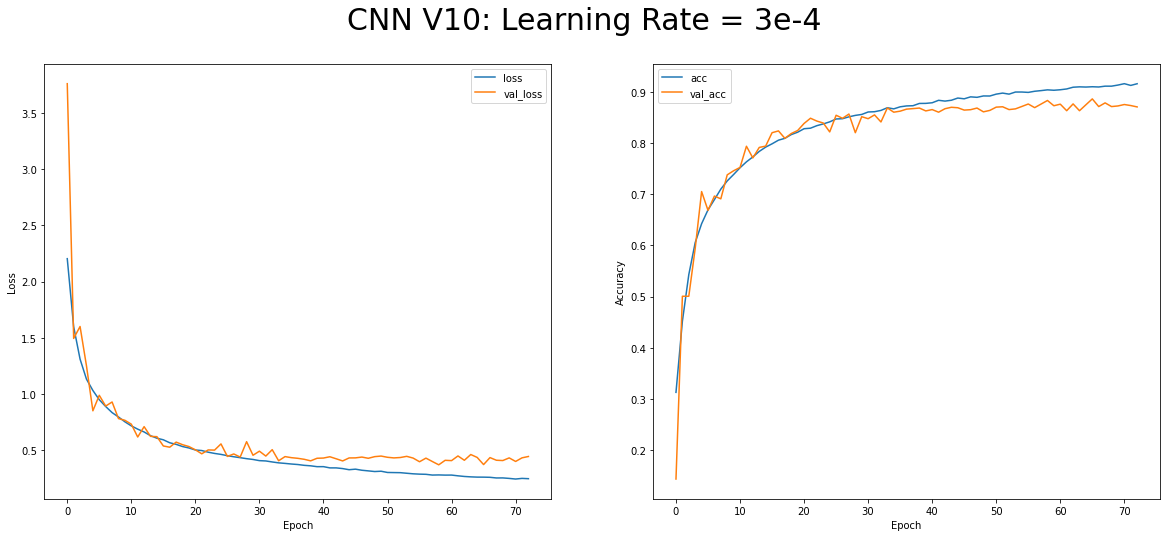

In [97]:
plot_loss_accraucy_graph(CNN_v10_aug_history_learning_rate_1, "CNN V10: Learning Rate = 3e-4")

In [98]:
CNN_v10_predictions_learning_rate_1=eval_CNN_model(CNN_v10,"V10: Learning Rate = 3e-4")

313/313 [==============================] - 0s 1ms/step
CNN V10: Learning Rate = 3e-4 Training Data Accuracy: 95.16 %
CNN V10: Learning Rate = 3e-4 Testing Data Accuracy: 87.09 %
CNN V10: Learning Rate = 3e-4 F1-Score: 0.871


#### 5.3.12.2 Fine - Tuning Model: Learning Rate = 5e-4

In [30]:
adam_optimizer_learning_rate_2 =tf.keras.optimizers.Adam( learning_rate=5e-4)
CNN_v10.compile(optimizer=adam_optimizer_learning_rate_2, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_v10_aug_history_learning_rate_2 = CNN_v10.fit(augmented_train_batchsize_128, epochs=500, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/500
391/391 [==============================] - 7s 15ms/step - loss: 2.0001 - accuracy: 0.3545 - val_loss: 3.2462 - val_accuracy: 0.1625
Epoch 2/500
391/391 [==============================] - 6s 14ms/step - loss: 1.3555 - accuracy: 0.5254 - val_loss: 1.5255 - val_accuracy: 0.5295
Epoch 3/500
391/391 [==============================] - 6s 14ms/step - loss: 1.0935 - accuracy: 0.6159 - val_loss: 2.0049 - val_accuracy: 0.4579
Epoch 4/500
391/391 [==============================] - 6s 15ms/step - loss: 0.9620 - accuracy: 0.6641 - val_loss: 1.4782 - val_accuracy: 0.5372
Epoch 5/500
391/391 [==============================] - 6s 14ms/step - loss: 0.8823 - accuracy: 0.6932 - val_loss: 0.7741 - val_accuracy: 0.7378
Epoch 6/500
391/391 [==============================] - 6s 14ms/step - loss: 0.8198 - accuracy: 0.7171 - val_loss: 0.8386 - val_accuracy: 0.7218
Epoch 7/500
391/391 [==============================] - 6s 14ms/step - loss: 0.7658 - accuracy: 0.7375 - val_loss: 0.7680 - val_accuracy:

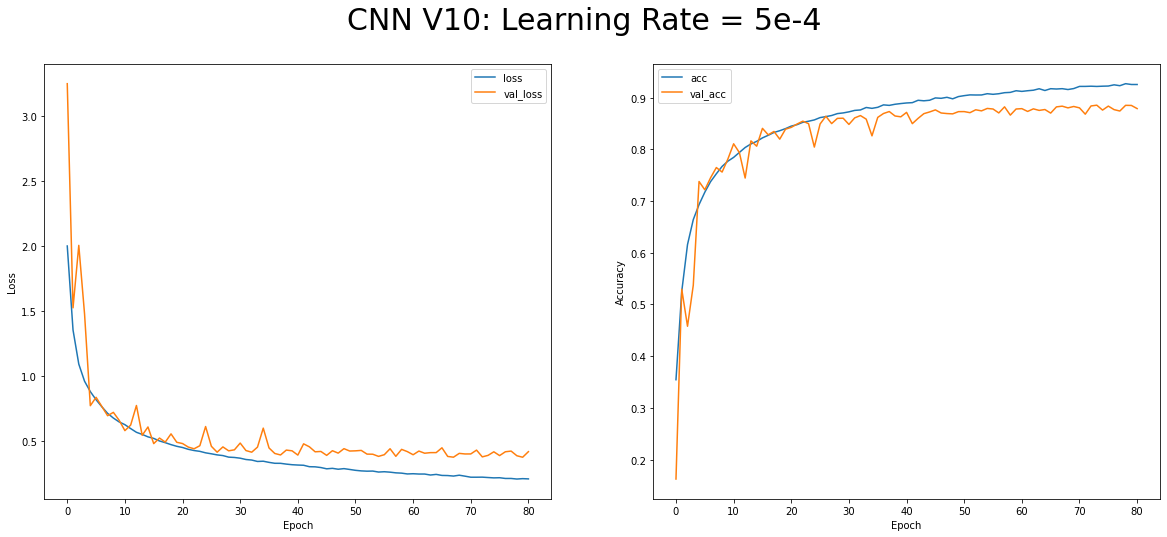

In [31]:
plot_loss_accraucy_graph(CNN_v10_aug_history_learning_rate_2, "CNN V10: Learning Rate = 5e-4")

In [32]:
CNN_v10_predictions_learning_rate_2=eval_CNN_model(CNN_v10,"V10: Learning Rate = 5e-4")

313/313 [==============================] - 0s 1ms/step
CNN V10: Learning Rate = 5e-4 Training Data Accuracy: 96.9 %
CNN V10: Learning Rate = 5e-4 Testing Data Accuracy: 87.88 %
CNN V10: Learning Rate = 5e-4 F1-Score: 0.878


#### 5.3.12.3 Fine - Tuning Model: Learning Rate = 2e-3

In [38]:
adam_optimizer_learning_rate_3 =tf.keras.optimizers.Adam( learning_rate=2e-3)
CNN_v10.compile(optimizer=adam_optimizer_learning_rate_3, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_v10_aug_history_learning_rate_3 = CNN_v10.fit(augmented_train_batchsize_128, epochs=500, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/500
391/391 [==============================] - 7s 15ms/step - loss: 1.6429 - accuracy: 0.4384 - val_loss: 3.2433 - val_accuracy: 0.2066
Epoch 2/500
391/391 [==============================] - 6s 14ms/step - loss: 1.0637 - accuracy: 0.6290 - val_loss: 0.9367 - val_accuracy: 0.6799
Epoch 3/500
391/391 [==============================] - 6s 14ms/step - loss: 0.9015 - accuracy: 0.6876 - val_loss: 0.8987 - val_accuracy: 0.7091
Epoch 4/500
391/391 [==============================] - 6s 14ms/step - loss: 0.8134 - accuracy: 0.7197 - val_loss: 0.7432 - val_accuracy: 0.7563
Epoch 5/500
391/391 [==============================] - 6s 14ms/step - loss: 0.7492 - accuracy: 0.7459 - val_loss: 0.8432 - val_accuracy: 0.7315
Epoch 6/500
391/391 [==============================] - 6s 14ms/step - loss: 0.6947 - accuracy: 0.7623 - val_loss: 0.7177 - val_accuracy: 0.7604
Epoch 7/500
391/391 [==============================] - 6s 14ms/step - loss: 0.6574 - accuracy: 0.7757 - val_loss: 0.6700 - val_accuracy:

In [39]:
CNN_v10_predictions_learning_rate_3=eval_CNN_model(CNN_v10,"V10: Learning Rate = 2e-3")

313/313 [==============================] - 0s 1ms/step
CNN V10: Learning Rate = 2e-3 Training Data Accuracy: 96.41 %
CNN V10: Learning Rate = 2e-3 Testing Data Accuracy: 87.85 %
CNN V10: Learning Rate = 2e-3 F1-Score: 0.878


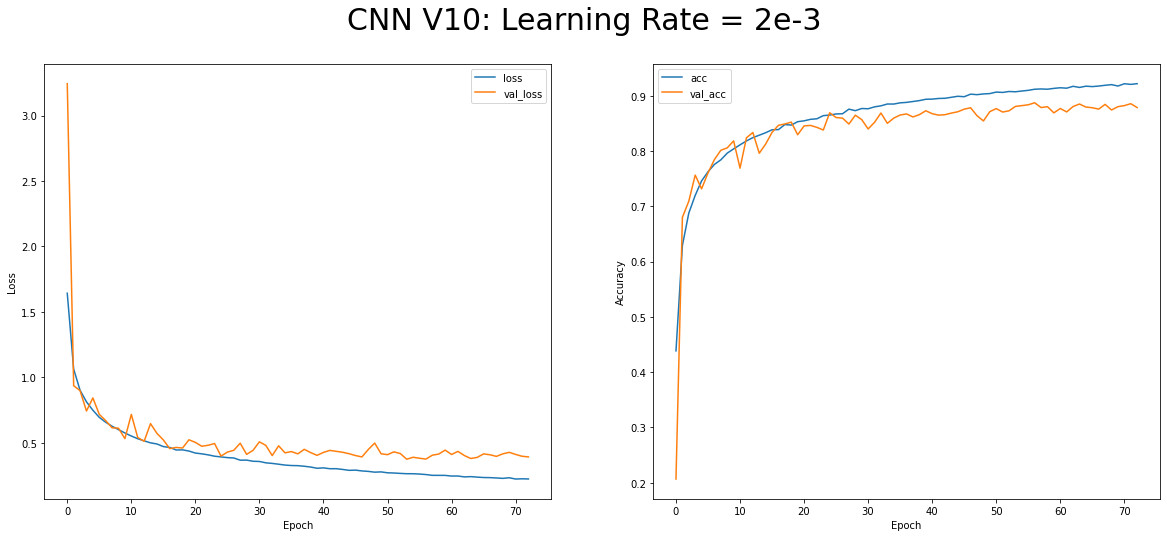

In [40]:
plot_loss_accraucy_graph(CNN_v10_aug_history_learning_rate_3, "CNN V10: Learning Rate = 2e-3")

#### 5.3.12.4 Fine - Tuning Model: Learning Rate = 3e-3

In [43]:
adam_optimizer_learning_rate_4 =tf.keras.optimizers.Adam( learning_rate=3e-3)
CNN_v10.compile(optimizer=adam_optimizer_learning_rate_4, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_v10_aug_history_learning_rate_4 = CNN_v10.fit(augmented_train_batchsize_128, epochs=500, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/500
391/391 [==============================] - 6s 14ms/step - loss: 1.6604 - accuracy: 0.4248 - val_loss: 2.8915 - val_accuracy: 0.2394
Epoch 2/500
391/391 [==============================] - 6s 14ms/step - loss: 1.0715 - accuracy: 0.6240 - val_loss: 1.3854 - val_accuracy: 0.5642
Epoch 3/500
391/391 [==============================] - 6s 14ms/step - loss: 0.9031 - accuracy: 0.6875 - val_loss: 1.4477 - val_accuracy: 0.5663
Epoch 4/500
391/391 [==============================] - 5s 14ms/step - loss: 0.8126 - accuracy: 0.7197 - val_loss: 1.0140 - val_accuracy: 0.6621
Epoch 5/500
391/391 [==============================] - 5s 14ms/step - loss: 0.7513 - accuracy: 0.7441 - val_loss: 0.8195 - val_accuracy: 0.7299
Epoch 6/500
391/391 [==============================] - 5s 14ms/step - loss: 0.6893 - accuracy: 0.7653 - val_loss: 0.7478 - val_accuracy: 0.7527
Epoch 7/500
391/391 [==============================] - 5s 14ms/step - loss: 0.6506 - accuracy: 0.7781 - val_loss: 0.6684 - val_accuracy:

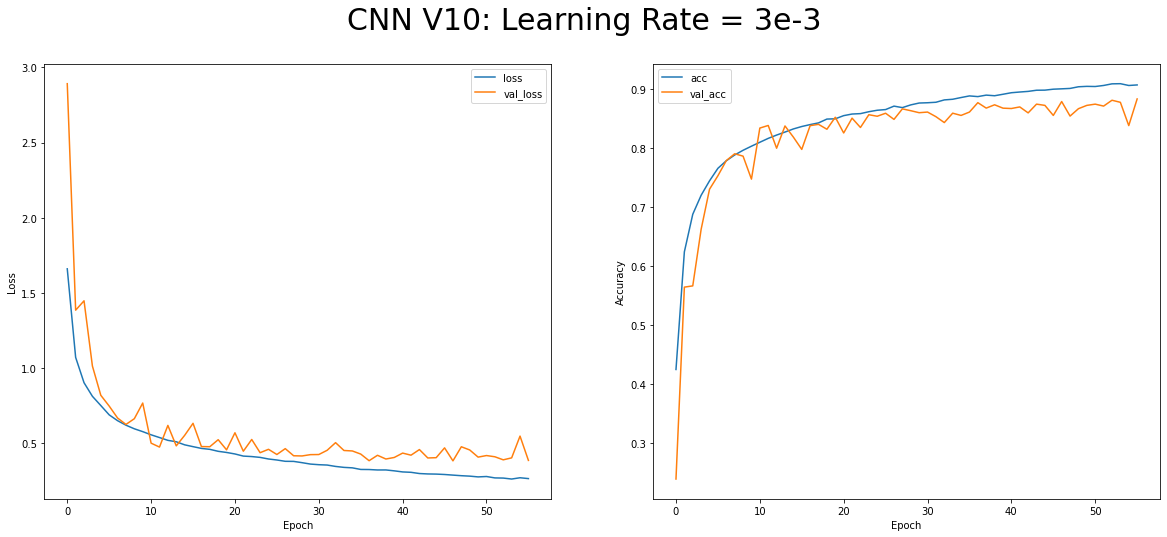

In [44]:
plot_loss_accraucy_graph(CNN_v10_aug_history_learning_rate_4, "CNN V10: Learning Rate = 3e-3")

In [68]:
CNN_v10_predictions_learning_rate_4=eval_CNN_model(CNN_v10,"V10: Learning Rate = 3e-3")

313/313 [==============================] - 0s 1ms/step
CNN V10: Learning Rate = 3e-3 Training Data Accuracy: 96.8 %
CNN V10: Learning Rate = 3e-3 Testing Data Accuracy: 88.4 %
CNN V10: Learning Rate = 3e-3 F1-Score: 0.883


##### 5.3.12.5 Fine - Tuning Model: Learning Rate = 5e-3

In [47]:
adam_optimizer_learning_rate_5 =tf.keras.optimizers.Adam( learning_rate=5e-3)
CNN_v10.compile(optimizer=adam_optimizer_learning_rate_5, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_v10_aug_history_learning_rate_5 = CNN_v10.fit(augmented_train_batchsize_128, epochs=500, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/500
391/391 [==============================] - 6s 14ms/step - loss: 1.6877 - accuracy: 0.4060 - val_loss: 2.0287 - val_accuracy: 0.3017
Epoch 2/500
391/391 [==============================] - 5s 14ms/step - loss: 1.1120 - accuracy: 0.6072 - val_loss: 0.9329 - val_accuracy: 0.6828
Epoch 3/500
391/391 [==============================] - 5s 14ms/step - loss: 0.9272 - accuracy: 0.6759 - val_loss: 0.8117 - val_accuracy: 0.7232
Epoch 4/500
391/391 [==============================] - 6s 14ms/step - loss: 0.8345 - accuracy: 0.7118 - val_loss: 1.0061 - val_accuracy: 0.6762
Epoch 5/500
391/391 [==============================] - 5s 14ms/step - loss: 0.7561 - accuracy: 0.7403 - val_loss: 0.9600 - val_accuracy: 0.7002
Epoch 6/500
391/391 [==============================] - 6s 14ms/step - loss: 0.7187 - accuracy: 0.7550 - val_loss: 0.8205 - val_accuracy: 0.7203
Epoch 7/500
391/391 [==============================] - 6s 14ms/step - loss: 0.6821 - accuracy: 0.7671 - val_loss: 0.8939 - val_accuracy:

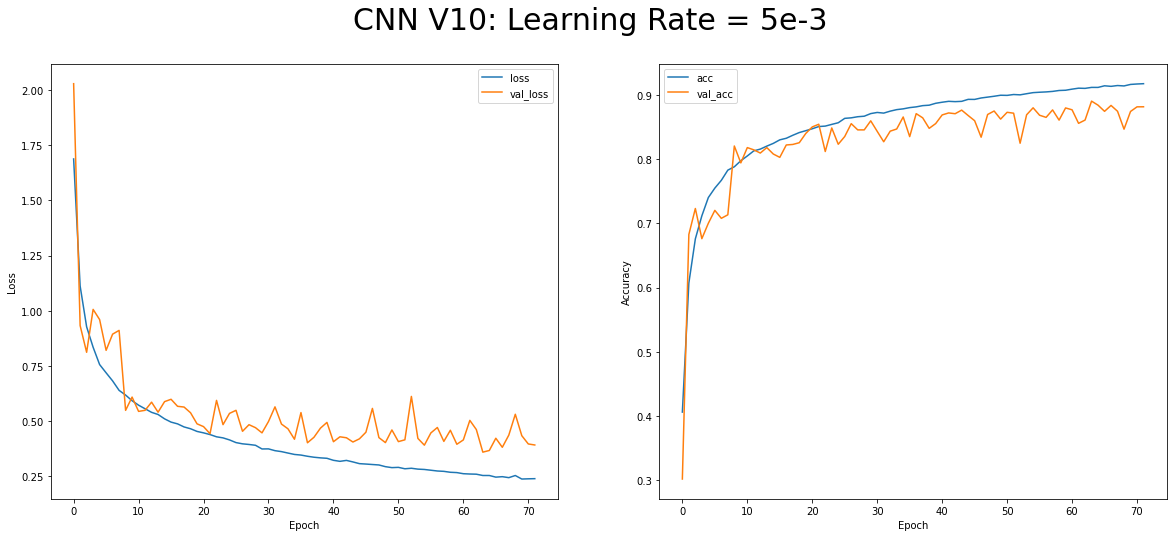

In [48]:
plot_loss_accraucy_graph(CNN_v10_aug_history_learning_rate_5, "CNN V10: Learning Rate = 5e-3")

In [69]:
CNN_v10_predictions_learning_rate_5=eval_CNN_model(CNN_v10,"V10: Learning Rate = 5e-3")

313/313 [==============================] - 0s 1ms/step
CNN V10: Learning Rate = 5e-3 Training Data Accuracy: 96.8 %
CNN V10: Learning Rate = 5e-3 Testing Data Accuracy: 88.4 %
CNN V10: Learning Rate = 5e-3 F1-Score: 0.883


##### 5.3.12.6 Fine - Tuning Model: Learning Rate = 4e-3

In [85]:
adam_optimizer_learning_rate_6 =tf.keras.optimizers.Adam( learning_rate=4e-3)
CNN_v10.compile(optimizer=adam_optimizer_learning_rate_6, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_v10_aug_history_learning_rate_6 = CNN_v10.fit(augmented_train_batchsize_128, epochs=500, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/500
391/391 [==============================] - 7s 16ms/step - loss: 1.6289 - accuracy: 0.4339 - val_loss: 2.7299 - val_accuracy: 0.2109
Epoch 2/500
391/391 [==============================] - 6s 15ms/step - loss: 1.0770 - accuracy: 0.6233 - val_loss: 1.6349 - val_accuracy: 0.5473
Epoch 3/500
391/391 [==============================] - 6s 15ms/step - loss: 0.9037 - accuracy: 0.6863 - val_loss: 0.8911 - val_accuracy: 0.6962
Epoch 4/500
391/391 [==============================] - 6s 14ms/step - loss: 0.8102 - accuracy: 0.7229 - val_loss: 0.8240 - val_accuracy: 0.7132
Epoch 5/500
391/391 [==============================] - 6s 15ms/step - loss: 0.7538 - accuracy: 0.7415 - val_loss: 0.7708 - val_accuracy: 0.7434
Epoch 6/500
391/391 [==============================] - 6s 15ms/step - loss: 0.7011 - accuracy: 0.7608 - val_loss: 0.7030 - val_accuracy: 0.7689
Epoch 7/500
391/391 [==============================] - 6s 16ms/step - loss: 0.6632 - accuracy: 0.7733 - val_loss: 1.0368 - val_accuracy:

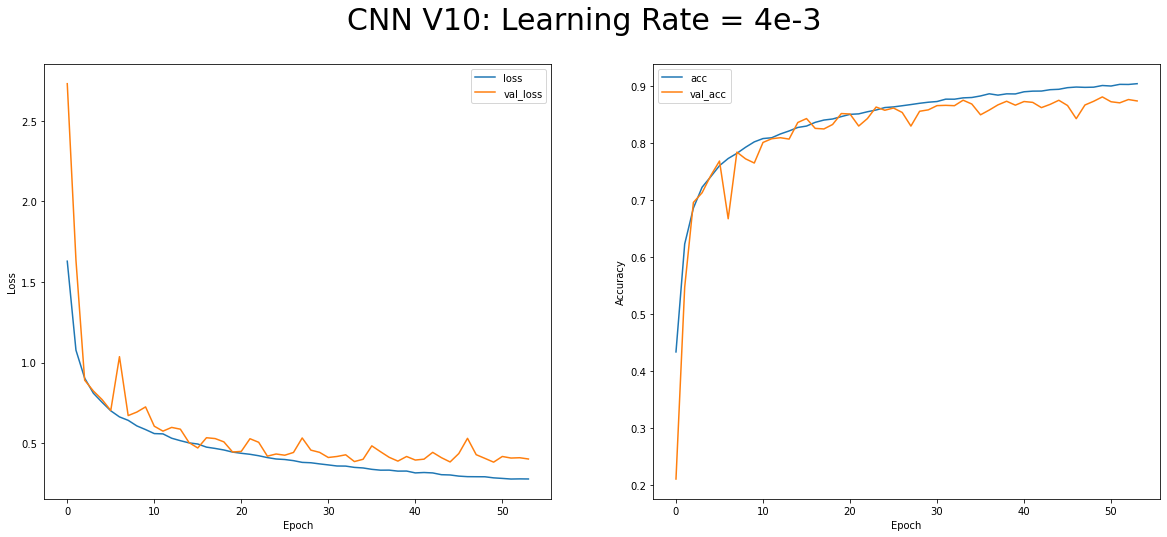

In [86]:
plot_loss_accraucy_graph(CNN_v10_aug_history_learning_rate_6, "CNN V10: Learning Rate = 4e-3")

In [87]:
CNN_v10_predictions_learning_rate_6=eval_CNN_model(CNN_v10,"V10: Learning Rate = 4e-3")

313/313 [==============================] - 0s 1ms/step
CNN V10: Learning Rate = 4e-3 Training Data Accuracy: 94.04 %
CNN V10: Learning Rate = 4e-3 Testing Data Accuracy: 87.43 %
CNN V10: Learning Rate = 4e-3 F1-Score: 0.874


##### 5.3.12.7 Fine - Tuning Model: Learning Rate = 4e-4

In [56]:
adam_optimizer_learning_rate_7 =tf.keras.optimizers.Adam( learning_rate=4e-4)
CNN_v10.compile(optimizer=adam_optimizer_learning_rate_7, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_v10_aug_history_learning_rate_7 = CNN_v10.fit(augmented_train_batchsize_128, epochs=500, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/500
391/391 [==============================] - 6s 15ms/step - loss: 2.1141 - accuracy: 0.3352 - val_loss: 3.5365 - val_accuracy: 0.1628
Epoch 2/500
391/391 [==============================] - 6s 15ms/step - loss: 1.4400 - accuracy: 0.5039 - val_loss: 1.2950 - val_accuracy: 0.5625
Epoch 3/500
391/391 [==============================] - 6s 15ms/step - loss: 1.1581 - accuracy: 0.5957 - val_loss: 1.0898 - val_accuracy: 0.6353
Epoch 4/500
391/391 [==============================] - 6s 15ms/step - loss: 1.0127 - accuracy: 0.6443 - val_loss: 1.1989 - val_accuracy: 0.6094
Epoch 5/500
391/391 [==============================] - 6s 15ms/step - loss: 0.9220 - accuracy: 0.6785 - val_loss: 1.0028 - val_accuracy: 0.6647
Epoch 6/500
391/391 [==============================] - 6s 15ms/step - loss: 0.8504 - accuracy: 0.7043 - val_loss: 0.8083 - val_accuracy: 0.7224
Epoch 7/500
391/391 [==============================] - 6s 15ms/step - loss: 0.7955 - accuracy: 0.7236 - val_loss: 0.8743 - val_accuracy:

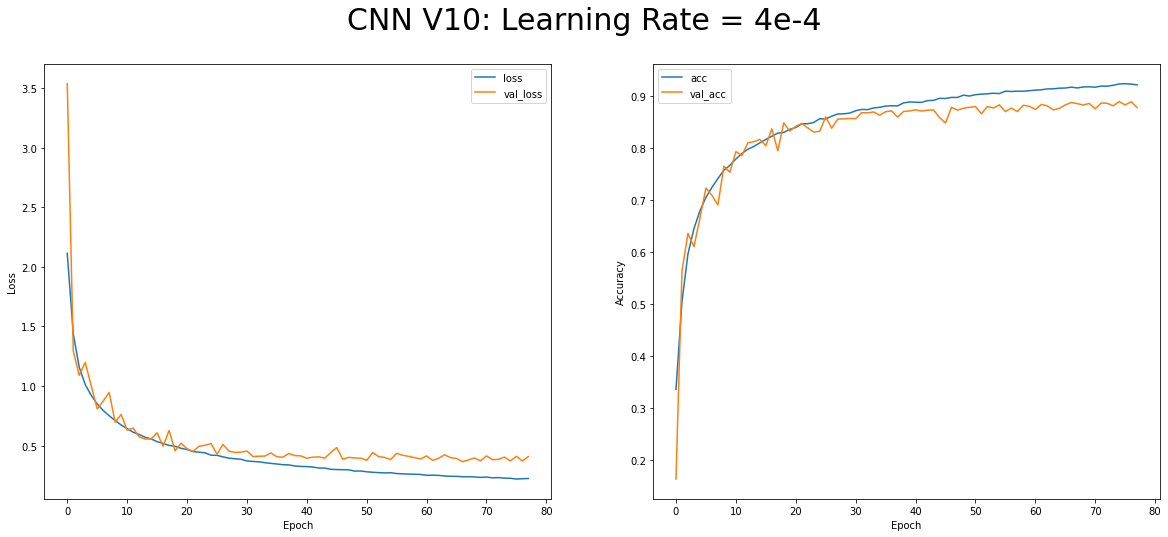

In [57]:
plot_loss_accraucy_graph(CNN_v10_aug_history_learning_rate_7, "CNN V10: Learning Rate = 4e-4")

In [71]:
CNN_v10_predictions_learning_rate_7=eval_CNN_model(CNN_v10,"V10: Learning Rate = 4e-4")

313/313 [==============================] - 0s 1ms/step
CNN V10: Learning Rate = 4e-4 Training Data Accuracy: 96.8 %
CNN V10: Learning Rate = 4e-4 Testing Data Accuracy: 88.4 %
CNN V10: Learning Rate = 4e-4 F1-Score: 0.883


##### 5.3.12.8 Fine - Tuning Model: Learning Rate = 1e-4

In [17]:
adam_optimizer_learning_rate_8 =tf.keras.optimizers.Adam( learning_rate=1e-4)
CNN_v10.compile(optimizer=adam_optimizer_learning_rate_8, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_v10_aug_history_learning_rate_8 = CNN_v10.fit(augmented_train_batchsize_128, epochs=500, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/500
391/391 [==============================] - 42s 78ms/step - loss: 2.5977 - accuracy: 0.2489 - val_loss: 4.0232 - val_accuracy: 0.1058
Epoch 2/500
391/391 [==============================] - 28s 70ms/step - loss: 2.0521 - accuracy: 0.3450 - val_loss: 3.0216 - val_accuracy: 0.1703
Epoch 3/500
391/391 [==============================] - 32s 81ms/step - loss: 1.8078 - accuracy: 0.3994 - val_loss: 2.1702 - val_accuracy: 0.3359
Epoch 4/500
391/391 [==============================] - 30s 75ms/step - loss: 1.6151 - accuracy: 0.4530 - val_loss: 2.5577 - val_accuracy: 0.3212
Epoch 5/500
391/391 [==============================] - 10s 26ms/step - loss: 1.4634 - accuracy: 0.5003 - val_loss: 2.2525 - val_accuracy: 0.3761
Epoch 6/500
391/391 [==============================] - 36s 92ms/step - loss: 1.3423 - accuracy: 0.5395 - val_loss: 1.7982 - val_accuracy: 0.4617
Epoch 7/500
391/391 [==============================] - 42s 106ms/step - loss: 1.2507 - accuracy: 0.5681 - val_loss: 1.4501 - val_a

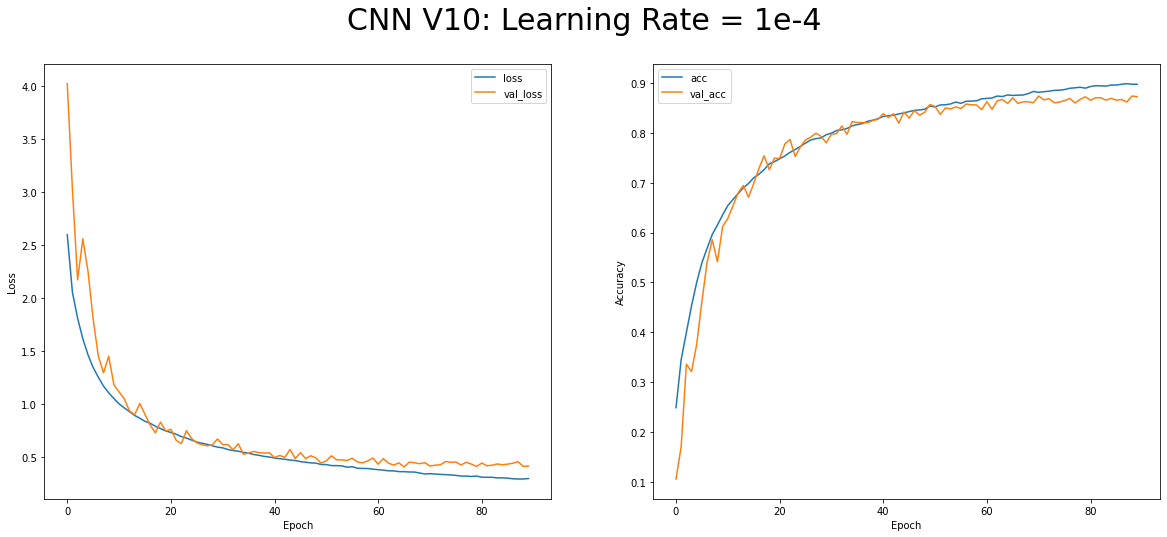

In [18]:
plot_loss_accraucy_graph(CNN_v10_aug_history_learning_rate_8, "CNN V10: Learning Rate = 1e-4")

In [19]:
CNN_v10_predictions_learning_rate_8=eval_CNN_model(CNN_v10,"V10: Learning Rate = 1e-4")

313/313 [==============================] - 6s 16ms/step
CNN V10: Learning Rate = 1e-4 Training Data Accuracy: 94.86 %
CNN V10: Learning Rate = 1e-4 Testing Data Accuracy: 87.24 %
CNN V10: Learning Rate = 1e-4 F1-Score: 0.872


              precision    recall  f1-score   support

           0       0.87      0.93      0.90       931
           1       0.95      0.95      0.95       999
           2       0.77      0.86      0.81       889
           3       0.72      0.78      0.75       923
           4       0.88      0.82      0.85      1068
           5       0.80      0.82      0.81       976
           6       0.96      0.79      0.86      1216
           7       0.90      0.94      0.92       954
           8       0.93      0.95      0.94       983
           9       0.95      0.90      0.93      1061

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000

---------------------------------------------------------------


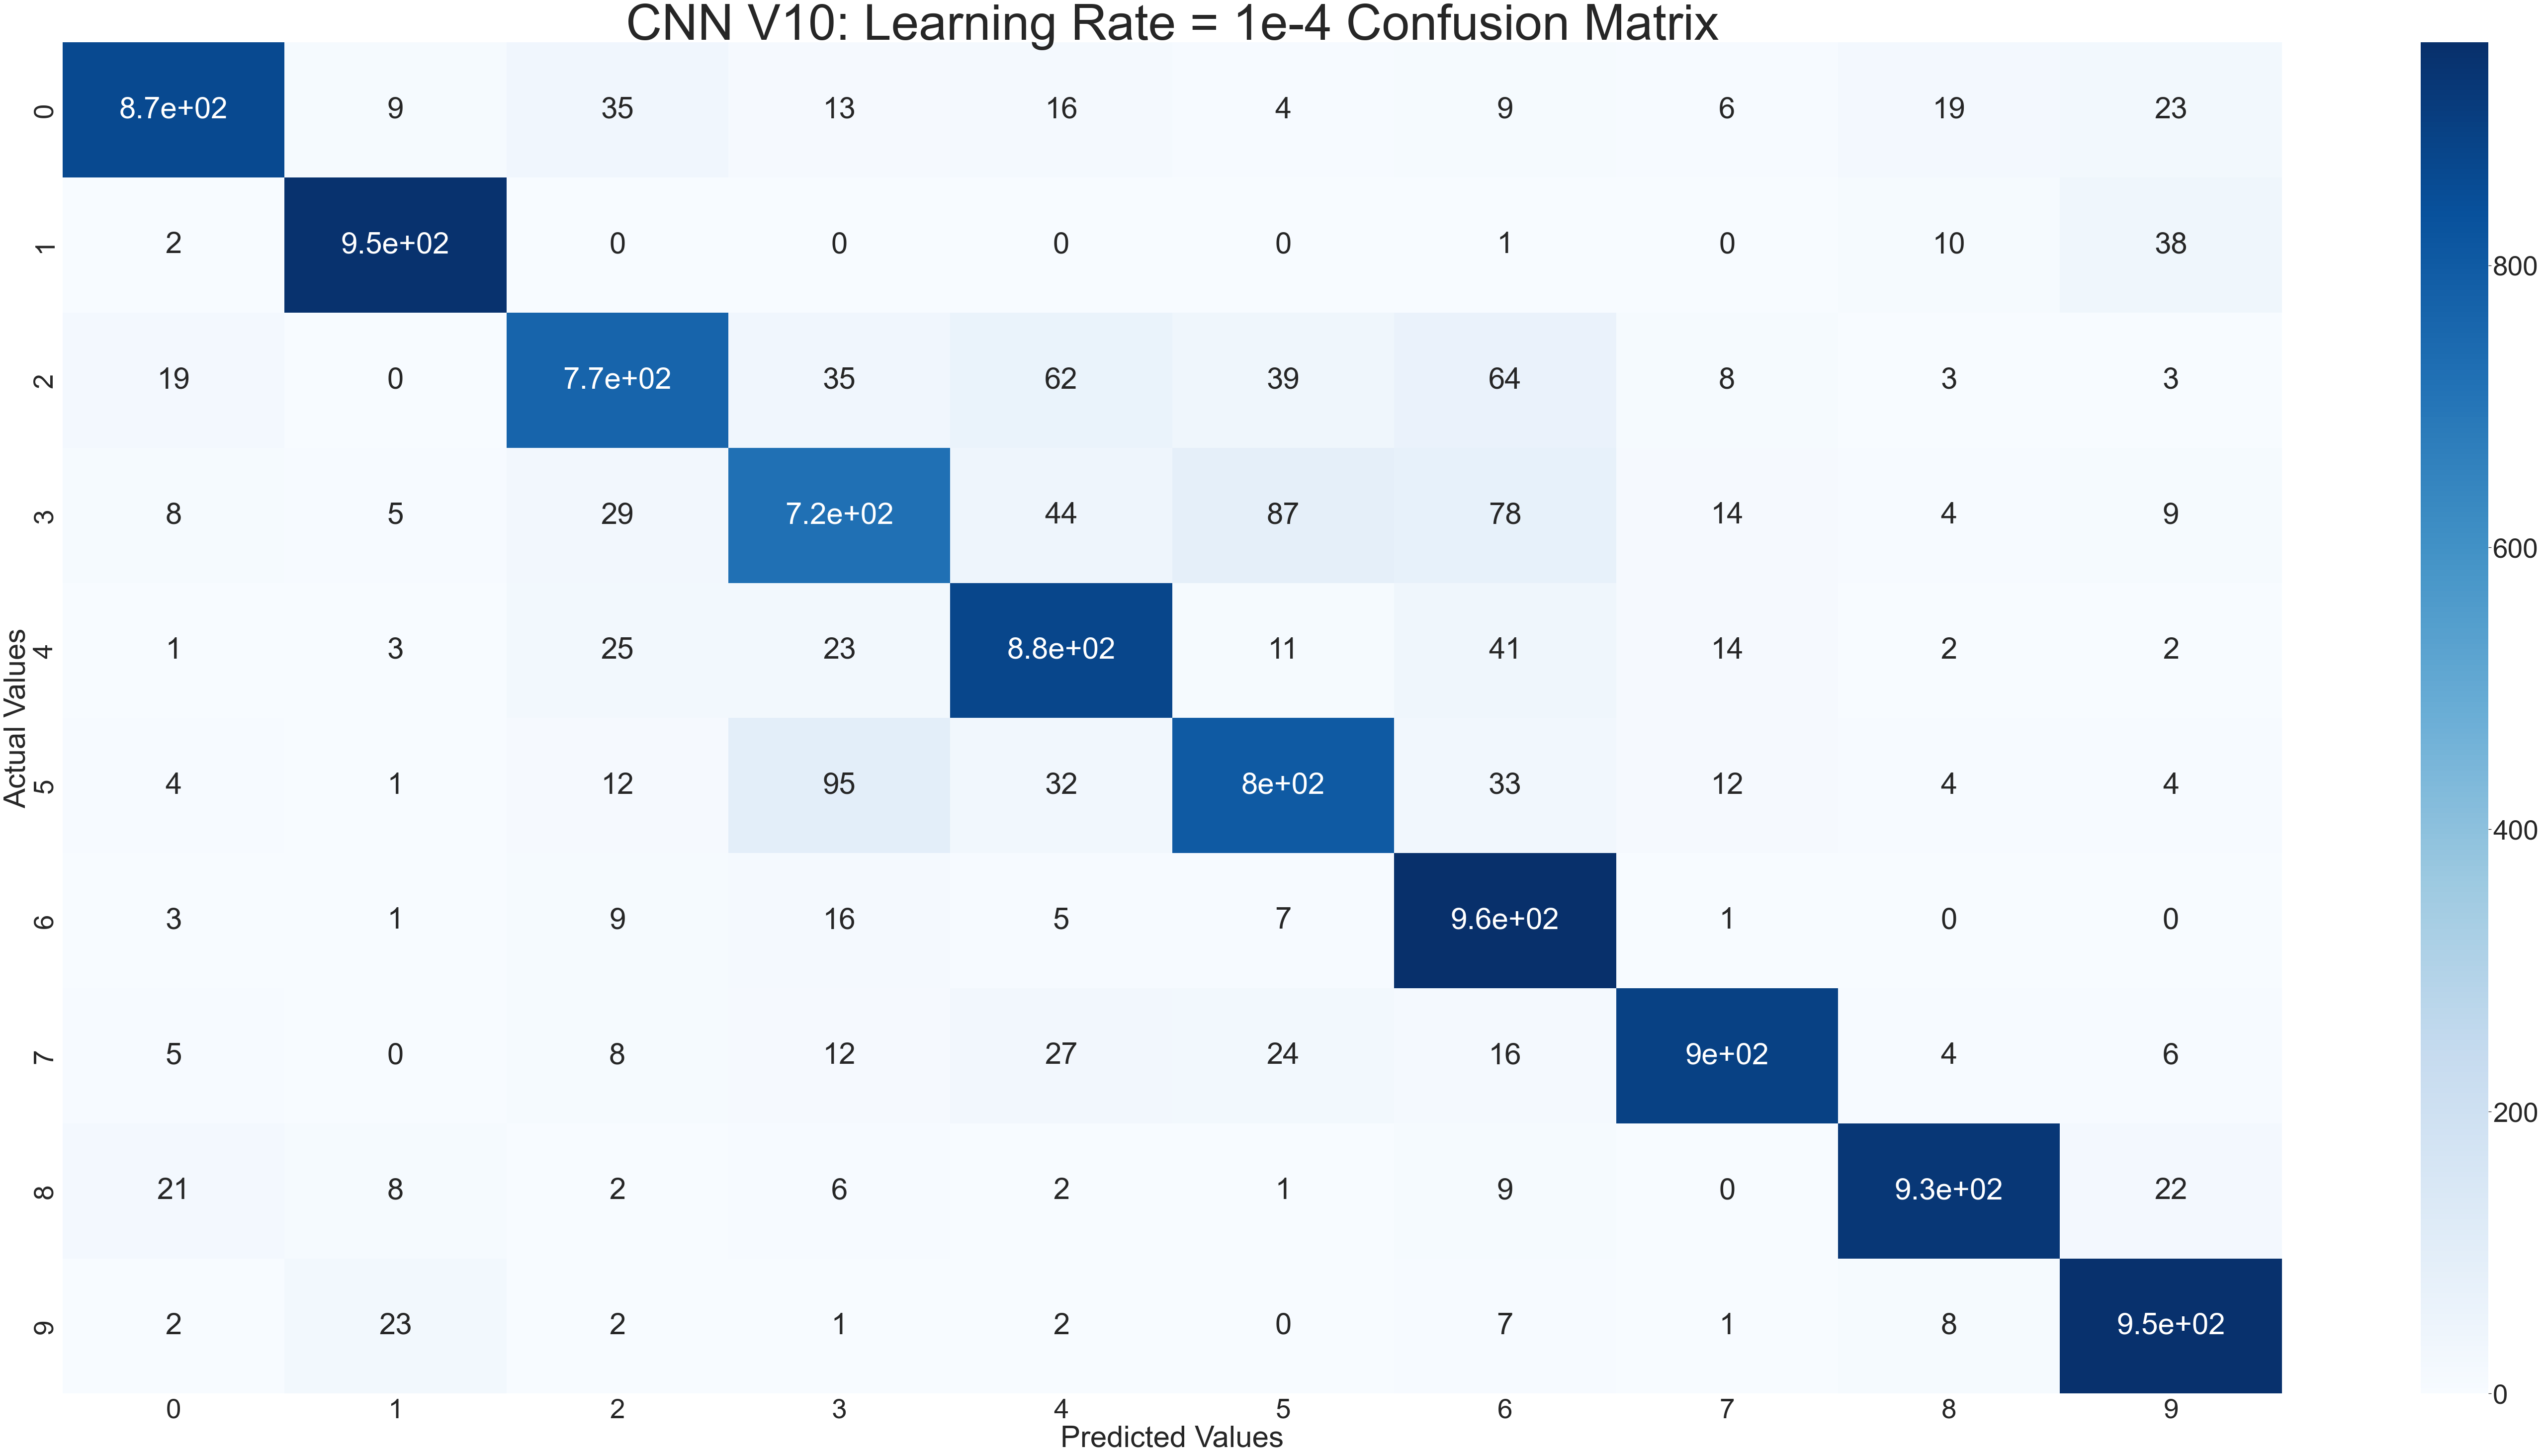

In [23]:
plot_confusion_matrix(CNN_v10_predictions_learning_rate_8,"V10: Learning Rate = 1e-4")

##### 5.3.12.8 Fine - Tuning Model: Learning Rate = 1e-3

In [66]:
adam_optimizer_learning_rate_9 =tf.keras.optimizers.Adam( learning_rate=1e-3)
CNN_v10.compile(optimizer=adam_optimizer_learning_rate_9, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_v10_aug_history_learning_rate_9 = CNN_v10.fit(augmented_train_batchsize_128, epochs=500, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/500
391/391 [==============================] - 7s 15ms/step - loss: 1.8505 - accuracy: 0.3846 - val_loss: 3.5048 - val_accuracy: 0.1480
Epoch 2/500
391/391 [==============================] - 6s 15ms/step - loss: 1.1614 - accuracy: 0.5921 - val_loss: 1.0396 - val_accuracy: 0.6400
Epoch 3/500
391/391 [==============================] - 6s 14ms/step - loss: 0.9622 - accuracy: 0.6645 - val_loss: 0.7887 - val_accuracy: 0.7320
Epoch 4/500
391/391 [==============================] - 6s 14ms/step - loss: 0.8529 - accuracy: 0.7035 - val_loss: 0.7354 - val_accuracy: 0.7454
Epoch 5/500
391/391 [==============================] - 5s 14ms/step - loss: 0.7864 - accuracy: 0.7292 - val_loss: 0.8182 - val_accuracy: 0.7335
Epoch 6/500
391/391 [==============================] - 5s 14ms/step - loss: 0.7302 - accuracy: 0.7481 - val_loss: 0.8253 - val_accuracy: 0.7365
Epoch 7/500
391/391 [==============================] - 5s 14ms/step - loss: 0.6823 - accuracy: 0.7638 - val_loss: 1.0442 - val_accuracy:

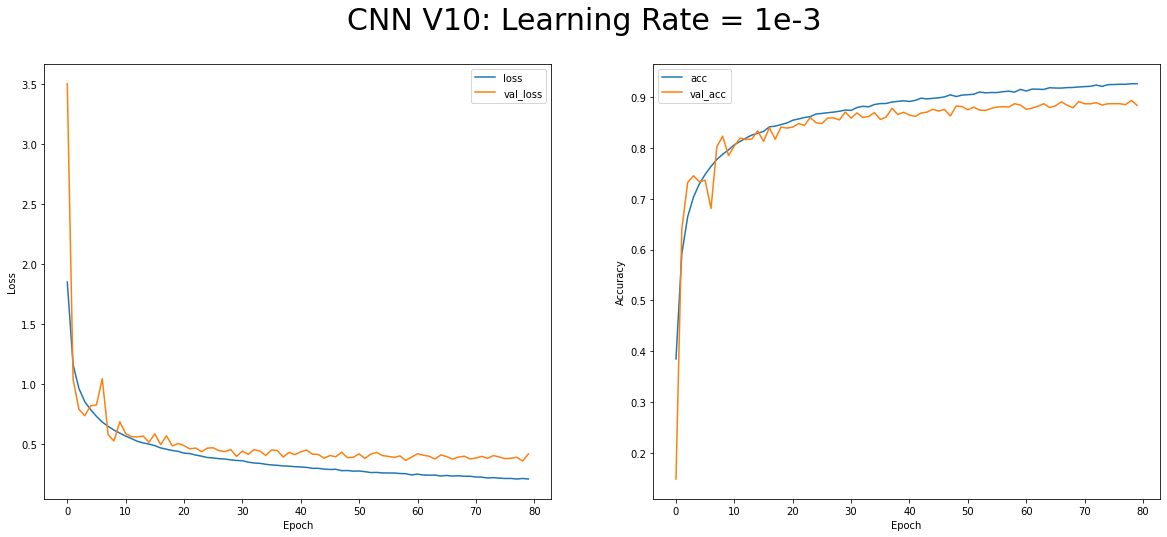

In [67]:
plot_loss_accraucy_graph(CNN_v10_aug_history_learning_rate_9, "CNN V10: Learning Rate = 1e-3")

In [73]:
CNN_v10_predictions_learning_rate_9=eval_CNN_model(CNN_v10,"V10: Learning Rate = 1e-3")

313/313 [==============================] - 0s 1ms/step
CNN V10: Learning Rate = 1e-3 Training Data Accuracy: 96.8 %
CNN V10: Learning Rate = 1e-3 Testing Data Accuracy: 88.4 %
CNN V10: Learning Rate = 1e-3 F1-Score: 0.883


####  Model Summary - Learning Rate

<table>
    <th> Learning Rate </th>
    <th> Test Accuracy </th> 
    <th> Test F1-Score </th>
    <th> Train Loss vs Validation Loss </th>
    <tr>
        <td> 1e - 3 </td>
        <td> 88.4% </td>
        <td> 0.883 </td>
        <td> Overfitting - Loss increasing towards end of epochs <br> Comparatively higher variance </td>
    </tr>
     <tr>
        <td> 1e - 4 </td>
        <td> 87.24% </td>
        <td> 0.872 </td>
        <td> Loss not increasing towards end of epochs </td>
    </tr>
    <tr>
        <td> 4e-4 </td>
        <td> 88.4% </td>
        <td> 0.883 </td>
        <td> Overfitting - Loss increasing towards end of epochs <br> Comparatively higher variance </td>
    </tr>
    <tr>
        <td> 4e - 3 </td>
        <td> 87.43% </td>
        <td> 0.874 </td>
        <td> Overfitting - Loss increasing towards end of epochs <br> Comparatively higher variance and fluctuating </td>
    </tr>
    <tr>
        <td> 5e - 3 </td>
        <td> 88.4% </td>
        <td> 0.883 </td>
        <td> Overfitting - Loss increasing towards end of epochs <br> Comparatively higher variance and fluctuating </td>
    </tr>
    <tr>
        <td>3e - 3 </td>
        <td> 88.4% </td>
        <td> 0.883 </td>
        <td> Overfitting - Loss increasing towards end of epochs <br> Comparatively higher variance and fluctuating </td>
    </tr>
    <tr>
        <td>2e - 3 </td>
        <td> 87.85% </td>
        <td> 0.878 </td>
        <td> Overfitting - Loss increasing towards end of epochs <br> Comparatively higher variance </td>
    </tr>
    <tr>
        <td>5e - 4 </td>
        <td> 87.88% </td>
        <td> 0.878 </td>
        <td> Overfitting - Loss increasing towards end of epochs <br> Comparatively higher variance </td>
    </tr>
    <tr>
        <td>3e - 4 </td>
        <td> 87.09% </td>
        <td> 0.871 </td>
        <td> Overfitting - Loss increasing towards end of epochs <br> Comparatively higher variance </td>
    </tr>
 </table>
   
 I ran 9 different learning rates and the results are shown in the table above. Results of the various learning rates are very similar, ranging between 87% - 88% for accuracy and 0.87 - 0.88 for f1-score. However, based on the loss graph, only when the learning rate was 1e-4, the loss did not increased towards the end of the epochs and there was no overfitting. Hence, the chosen learning rate is 1e-4 as the goal is to reduce the overfitting.

### 5.3.13  Fine - Tuning Model: Conovltional Layers Activation Function

#### 5.3.13.1 Fine - Tuning Model: Conovltional Layers Activation Function = leaky_relu

In [88]:
CNN_v11 = Sequential()
CNN_v11.add(Conv2D(64, (3, 3), activation='leaky_relu',padding='same', input_shape=(32, 32,1))) #leaky_relu activation function
CNN_v11.add(BatchNormalization())
CNN_v11.add(Conv2D(64, (3, 3), activation='leaky_relu',padding='same')) #leaky_relu activation function
CNN_v11.add(BatchNormalization())
CNN_v11.add(MaxPooling2D((2, 2)))
CNN_v11.add((Dropout(0.3)))

CNN_v11.add(Conv2D(128, (3, 3), activation='leaky_relu',padding='same'))#leaky_relu activation function
CNN_v11.add(BatchNormalization())
CNN_v11.add(Conv2D(128, (3, 3), activation='leaky_relu',padding='same')) #leaky_relu activation function
CNN_v11.add(BatchNormalization())
CNN_v11.add(MaxPooling2D((2, 2)))
CNN_v11.add((Dropout(0.4)))

CNN_v11.add(Conv2D(256, (3, 3), activation='leaky_relu',padding='same')) #leaky_relu activation function
CNN_v11.add(BatchNormalization())
CNN_v11.add(Conv2D(256, (3, 3), activation='leaky_relu',padding='same')) #leaky_relu activation function
CNN_v11.add(BatchNormalization())
CNN_v11.add(MaxPooling2D((2, 2)))
CNN_v11.add((Dropout(0.3)))

CNN_v11.add(Flatten())
CNN_v11.add(Dense(256, activation='relu'))
CNN_v11.add(BatchNormalization())
CNN_v11.add((Dropout(0.5)))
CNN_v11.add(Dense(10, activation='softmax'))
CNN_v11.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_96 (Conv2D)          (None, 32, 32, 64)        640       
                                                                 
 batch_normalization_112 (Ba  (None, 32, 32, 64)       256       
 tchNormalization)                                               
                                                                 
 conv2d_97 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_113 (Ba  (None, 32, 32, 64)       256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                     

In [89]:
CNN_v11.compile(optimizer=adam_optimizer_learning_rate_8, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_v11_history = CNN_v11.fit(augmented_train_batchsize_128, epochs=500, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/500
391/391 [==============================] - 7s 16ms/step - loss: 2.5234 - accuracy: 0.2671 - val_loss: 3.2819 - val_accuracy: 0.1428
Epoch 2/500
391/391 [==============================] - 6s 15ms/step - loss: 1.9715 - accuracy: 0.3706 - val_loss: 2.3959 - val_accuracy: 0.2892
Epoch 3/500
391/391 [==============================] - 6s 15ms/step - loss: 1.7138 - accuracy: 0.4364 - val_loss: 2.2731 - val_accuracy: 0.3752
Epoch 4/500
391/391 [==============================] - 6s 15ms/step - loss: 1.5321 - accuracy: 0.4884 - val_loss: 2.1393 - val_accuracy: 0.3993
Epoch 5/500
391/391 [==============================] - 6s 15ms/step - loss: 1.4067 - accuracy: 0.5223 - val_loss: 1.7203 - val_accuracy: 0.4842
Epoch 6/500
391/391 [==============================] - 6s 15ms/step - loss: 1.3115 - accuracy: 0.5514 - val_loss: 1.4022 - val_accuracy: 0.5560
Epoch 7/500
391/391 [==============================] - 6s 15ms/step - loss: 1.2196 - accuracy: 0.5806 - val_loss: 1.2634 - val_accuracy:

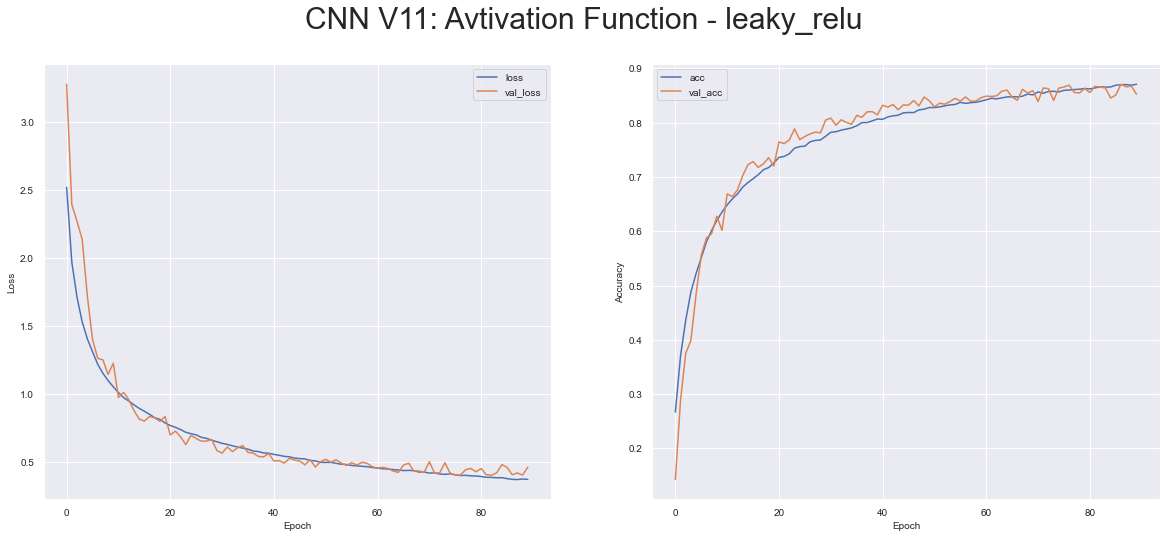

In [90]:
plot_loss_accraucy_graph(CNN_v11_history, "CNN V11: Avtivation Function - leaky_relu")

In [91]:
eval_CNN_model(CNN_v11,"CNN V11: Avtivation Function - leaky_relu")

313/313 [==============================] - 1s 1ms/step
CNN CNN V11: Avtivation Function - leaky_relu Training Data Accuracy: 90.82 %
CNN CNN V11: Avtivation Function - leaky_relu Testing Data Accuracy: 85.26 %
CNN CNN V11: Avtivation Function - leaky_relu F1-Score: 0.853


array([3, 8, 1, ..., 5, 1, 7], dtype=int64)

#### 5.3.13.2 Fine - Tuning Model: Conovltional Layers Activation Function = tanh

In [92]:
CNN_v12 = Sequential()
CNN_v12.add(Conv2D(64, (3, 3), activation='tanh',padding='same', input_shape=(32, 32,1))) #tanh activation function
CNN_v12.add(BatchNormalization())
CNN_v12.add(Conv2D(64, (3, 3), activation='tanh',padding='same')) #tanh activation function
CNN_v12.add(BatchNormalization())
CNN_v12.add(MaxPooling2D((2, 2)))
CNN_v12.add((Dropout(0.3)))

CNN_v12.add(Conv2D(128, (3, 3), activation='tanh',padding='same')) #tanh activation function
CNN_v12.add(BatchNormalization())
CNN_v12.add(Conv2D(128, (3, 3), activation='tanh',padding='same')) #tanh activation function
CNN_v12.add(BatchNormalization())
CNN_v12.add(MaxPooling2D((2, 2)))
CNN_v12.add((Dropout(0.4)))

CNN_v12.add(Conv2D(256, (3, 3), activation='tanh',padding='same')) #tanh activation function
CNN_v12.add(BatchNormalization())
CNN_v12.add(Conv2D(256, (3, 3), activation='tanh',padding='same')) #tanh activation function
CNN_v12.add(BatchNormalization())
CNN_v12.add(MaxPooling2D((2, 2)))
CNN_v12.add((Dropout(0.3)))

CNN_v12.add(Flatten())
CNN_v12.add(Dense(256, activation='relu'))
CNN_v12.add(BatchNormalization())
CNN_v12.add((Dropout(0.5)))
CNN_v12.add(Dense(10, activation='softmax'))
CNN_v12.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_102 (Conv2D)         (None, 32, 32, 64)        640       
                                                                 
 batch_normalization_119 (Ba  (None, 32, 32, 64)       256       
 tchNormalization)                                               
                                                                 
 conv2d_103 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_120 (Ba  (None, 32, 32, 64)       256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                     

In [93]:
CNN_v12.compile(optimizer=adam_optimizer_learning_rate_8, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_v12_history = CNN_v12.fit(augmented_train_batchsize_128, epochs=500, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/500
391/391 [==============================] - 7s 16ms/step - loss: 2.6596 - accuracy: 0.2105 - val_loss: 3.4069 - val_accuracy: 0.2234
Epoch 2/500
391/391 [==============================] - 6s 16ms/step - loss: 2.0898 - accuracy: 0.3051 - val_loss: 3.8850 - val_accuracy: 0.1967
Epoch 3/500
391/391 [==============================] - 6s 16ms/step - loss: 1.8247 - accuracy: 0.3693 - val_loss: 3.4221 - val_accuracy: 0.2420
Epoch 4/500
391/391 [==============================] - 6s 16ms/step - loss: 1.6605 - accuracy: 0.4170 - val_loss: 2.0186 - val_accuracy: 0.3907
Epoch 5/500
391/391 [==============================] - 6s 16ms/step - loss: 1.5426 - accuracy: 0.4586 - val_loss: 2.0338 - val_accuracy: 0.3964
Epoch 6/500
391/391 [==============================] - 6s 17ms/step - loss: 1.4463 - accuracy: 0.4907 - val_loss: 1.8436 - val_accuracy: 0.4743
Epoch 7/500
391/391 [==============================] - 7s 17ms/step - loss: 1.3539 - accuracy: 0.5208 - val_loss: 1.7680 - val_accuracy:

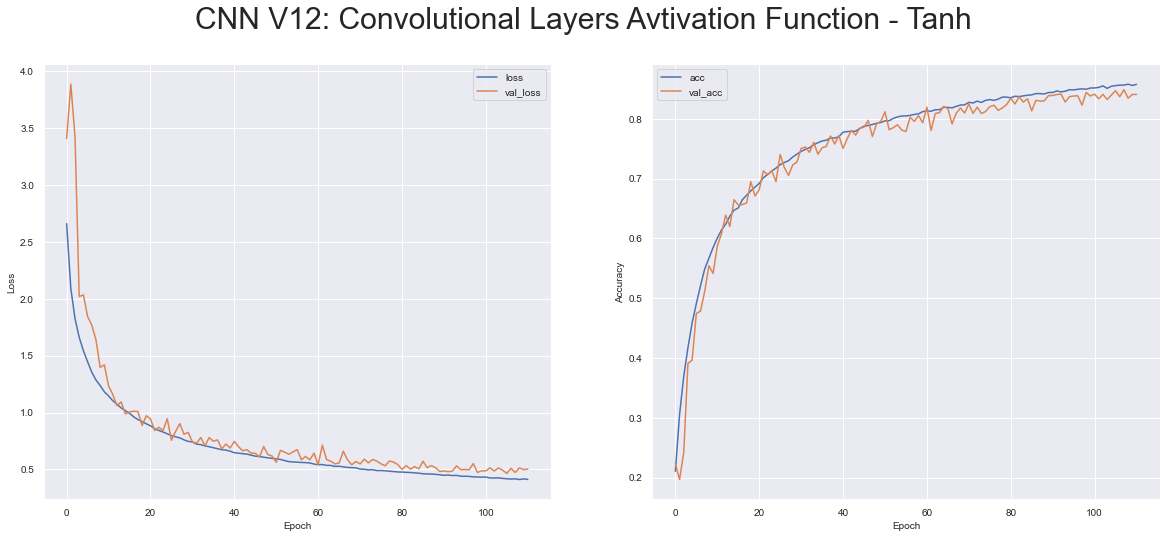

In [94]:
plot_loss_accraucy_graph(CNN_v12_history, "CNN V12: Convolutional Layers Avtivation Function - Tanh")

In [95]:
eval_CNN_model(CNN_v12,"CNN V12: Convolutional Layers Avtivation Function - Tanh")

313/313 [==============================] - 0s 1ms/step
CNN CNN V12: Convolutional Layers Avtivation Function - Tanh Training Data Accuracy: 89.6 %
CNN CNN V12: Convolutional Layers Avtivation Function - Tanh Testing Data Accuracy: 84.06 %
CNN CNN V12: Convolutional Layers Avtivation Function - Tanh F1-Score: 0.839


array([6, 8, 8, ..., 5, 1, 7], dtype=int64)

#### 5.3.13.3 Fine - Tuning Model: Conovltional Layers Activation Function = sigmoid

In [96]:
CNN_v13 = Sequential()
CNN_v13.add(Conv2D(64, (3, 3), activation='sigmoid',padding='same', input_shape=(32, 32,1))) #sigmoid activation function
CNN_v13.add(BatchNormalization())
CNN_v13.add(Conv2D(64, (3, 3), activation='sigmoid',padding='same')) #sigmoid activation function
CNN_v13.add(BatchNormalization())
CNN_v13.add(MaxPooling2D((2, 2)))
CNN_v13.add((Dropout(0.3)))

CNN_v13.add(Conv2D(128, (3, 3), activation='sigmoid',padding='same')) #sigmoid activation function
CNN_v13.add(BatchNormalization())
CNN_v13.add(Conv2D(128, (3, 3), activation='sigmoid',padding='same')) #sigmoid activation function
CNN_v13.add(BatchNormalization())
CNN_v13.add(MaxPooling2D((2, 2)))
CNN_v13.add((Dropout(0.4)))

CNN_v13.add(Conv2D(256, (3, 3), activation='sigmoid',padding='same')) #sigmoid activation function
CNN_v13.add(BatchNormalization())
CNN_v13.add(Conv2D(256, (3, 3), activation='sigmoid',padding='same')) #sigmoid activation function
CNN_v13.add(BatchNormalization())
CNN_v13.add(MaxPooling2D((2, 2)))
CNN_v13.add((Dropout(0.3)))

CNN_v13.add(Flatten())
CNN_v13.add(Dense(256, activation='relu'))
CNN_v13.add(BatchNormalization())
CNN_v13.add((Dropout(0.5)))
CNN_v13.add(Dense(10, activation='softmax'))
CNN_v13.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_108 (Conv2D)         (None, 32, 32, 64)        640       
                                                                 
 batch_normalization_126 (Ba  (None, 32, 32, 64)       256       
 tchNormalization)                                               
                                                                 
 conv2d_109 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_127 (Ba  (None, 32, 32, 64)       256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                     

In [97]:
CNN_v13.compile(optimizer=adam_optimizer_learning_rate_8, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_v13_history = CNN_v13.fit(augmented_train_batchsize_128, epochs=500, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/500
391/391 [==============================] - 7s 16ms/step - loss: 2.5996 - accuracy: 0.2359 - val_loss: 8.4351 - val_accuracy: 0.1000
Epoch 2/500
391/391 [==============================] - 6s 15ms/step - loss: 2.0177 - accuracy: 0.3321 - val_loss: 3.7273 - val_accuracy: 0.1800
Epoch 3/500
391/391 [==============================] - 6s 15ms/step - loss: 1.8175 - accuracy: 0.3845 - val_loss: 3.9718 - val_accuracy: 0.1812
Epoch 4/500
391/391 [==============================] - 6s 16ms/step - loss: 1.6499 - accuracy: 0.4308 - val_loss: 2.2617 - val_accuracy: 0.3937
Epoch 5/500
391/391 [==============================] - 6s 17ms/step - loss: 1.5173 - accuracy: 0.4716 - val_loss: 2.1848 - val_accuracy: 0.4032
Epoch 6/500
391/391 [==============================] - 7s 17ms/step - loss: 1.4301 - accuracy: 0.5004 - val_loss: 1.8939 - val_accuracy: 0.4424
Epoch 7/500
391/391 [==============================] - 6s 17ms/step - loss: 1.3564 - accuracy: 0.5231 - val_loss: 1.5607 - val_accuracy:

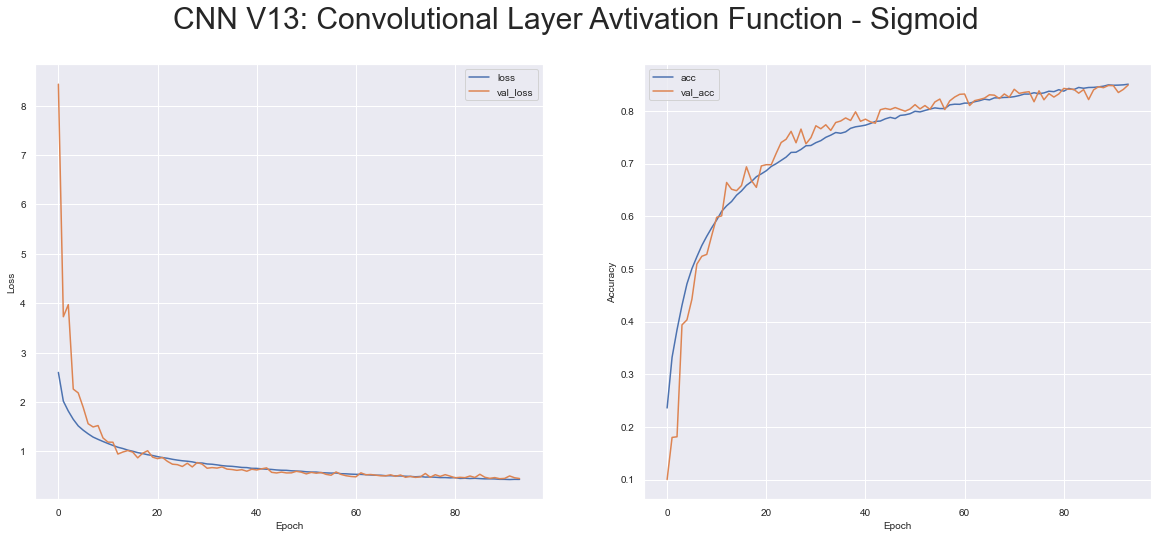

In [98]:
plot_loss_accraucy_graph(CNN_v13_history, "CNN V13: Convolutional Layer Avtivation Function - Sigmoid")

In [99]:
eval_CNN_model(CNN_v13,"CNN V13: Convolutional Layer Activation Function - Sigmoid")

313/313 [==============================] - 0s 1ms/step
CNN CNN V13: Convolutional Layer Activation Function - Sigmoid Training Data Accuracy: 90.78 %
CNN CNN V13: Convolutional Layer Activation Function - Sigmoid Testing Data Accuracy: 84.94 %
CNN CNN V13: Convolutional Layer Activation Function - Sigmoid F1-Score: 0.848


array([3, 8, 8, ..., 5, 1, 7], dtype=int64)

####  Model Summary - Convolutional Layer Activation Function

<table>
    <th> Activation Function </th>
    <th> Test Accuracy </th> 
    <th> Test F1-Score </th>
    <th> Train Loss vs Validation Loss </th>
    <th> Train Accuracy vs Validation Accuracy </th>
    <tr>
        <td> Relu </td>
        <td> 87.24% </td>
        <td> 0.872 </td>
        <td> Comparatively higher variance </td>
        <td> - </td>
    </tr>
     <tr>
        <td> Tanh </td>
        <td> 84.06% </td>
        <td> 0.839 </td>
        <td> Minimal variance </td>
        <td> - </td>
    </tr>
    <tr>
        <td> Sigmoid </td>
        <td> 84.94% </td>
        <td> 0.848 </td>
        <td> Minimal variance </td>
        <td> Overfitting </td>
    </tr>
    <tr>
        <td> Leaky Relu </td>
        <td> 87.43% </td>
        <td> 0.874 </td>
        <td> Minimal variance </td>
        <td> Overfitting</td>
    </tr>
 </table>
   
 I ran 4 different types of activation functions for the convolutional layers and the results are shown in the table above. For the tanh and sigmoid activation function, the loss has significantly reduce and there minimal variance between the as there is minute differences between training & validation error. However, this is at the cost of the accuracy and f1-score which dropped by 3% and 0.03 respectively. Hence, I will continue using the relu activation function as the leaky relu activation function is causing overfitting. Therefore, the results is the same as the previous model

### 5.3.14  Fine - Tuning Model: Dense Layer Activation Function

#### 5.3.14.1  Fine - Tuning Model: Dense Layer Activation Function = sigmoid

In [100]:
CNN_v14 = Sequential()
CNN_v14.add(Conv2D(64, (3, 3), activation='relu',padding='same', input_shape=(32, 32,1)))
CNN_v14.add(BatchNormalization())
CNN_v14.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
CNN_v14.add(BatchNormalization())
CNN_v14.add(MaxPooling2D((2, 2)))
CNN_v14.add((Dropout(0.3)))

CNN_v14.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
CNN_v14.add(BatchNormalization())
CNN_v14.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
CNN_v14.add(BatchNormalization())
CNN_v14.add(MaxPooling2D((2, 2)))
CNN_v14.add((Dropout(0.4)))

CNN_v14.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
CNN_v14.add(BatchNormalization())
CNN_v14.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
CNN_v14.add(BatchNormalization())
CNN_v14.add(MaxPooling2D((2, 2)))
CNN_v14.add((Dropout(0.3)))

CNN_v14.add(Flatten())
CNN_v14.add(Dense(256, activation='sigmoid')) #sigmoid activation function
CNN_v14.add(BatchNormalization())
CNN_v14.add((Dropout(0.5)))
CNN_v14.add(Dense(10, activation='softmax'))
CNN_v14.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_114 (Conv2D)         (None, 32, 32, 64)        640       
                                                                 
 batch_normalization_133 (Ba  (None, 32, 32, 64)       256       
 tchNormalization)                                               
                                                                 
 conv2d_115 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_134 (Ba  (None, 32, 32, 64)       256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                     

In [101]:
CNN_v14.compile(optimizer=adam_optimizer_learning_rate_8, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_v14_history= CNN_v14.fit(augmented_train_batchsize_128, epochs=500, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/500
391/391 [==============================] - 7s 15ms/step - loss: 2.5655 - accuracy: 0.2663 - val_loss: 3.7413 - val_accuracy: 0.1157
Epoch 2/500
391/391 [==============================] - 6s 15ms/step - loss: 2.0264 - accuracy: 0.3595 - val_loss: 2.7031 - val_accuracy: 0.3155
Epoch 3/500
391/391 [==============================] - 6s 15ms/step - loss: 1.7187 - accuracy: 0.4258 - val_loss: 2.4181 - val_accuracy: 0.3503
Epoch 4/500
391/391 [==============================] - 6s 15ms/step - loss: 1.5339 - accuracy: 0.4739 - val_loss: 2.1239 - val_accuracy: 0.4140
Epoch 5/500
391/391 [==============================] - 6s 15ms/step - loss: 1.4015 - accuracy: 0.5145 - val_loss: 1.8311 - val_accuracy: 0.4593
Epoch 6/500
391/391 [==============================] - 6s 15ms/step - loss: 1.2981 - accuracy: 0.5472 - val_loss: 1.4874 - val_accuracy: 0.5408
Epoch 7/500
391/391 [==============================] - 6s 16ms/step - loss: 1.2212 - accuracy: 0.5751 - val_loss: 1.4442 - val_accuracy:

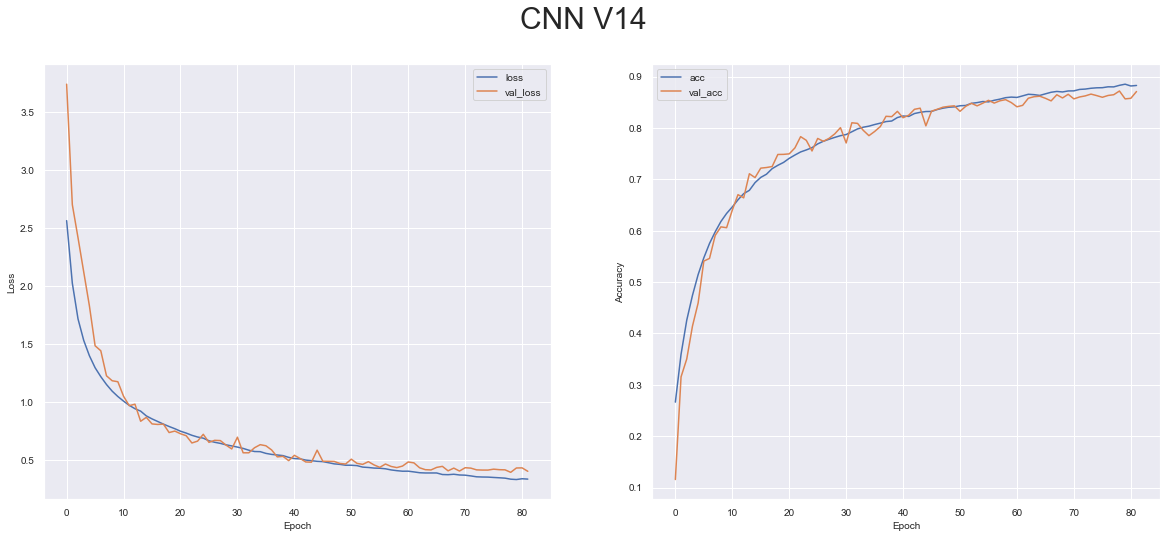

In [102]:
plot_loss_accraucy_graph(CNN_v14_history, "CNN V14: Dense Layer Activation Function = sigmoid")

In [103]:
eval_CNN_model(CNN_v14,"CNN V14: Dense Layer Avtivation Function - Sigmoid")

313/313 [==============================] - 0s 1ms/step
CNN CNN V14: Dense Layer Avtivation Function - Sigmoid Training Data Accuracy: 93.46 %
CNN CNN V14: Dense Layer Avtivation Function - Sigmoid Testing Data Accuracy: 87.08 %
CNN CNN V14: Dense Layer Avtivation Function - Sigmoid F1-Score: 0.87


array([3, 8, 1, ..., 5, 1, 7], dtype=int64)

#### 5.3.14.2  Fine - Tuning Model: Dense Layer Activation Function = Tanh

In [108]:
CNN_v15 = Sequential()
CNN_v15.add(Conv2D(64, (3, 3), activation='relu',padding='same', input_shape=(32, 32,1)))
CNN_v15.add(BatchNormalization())
CNN_v15.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
CNN_v15.add(BatchNormalization())
CNN_v15.add(MaxPooling2D((2, 2)))
CNN_v15.add((Dropout(0.3)))

CNN_v15.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
CNN_v15.add(BatchNormalization())
CNN_v15.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
CNN_v15.add(BatchNormalization())
CNN_v15.add(MaxPooling2D((2, 2)))
CNN_v15.add((Dropout(0.4)))

CNN_v15.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
CNN_v15.add(BatchNormalization())
CNN_v15.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
CNN_v15.add(BatchNormalization())
CNN_v15.add(MaxPooling2D((2, 2)))
CNN_v15.add((Dropout(0.3)))

CNN_v15.add(Flatten())
CNN_v15.add(Dense(256, activation='tanh')) #tanh activation function
CNN_v15.add(BatchNormalization())
CNN_v15.add((Dropout(0.5)))
CNN_v15.add(Dense(10, activation='softmax'))
CNN_v15.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_126 (Conv2D)         (None, 32, 32, 64)        640       
                                                                 
 batch_normalization_147 (Ba  (None, 32, 32, 64)       256       
 tchNormalization)                                               
                                                                 
 conv2d_127 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_148 (Ba  (None, 32, 32, 64)       256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                     

In [109]:
CNN_v15.compile(optimizer=adam_optimizer_learning_rate_8, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_v15_history= CNN_v15.fit(augmented_train_batchsize_128, epochs=500, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/500
391/391 [==============================] - 7s 17ms/step - loss: 2.6733 - accuracy: 0.2474 - val_loss: 5.6024 - val_accuracy: 0.1055
Epoch 2/500
391/391 [==============================] - 6s 16ms/step - loss: 2.0852 - accuracy: 0.3377 - val_loss: 2.3396 - val_accuracy: 0.3457
Epoch 3/500
391/391 [==============================] - 6s 16ms/step - loss: 1.8364 - accuracy: 0.3880 - val_loss: 2.3445 - val_accuracy: 0.3756
Epoch 4/500
391/391 [==============================] - 6s 17ms/step - loss: 1.6596 - accuracy: 0.4297 - val_loss: 2.0247 - val_accuracy: 0.4204
Epoch 5/500
391/391 [==============================] - 6s 16ms/step - loss: 1.5138 - accuracy: 0.4741 - val_loss: 1.7174 - val_accuracy: 0.4981
Epoch 6/500
391/391 [==============================] - 6s 16ms/step - loss: 1.4134 - accuracy: 0.5062 - val_loss: 1.6543 - val_accuracy: 0.5001
Epoch 7/500
391/391 [==============================] - 6s 16ms/step - loss: 1.3304 - accuracy: 0.5343 - val_loss: 1.4474 - val_accuracy:

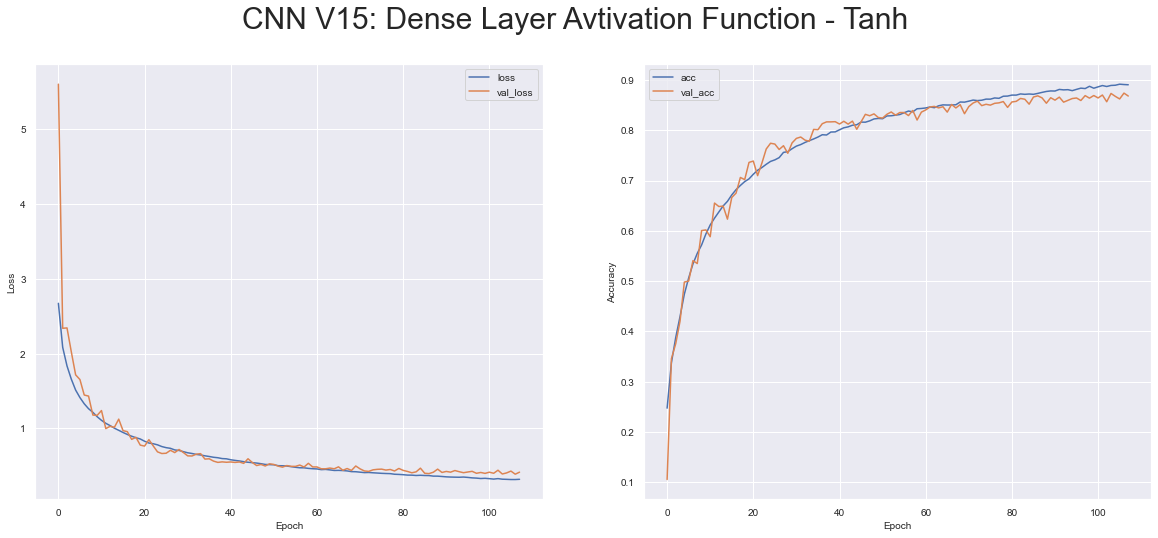

In [209]:
plot_loss_accraucy_graph(CNN_v15_history, "CNN V15: Dense Layer Avtivation Function - Tanh")

In [111]:
eval_CNN_model(CNN_v15,"CNN V15: Dense Layer Avtivation Function - Tanh")

313/313 [==============================] - 0s 1ms/step
CNN CNN V15: Dense Layer Avtivation Function - Tanh Training Data Accuracy: 93.34 %
CNN CNN V15: Dense Layer Avtivation Function - Tanh Testing Data Accuracy: 86.8 %
CNN CNN V15: Dense Layer Avtivation Function - Tanh F1-Score: 0.868


array([3, 8, 8, ..., 5, 1, 7], dtype=int64)

####  Model Summary - Dense Layer Activation Function

<table>
    <th> Activation Function </th>
    <th> Test Accuracy </th> 
    <th> Test F1-Score </th>
    <th> Train Loss vs Validation Loss </th>
    <th> Train Accuracy vs Validation Accuracy </th>
    <tr>
        <td> Relu </td>
        <td> 87.24% </td>
        <td> 0.872 </td>
        <td> Comparatively higher variance </td>
        <td> - </td>
    </tr>
     <tr>
        <td> Tanh </td>
        <td> 86.8% </td>
        <td> 0.868 </td>
        <td> Minimal variance </td>
        <td> - </td>
    </tr>
    <tr>
        <td> Sigmoid </td>
        <td> 87.08% </td>
        <td> 0.87 </td>
        <td> Minimal variance </td>
        <td> Close to overfitting </td>
    </tr>

 </table>
   
 I ran 3 different types of activation functions for the dense layers and the results are shown in the table above. Although the performance of the relu activation is the best, the model has a comparatively higher vairance. For the tanh and sigmoid activation function, the loss has significantly reduced and there minimal variance between the as there is minute differences between training & validation error. Furthermore, the accuracy and f1-score are high and similar. Although the sigmoid activation function gives a higher accuracy and f1-score compared to tanh, the graph shows that the validation accraucy is close to overfitting. Hence, the final activation function is tanh.

### 5.4 Final Model

In [43]:
CNN_final = Sequential()
CNN_final.add(Conv2D(64, (3, 3), activation='relu',padding='same', input_shape=(32, 32,1)))
CNN_final.add(BatchNormalization())
CNN_final.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
CNN_final.add(BatchNormalization())
CNN_final.add(MaxPooling2D((2, 2)))
CNN_final.add((Dropout(0.3)))

CNN_final.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
CNN_final.add(BatchNormalization())
CNN_final.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
CNN_final.add(BatchNormalization())
CNN_final.add(MaxPooling2D((2, 2)))
CNN_final.add((Dropout(0.4)))

CNN_final.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
CNN_final.add(BatchNormalization())
CNN_final.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
CNN_final.add(BatchNormalization())
CNN_final.add(MaxPooling2D((2, 2)))
CNN_final.add((Dropout(0.3)))

CNN_final.add(Flatten())
CNN_final.add(Dense(256, activation='tanh'))
CNN_final.add(BatchNormalization())
CNN_final.add((Dropout(0.5)))
CNN_final.add(Dense(10, activation='softmax'))
CNN_final.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 32, 32, 64)        640       
                                                                 
 batch_normalization_28 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_29 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                      

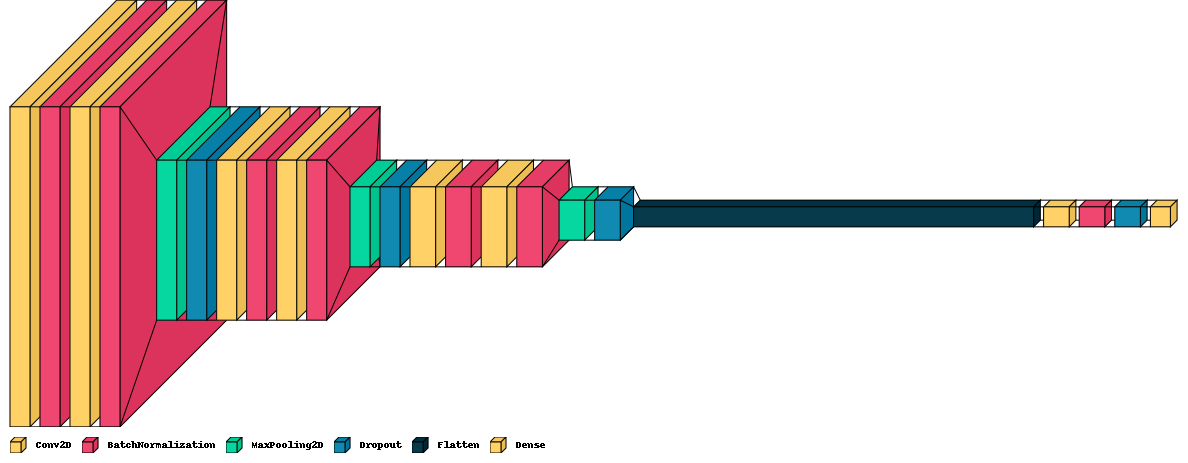

In [44]:
visualkeras.layered_view(CNN_final, scale_xy=10, legend=True)

In [45]:
augmented_train_batchsize_128 = Data_Generator.flow(X_train, y_train,batch_size=128)
adam_optimizer_learning_rate_8 =tf.keras.optimizers.Adam( learning_rate=1e-4)
CNN_final.compile(optimizer=adam_optimizer_learning_rate_8, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_final_history= CNN_final.fit(augmented_train_batchsize_128, epochs=500, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/500
391/391 [==============================] - 10s 23ms/step - loss: 2.7014 - accuracy: 0.2398 - val_loss: 5.4654 - val_accuracy: 0.1000
Epoch 2/500
391/391 [==============================] - 9s 22ms/step - loss: 2.1380 - accuracy: 0.3274 - val_loss: 2.2262 - val_accuracy: 0.3532
Epoch 3/500
391/391 [==============================] - 9s 22ms/step - loss: 1.8790 - accuracy: 0.3709 - val_loss: 1.9865 - val_accuracy: 0.4016
Epoch 4/500
391/391 [==============================] - 8s 20ms/step - loss: 1.6982 - accuracy: 0.4172 - val_loss: 1.9401 - val_accuracy: 0.4112
Epoch 5/500
391/391 [==============================] - 9s 22ms/step - loss: 1.5423 - accuracy: 0.4638 - val_loss: 1.6921 - val_accuracy: 0.4752
Epoch 6/500
391/391 [==============================] - 9s 23ms/step - loss: 1.4292 - accuracy: 0.4994 - val_loss: 1.4074 - val_accuracy: 0.5535
Epoch 7/500
391/391 [==============================] - 9s 23ms/step - loss: 1.3458 - accuracy: 0.5276 - val_loss: 1.4866 - val_accuracy

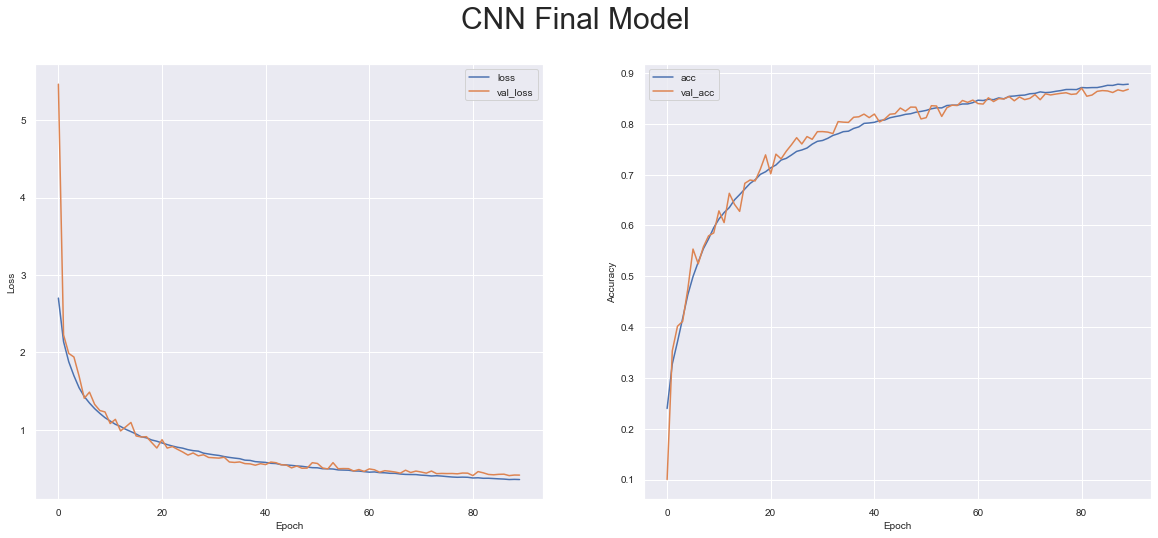

In [50]:
plot_loss_accraucy_graph(CNN_final_history, "CNN Final Model")

In [47]:
cnn_final_predictions = eval_CNN_model(CNN_final,"CNN Final Model")

313/313 [==============================] - 1s 2ms/step
CNN CNN Final Model Training Data Accuracy: 92.57 %
CNN CNN Final Model Testing Data Accuracy: 86.79 %
CNN CNN Final Model Testing Data F1-Score: 0.867


              precision    recall  f1-score   support

           0       0.82      0.94      0.88       868
           1       0.94      0.95      0.95       987
           2       0.77      0.85      0.81       912
           3       0.68      0.83      0.75       824
           4       0.88      0.79      0.83      1121
           5       0.83      0.81      0.82      1017
           6       0.95      0.80      0.87      1190
           7       0.92      0.90      0.91      1020
           8       0.93      0.93      0.93      1006
           9       0.95      0.90      0.92      1055

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

---------------------------------------------------------------


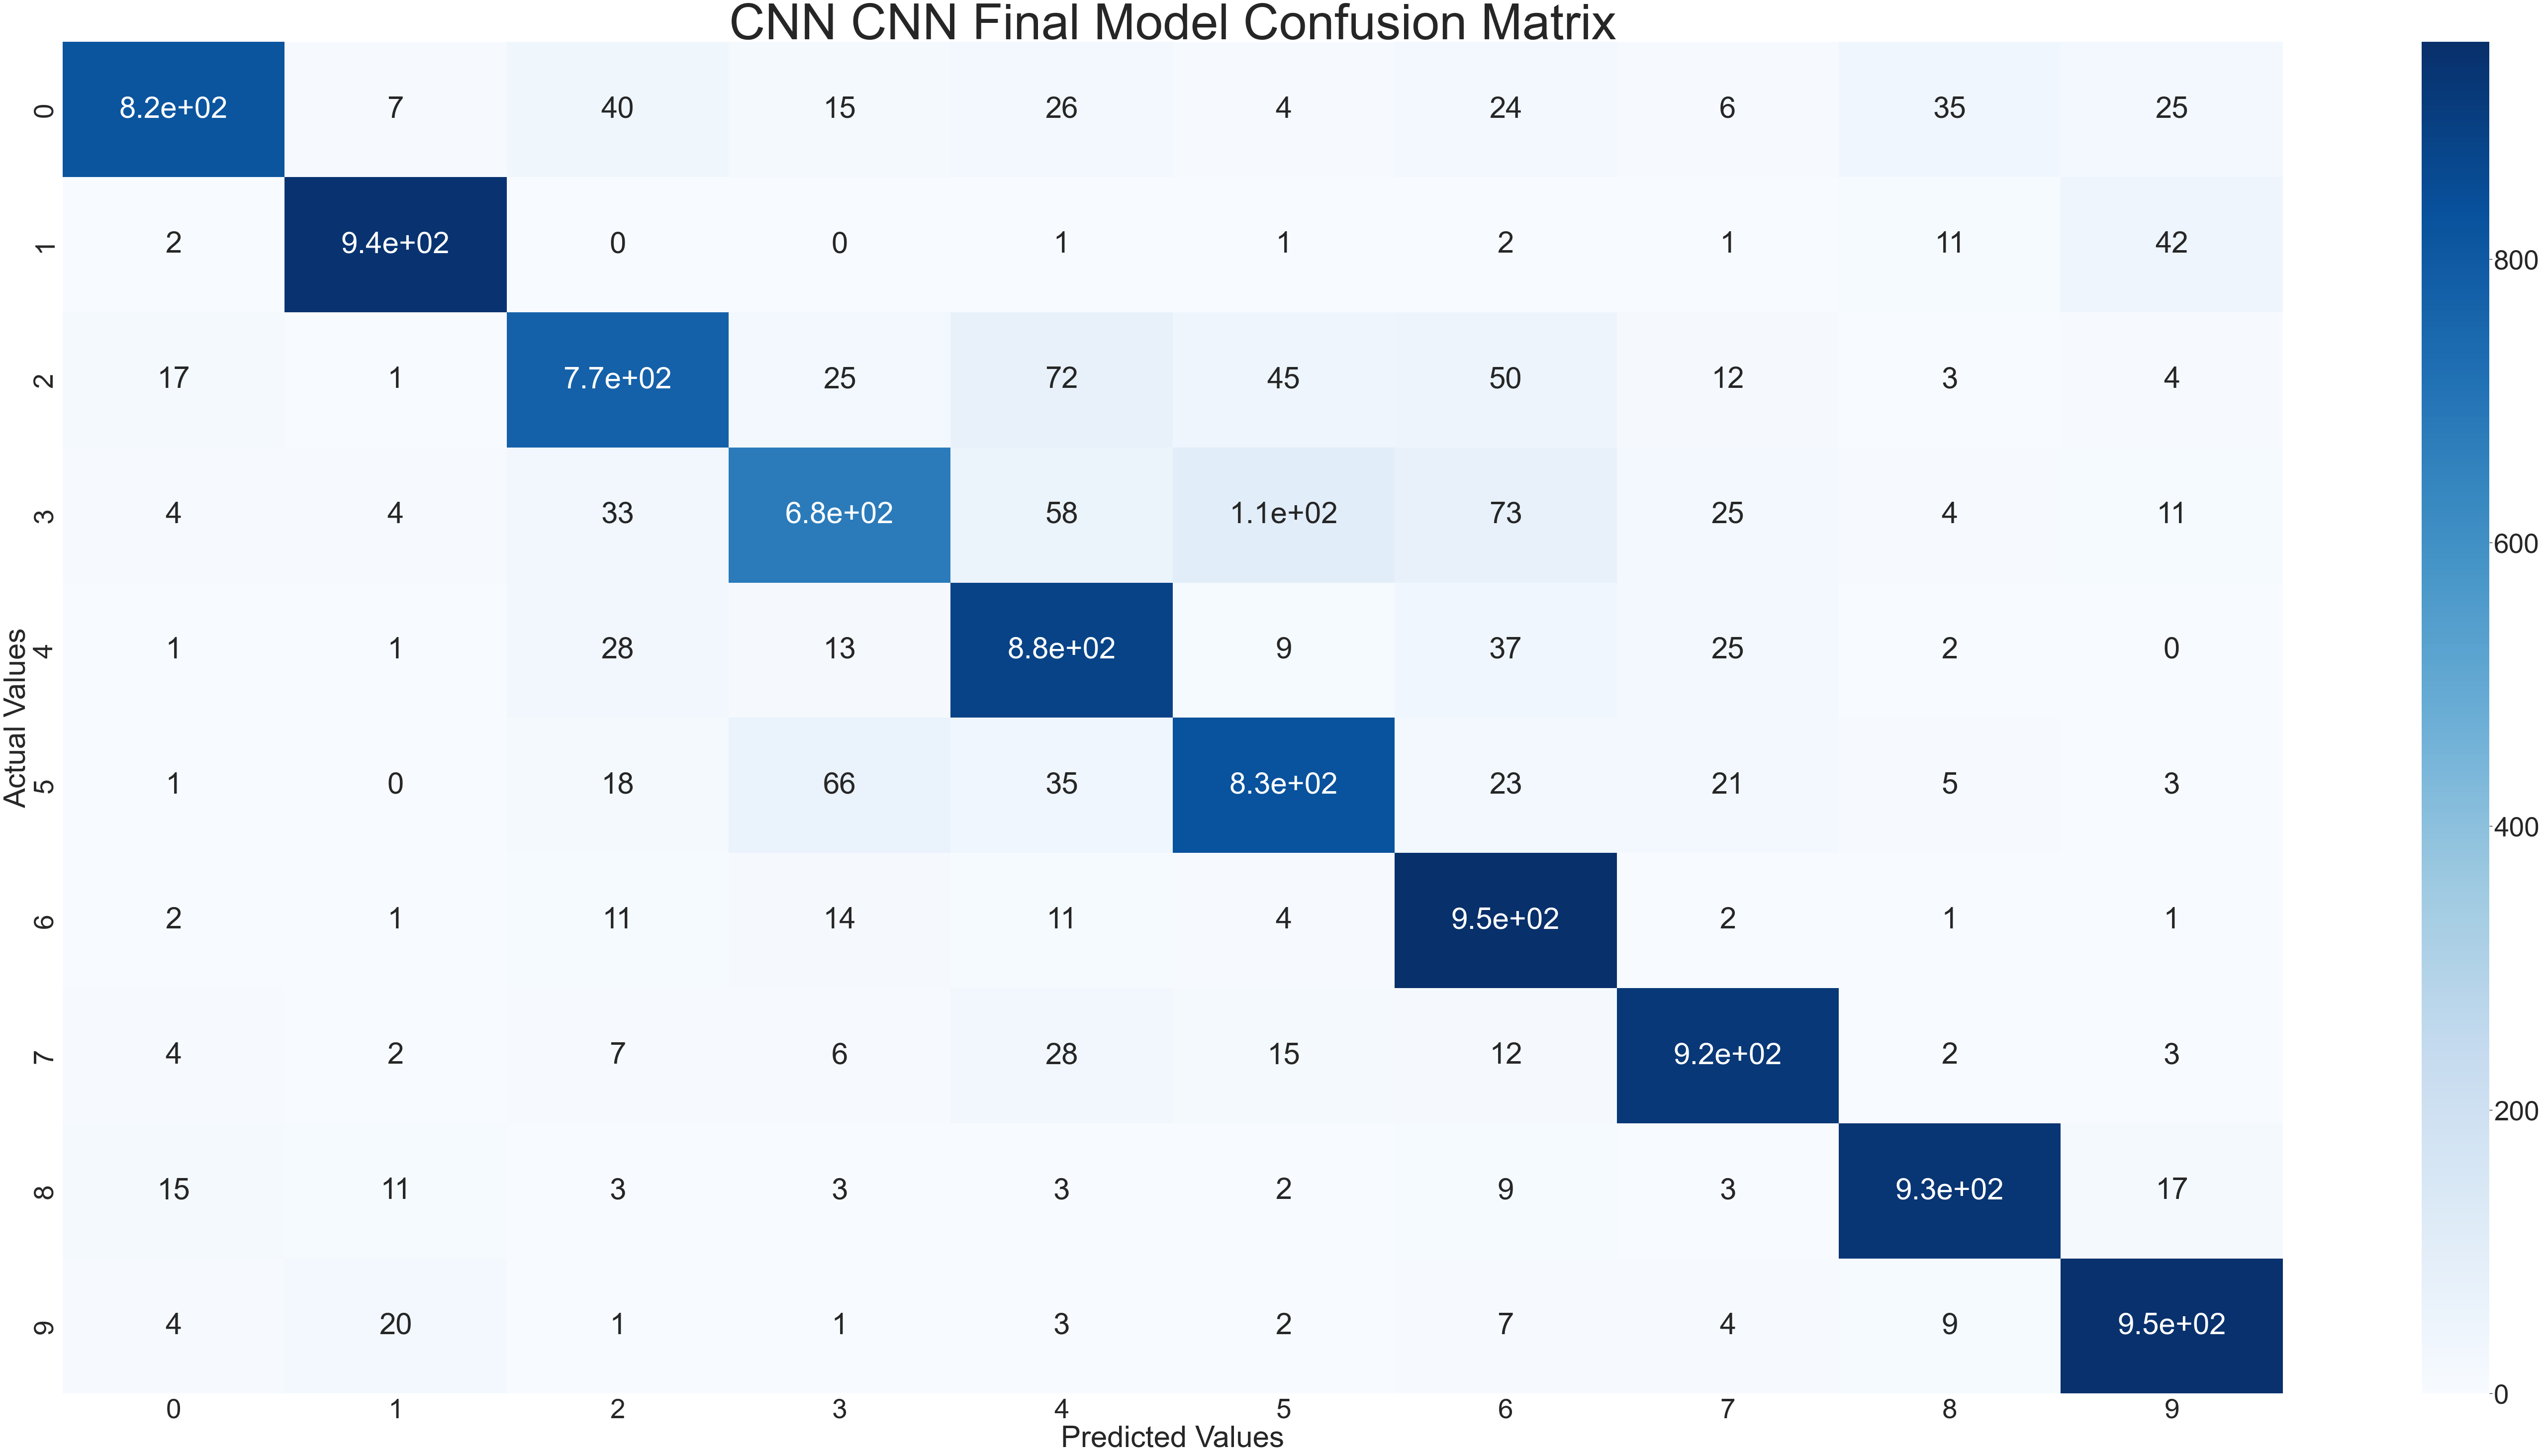

In [48]:
confusion_matrix_classification_report(cnn_final_predictions,"CNN Final Model")

The performance of the model is good. The accuracy of the model on the test data is 86.795. Initially, the model was overfitting but towards the last 20 epochs, it became the right fit. There is also very minimal variance between the training loss and validation loss. 

The f1-score on the test set is 0.867. This is a good score. Furthermore, based on the classification report, the model is perorming well across all classes with the recall,precision and f1-score above 0.8 for most classes. 

Class 3s' precision is 0.77. However, its recall is 0.85. In this case recall is more important than precision as we want to reduce the false negative rate.

Class 3 is generally misclassied as Class 5.This could be due to the average pixel instensity peaking between 113-117 as seen in the average pixel intensity histogram in Part 1.


This model is a major improvement from the initial model. The misclassification has also greatly reduced.

## 6. Train Final Model on Coloured CIFAR-10 Data

### 6.1 Read coloured CIFAR-10 File

In [6]:
#open and extract contents from tar file
tar = tarfile.open('cifar-10-python.tar.gz', "r:gz")
tar.extractall()
tar.close()

In [7]:
# read colored data using unpickle function
colored_train_batch1=unpickle("cifar-10-batches-py/data_batch_1")
colored_train_batch2=unpickle("cifar-10-batches-py/data_batch_2")
colored_train_batch3=unpickle("cifar-10-batches-py/data_batch_3")
colored_train_batch4=unpickle("cifar-10-batches-py/data_batch_4")
colored_train_batch5=unpickle("cifar-10-batches-py/data_batch_5")
colored_test_batch=unpickle("cifar-10-batches-py/test_batch")

### 6.2 Split coloured CIFAR-10 into X_train and X_test

In [10]:
#initialize empty list
coloured_x_data_temp=[] 
coloured_y_data_temp=[] 
coloured_x_test_data_temp=[] 
coloured_y_test_data_temp=[] 

#append data
coloured_x_data_temp.append(colored_train_batch1[b'data']) 
coloured_y_data_temp.append(colored_train_batch1[b'labels'])
coloured_x_data_temp.append(colored_train_batch2[b'data'])
coloured_y_data_temp.append(colored_train_batch2[b'labels'])
coloured_x_data_temp.append(colored_train_batch3[b'data'])
coloured_y_data_temp.append(colored_train_batch3[b'labels'])
coloured_x_data_temp.append(colored_train_batch4[b'data'])
coloured_y_data_temp.append(colored_train_batch4[b'labels'])
coloured_x_data_temp.append(colored_train_batch5[b'data'])
coloured_y_data_temp.append(colored_train_batch5[b'labels'])

coloured_x_test_data_temp.append(colored_test_batch[b'data'])
coloured_y_test_data_temp.append(colored_test_batch[b'labels'])

#convert to numpy array
coloured_x_data=np.array(x_data_temp)
coloured_y_data=np.array(y_data_temp)

coloured_x_test_data=np.array(x_test_data_temp)
coloured_y_test_data=np.array(y_test_data_temp)

### 6.3 Data Prepration on coloured CIFAR-10 datasets

#### 6.3.1 Data Prepration on coloured CIFAR-10 datasets - Reshape

In [11]:
coloured_x_train_1=x_data.reshape(coloured_x_data.shape[0]*coloured_x_data.shape[1],coloured_x_data.shape[2])
coloured_y_train_1=y_data.reshape(y_data.shape[0]*y_data.shape[1])

coloured_x_test_1=coloured_x_test_data.reshape(coloured_x_test_data.shape[0]*coloured_x_test_data.shape[1],coloured_x_test_data.shape[2])
coloured_y_test_1=coloured_y_test_data.reshape(coloured_y_test_data.shape[0]*coloured_y_test_data.shape[1])

coloured_X_train=coloured_x_train_1.reshape(coloured_x_train_1.shape[0],32,32,3)
colored_y_train=y_train_1

coloured_X_test=coloured_x_test_1.reshape(coloured_x_test_1.shape[0],32,32,3)
colored_y_test=coloured_y_test_1

#### 6.3.1 Data Prepration on coloured CIFAR-10 datasets - Normalize

In [12]:
colored_X_train=coloured_X_train.astype("float32")
colored_X_test=coloured_X_test.astype("float32")

colored_X_train = colored_X_train / 255
colored_X_test = colored_X_test / 255

### 6.4 Run Model on coloured CIFAR-10 datasets 

In [4]:
CNN_color = Sequential()
CNN_color.add(Conv2D(64, (3, 3), activation='relu',padding='same', input_shape=(32, 32,3)))
CNN_color.add(BatchNormalization())
CNN_color.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
CNN_color.add(BatchNormalization())
CNN_color.add(MaxPooling2D((2, 2)))
CNN_color.add((Dropout(0.3)))

CNN_color.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
CNN_color.add(BatchNormalization())
CNN_color.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
CNN_color.add(BatchNormalization())
CNN_color.add(MaxPooling2D((2, 2)))
CNN_color.add((Dropout(0.4)))

CNN_color.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
CNN_color.add(BatchNormalization())
CNN_color.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
CNN_color.add(BatchNormalization())
CNN_color.add(MaxPooling2D((2, 2)))
CNN_color.add((Dropout(0.3)))

CNN_color.add(Flatten())
CNN_color.add(Dense(256, activation='tanh'))
CNN_color.add(BatchNormalization())
CNN_color.add((Dropout(0.5)))
CNN_color.add(Dense(10, activation='softmax'))
CNN_color.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                        

In [10]:
adam_optimizer_learning_rate_8 =tf.keras.optimizers.Adam( learning_rate=1e-4)
CNN_color.compile(optimizer=adam_optimizer_learning_rate_8, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN_color_history= CNN_color.fit(colored_X_train, colored_y_train,batch_size=128, epochs=500, validation_data=(colored_X_test, colored_y_test),callbacks=[callback])

Epoch 1/500
391/391 [==============================] - 10s 14ms/step - loss: 2.4483 - accuracy: 0.2920 - val_loss: 1.7987 - val_accuracy: 0.4272
Epoch 2/500
391/391 [==============================] - 5s 12ms/step - loss: 1.8457 - accuracy: 0.4095 - val_loss: 1.7408 - val_accuracy: 0.4601
Epoch 3/500
391/391 [==============================] - 5s 12ms/step - loss: 1.5797 - accuracy: 0.4703 - val_loss: 1.5940 - val_accuracy: 0.5168
Epoch 4/500
391/391 [==============================] - 5s 13ms/step - loss: 1.3918 - accuracy: 0.5190 - val_loss: 1.4042 - val_accuracy: 0.5398
Epoch 5/500
391/391 [==============================] - 5s 13ms/step - loss: 1.2629 - accuracy: 0.5603 - val_loss: 1.3699 - val_accuracy: 0.5485
Epoch 6/500
391/391 [==============================] - 5s 12ms/step - loss: 1.1579 - accuracy: 0.5938 - val_loss: 1.3092 - val_accuracy: 0.5760
Epoch 7/500
391/391 [==============================] - 5s 12ms/step - loss: 1.0723 - accuracy: 0.6226 - val_loss: 1.2849 - val_accuracy

391/391 [==============================] - 5s 12ms/step - loss: 0.1741 - accuracy: 0.9393 - val_loss: 0.5091 - val_accuracy: 0.8598
Epoch 58/500
391/391 [==============================] - 5s 12ms/step - loss: 0.1663 - accuracy: 0.9404 - val_loss: 0.5023 - val_accuracy: 0.8631
Epoch 59/500
391/391 [==============================] - 5s 12ms/step - loss: 0.1592 - accuracy: 0.9433 - val_loss: 0.4919 - val_accuracy: 0.8633
Epoch 60/500
391/391 [==============================] - 5s 12ms/step - loss: 0.1584 - accuracy: 0.9446 - val_loss: 0.5249 - val_accuracy: 0.8550
Epoch 61/500
391/391 [==============================] - 5s 13ms/step - loss: 0.1501 - accuracy: 0.9468 - val_loss: 0.5148 - val_accuracy: 0.8598
Epoch 62/500
391/391 [==============================] - 5s 13ms/step - loss: 0.1482 - accuracy: 0.9474 - val_loss: 0.5689 - val_accuracy: 0.8471
Epoch 63/500
391/391 [==============================] - 5s 12ms/step - loss: 0.1440 - accuracy: 0.9498 - val_loss: 0.5006 - val_accuracy: 0.865

### 6.5 Evaluvate Model 

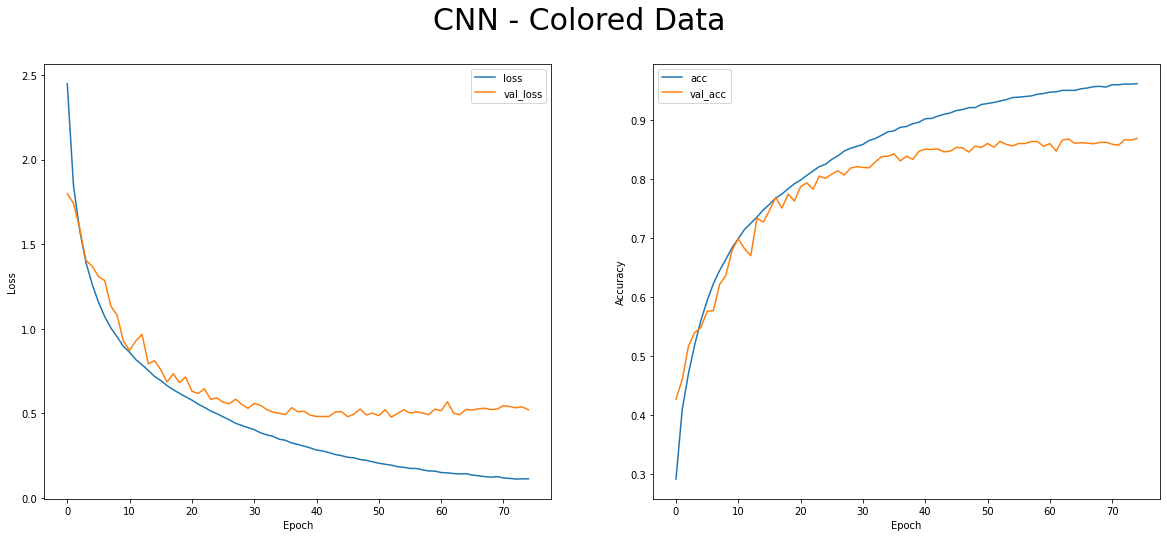

In [12]:
plot_loss_accraucy_graph(CNN_color_history, "CNN - Colored Data ")

In [14]:
_, CNN_colored_train_acc = CNN_color.evaluate(colored_X_train, colored_y_train, verbose=0)
_, CNN_colored_test_acc = CNN_color.evaluate(colored_X_test, colored_y_test, verbose=0)
CNN_colored_prediction=CNN_color.predict(colored_X_test).argmax(axis=1)
print('CNN {} Training Data Accuracy:'.format("Color"),round(CNN_colored_train_acc*100,2),"%")
print('CNN {} Testing Data Accuracy:'.format("Color"),round(CNN_colored_test_acc*100,2), '%')
print('CNN {} Testing Data F1-Score: {}'.format("Color",round(f1_score(colored_y_test, CNN_colored_prediction, average='macro'),3)))

313/313 [==============================] - 1s 2ms/step
CNN Color Training Data Accuracy: 99.78 %
CNN Color Testing Data Accuracy: 86.83 %
CNN Color Testing Data F1-Score: 0.868


In [15]:
print(classification_report(colored_y_test,CNN_colored_prediction,))

              precision    recall  f1-score   support

           0       0.91      0.84      0.87      1000
           1       0.94      0.93      0.94      1000
           2       0.86      0.78      0.82      1000
           3       0.76      0.73      0.74      1000
           4       0.80      0.90      0.85      1000
           5       0.79      0.83      0.81      1000
           6       0.91      0.89      0.90      1000
           7       0.90      0.91      0.90      1000
           8       0.91      0.94      0.92      1000
           9       0.92      0.93      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



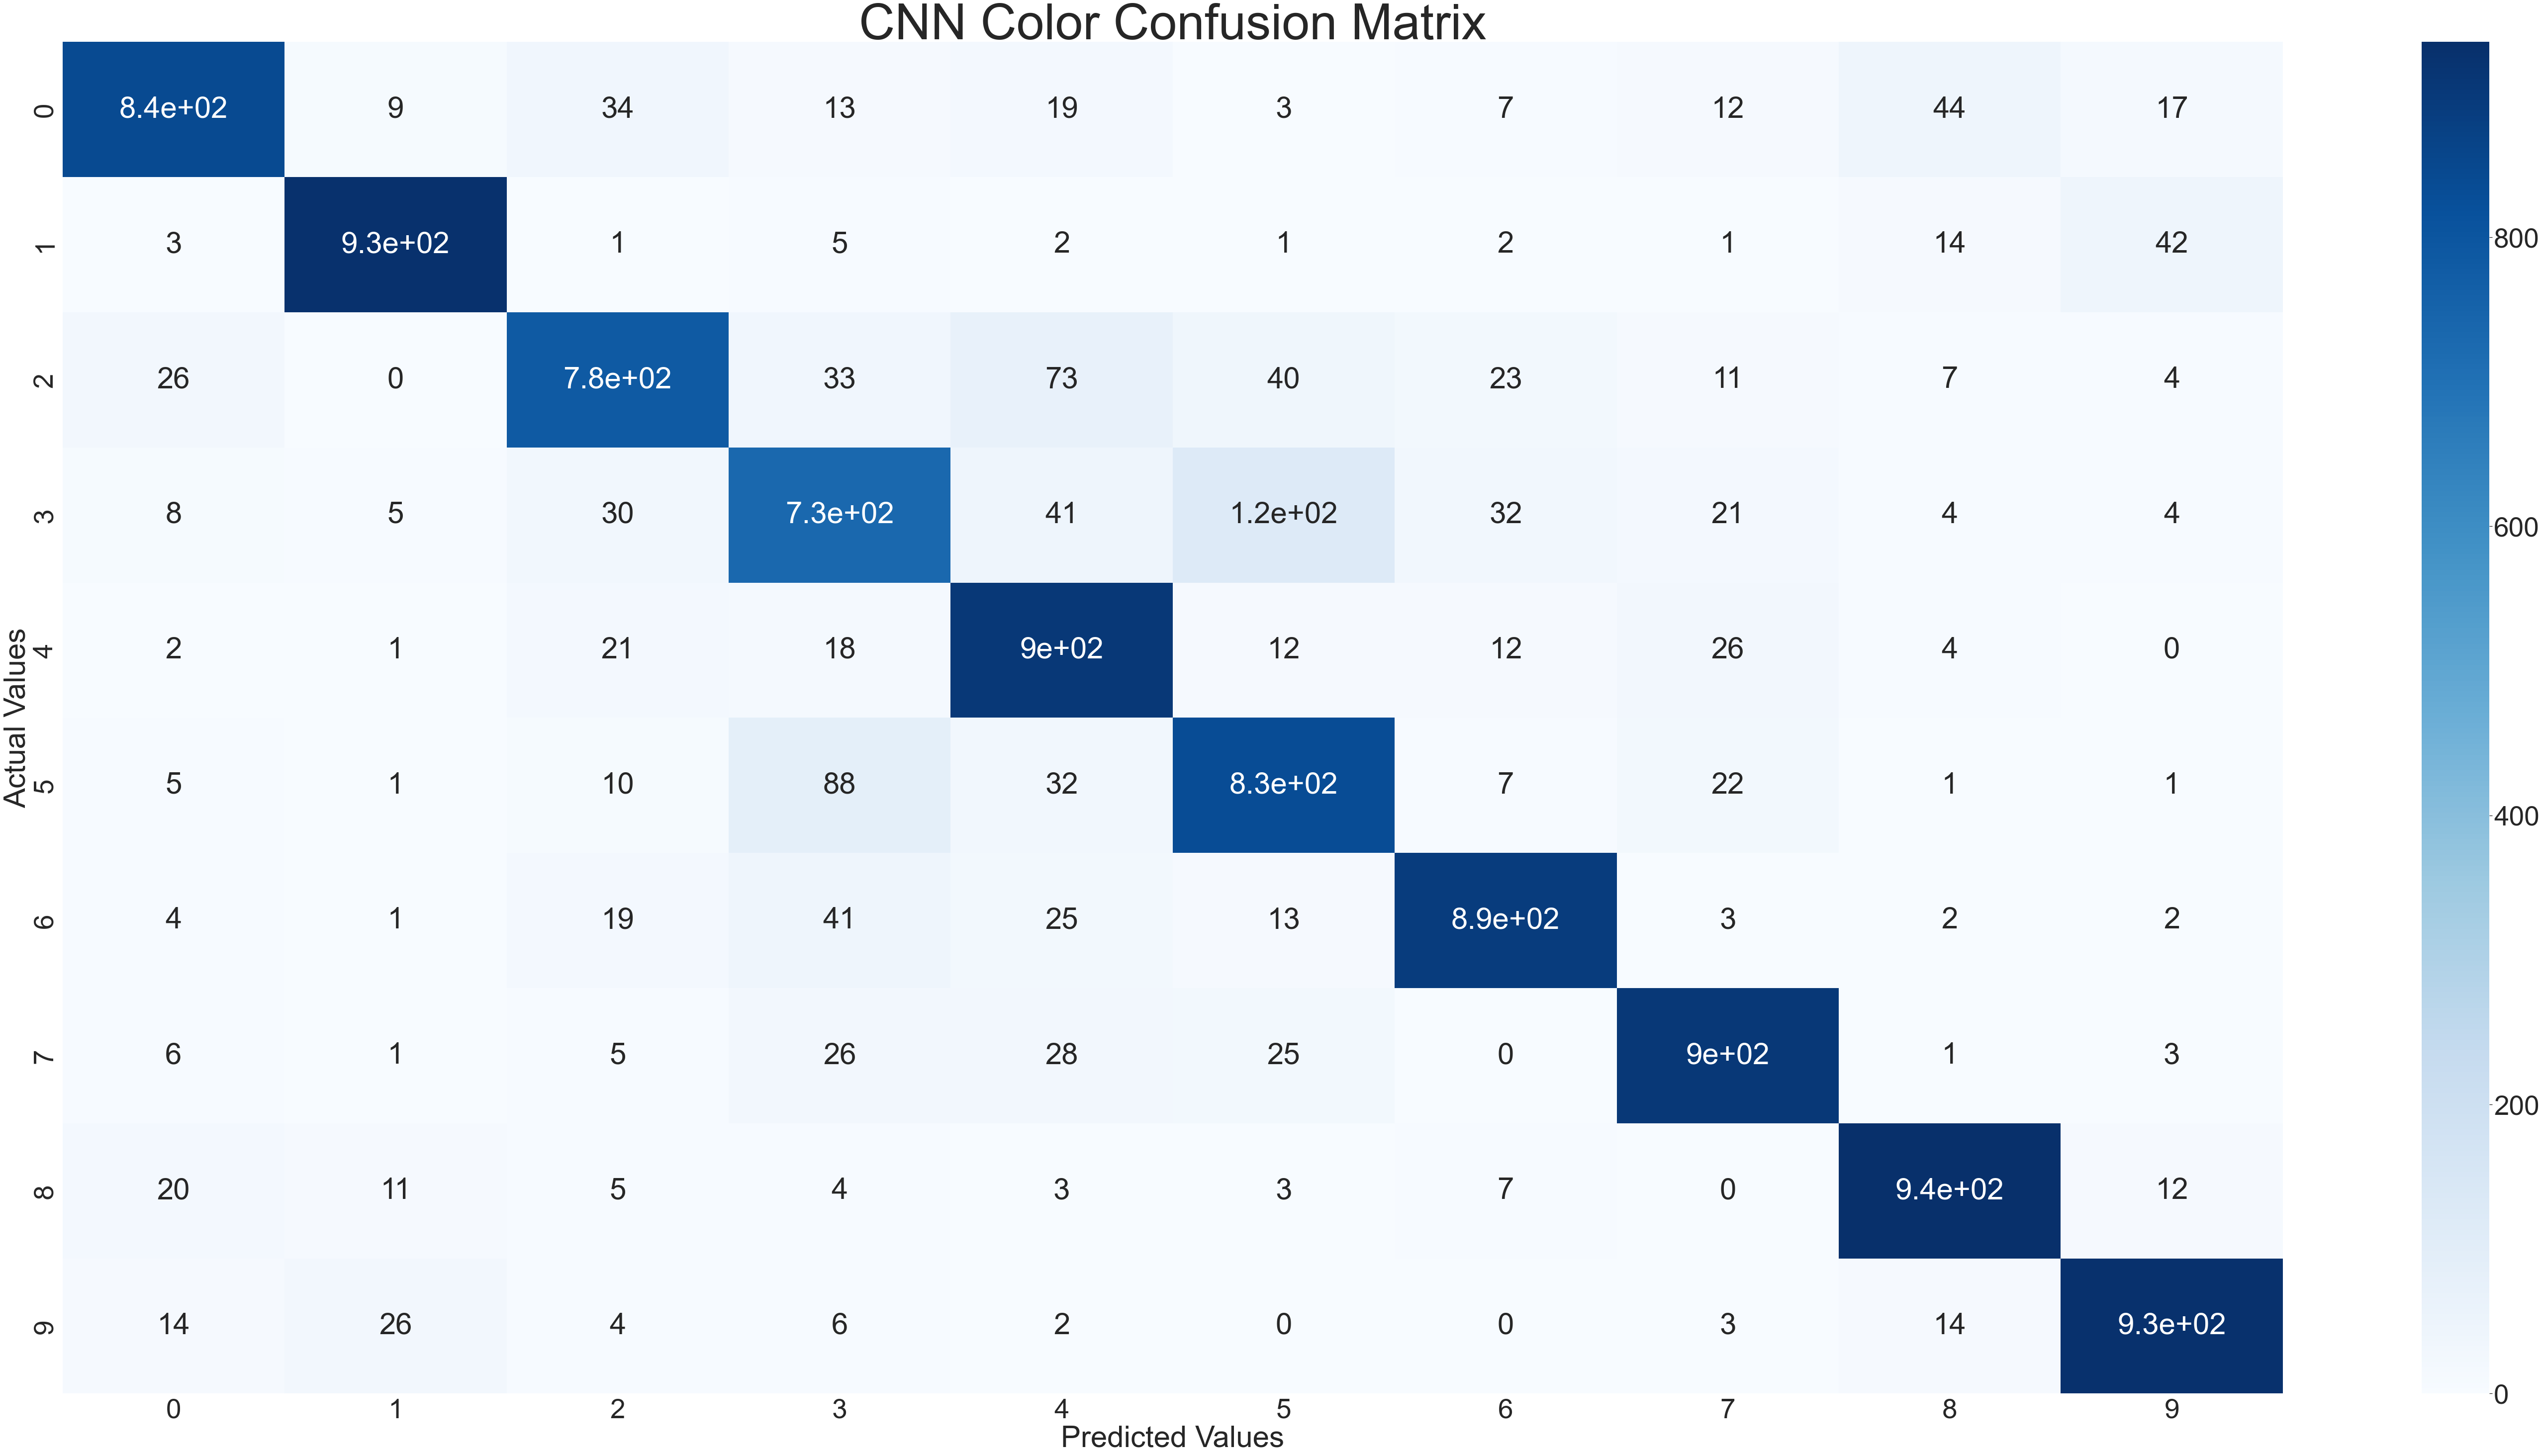

In [18]:
CNN_confusion_matrix = confusion_matrix(colored_y_test, CNN_colored_prediction)
sns.set(font_scale=5)
plt.figure(figsize=(100,50))
sns.heatmap(CNN_confusion_matrix, annot=True,cmap="Blues")
plt.title('CNN {} Confusion Matrix'.format("Color"),fontsize=100)
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

The performance of the model on the coloured dataset is similar to the performance on the grayscale dataset. However, the model is largely overfitting as the loss towards the end of the epochs is seen increasing. This due to the differences between training & validation error which is causing the variance to inceease. 

Furthermore, compared to the model on the grayscale images, the accuracy has increased slightly by 0.04% to 86.83% and the f1-score has also increased by 0.001 to 0.868 

Based on the classification report, the classes with:
<ul>
    <li> Poor Precision - 3,5 as the precisions are below 0.8 </li>
    <li> Poor Recall - 3 as the recalls are below 0.8  </li>
    <li> Poor F1-score - 3 as the f1-scores are below 0.8 </li>
    </ul>

Class 3s' recall is 0.73 and its precision is 0.76. This means that there is higher false negatives than false positives. Hence, class 3 results are not good and a balance must be achieved between the false negatives and false positives in order to imporve the overall classification of class 3.

Class 3 is generally misclassied as Class 5.This could be due to the average pixel instensity peaking between 113-117 as seen in the average pixel intensity histogram in Part 1.

As the model is overfitting,  it is able to classify the images well as the model is memorising the data instead of learning to recognize the patterns in the images. Hence, the models' performance has to be further improved by data augmentation or other means such as reducing the complexity of the CNN architecture

The performance of the model is simlar in both the coloured CIFAR-10 datasetand the grayscale dataset. However the performance on the coloured dataset is slightly higher. This could be due:

<ul>
    <li> Coloured images has more dimensions as it has 3 colour channels, Red, Blue and Green. Thus there are more 3 times more inputs than in grayscale. Hence, it is able to provide additional meaningful information from the images. The model is able to learn these additional information and generalize well on unseen data. Hence, these colour spaces can improve the performance of the model. However, in grayscale images the only information is the brightness of the pixels which may not be enough for the model to learn all meaningful patterns in the dataset </li><br>
   

## 7. Conclusion

In conclusion, Deep Learning models such as CNN performs better than Machine Learning models as it is able to extract the features in the images effectively. 